# Heads-Up

In the notebook, we are working on generating
graphs whose nodes have Euclidean coordinates;
One thing to pay attention to is, in real world
road network, nodes (intersections) that are close
to each other geographically are more likely to be
connected with edges (roads).

Edge centrality will be added as part of the heuristic;
meantime, cosine distance can also be a good heuristic;
The geographical coordinates of nodes can be included.

# Questions

Does centrality really encode information about your destination?

# Think with Analogy

The model should not look back, only forward;
The graph used for training is small and
the trained model is used to infer nodes on
similar sized graphs; perhaps training with
big graphs will lead to better inference
on smaller graphs

# Thoughts

The model does not work very well on larger graph.
One direction to inspect is, does it really make sense
to use Dijkstra path as ground truth when the model
is fed with more meaningful features such as geo-locations
and cos-distances. Perhaps A* is a better algorithm to be 
used to provide the "ground truth"

When the graph grows larger, the size of the network should
grow accordingly so it has enough volume and power to learn
the graph.

# What's Next?

At the moment, the training data only
has knowledge regarding the first order
neighbors of each node; maybe adding second
third order neighbor will help the model to learn
better.

Two steps; firstly, use only the first order neighbor
information but generate large graphs to train, e.g., 
at least 100 nodes; secondly, start writing flexible
functions to encode arbitrary orders of neighbors and
arbitrary number of nodes at each order.

# Practice

* Bigger model works better.
* Add checkpoint to each epoch.

# The model can be confused

Currently, the model is given the cos-distance between (cur_node, next_node) and (cur_node, dst_node);
When I tried to provide the cos-distance between (src_node, next_node) and (src_node, dst_node), the model
did not learn anything in the first few epochs; the accuracy was pure random guess.

The take-away might be that the cos-distance between (src_node, next_node) and (src_node, dst_node) could
easily confuse the model.

A guess of reason was that the model was not provided with information about the src_node; therefore, I tried
to add the coordinates of src node as new features for the model; this didn't work.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [2]:
NUM_NODE = 100
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

In [3]:
def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(node_size=100, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 1000
    euclidean_coords = np.linspace(0.01, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:node_size]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:node_size]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

4
2
100
181


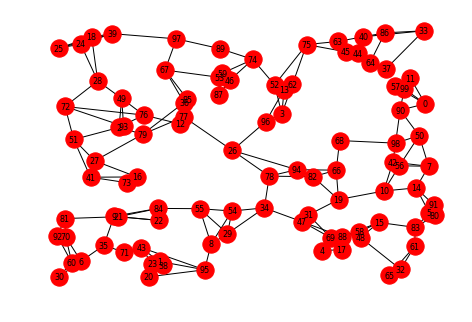

In [7]:
G = generate_low_degree_g(node_size=100)
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())
plot_g(G)

# N.B

for each edge, the feature vector consists the following fields:  
\[centrality, weight, cos_distance, geo_distance, x_node, y_node\]  

the geo-locations of both src and dst are also encoded.Therefore, 
the length of sample vector is: 4 * 6 + 4 = 28.


In [180]:
def calc_cosine_dist(p1, p2):
    return np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))

def encode_edges(G, parent, node, src, dst):
    
    ret = np.zeros((max_degree, 7))
    ret[:, -1] = -1
    
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    
    for idx, edge in enumerate(G.edges(node)):
        u = edge[0]
        v = edge[1]
        
#         Only look forward
        if v == parent:
            continue
        
        ret[idx][0] = G.get_edge_data(u, v)['centrality']
        ret[idx][1] = G.get_edge_data(u, v)['weight']
        
        x_u = G.nodes[u]['x']
        y_u = G.nodes[u]['y']
        x_v = G.nodes[v]['x']
        y_v = G.nodes[v]['y']

        ret[idx][2] = calc_cosine_dist((x_v-x_u, y_v-y_u), (x_dst-x_u, y_dst-y_u))
        ret[idx][3] = calc_euclidean_dist(G, v, dst)
        ret[idx][4] = x_v
        ret[idx][5] = y_v
        ret[idx][-1] = v
        
    return (ret, x_src, y_src, x_dst, y_dst)

def generate_dataset(G):
    
    X = []
    y = []

    for paths in nx.all_pairs_dijkstra_path(G):

        print("src :%d" % paths[0])
        print(paths[1])
        print('')
        src = paths[0]

        for dst, path in paths[1].items():

            if dst == src:
                continue

            # X = cur_node + dst_node
            # y = next_node (Dijkstra)
            parent_node = -1
            cur_node = src
            for mid_node in path[1:]:

                print('parent:(%d), X:(%d, %d), y:(%d)' % (parent_node, cur_node, dst, mid_node))
                X.append(encode_edges(G, parent_node, cur_node, src, dst))
                y.append(mid_node)
                
                parent_node = cur_node
                cur_node = mid_node

    #         print(cur_node, dst)
            print(path)
            print('')
    
    return X, y

In [181]:
features, labels = generate_dataset(G)

src :0
{0: [0], 1: [0, 90, 98, 68, 66, 82, 78, 34, 29, 8, 95, 1], 2: [0, 90, 98, 68, 66, 94, 26, 77, 79, 2], 3: [0, 90, 98, 68, 66, 94, 26, 96, 3], 4: [0, 90, 98, 42, 10, 19, 31, 69, 4], 5: [0, 90, 50, 7, 14, 91, 80, 5], 6: [0, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 35, 6], 7: [0, 90, 50, 7], 8: [0, 90, 98, 68, 66, 82, 78, 34, 29, 8], 9: [0, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9], 10: [0, 90, 98, 42, 10], 11: [0, 11], 12: [0, 90, 98, 68, 66, 94, 26, 77, 12], 13: [0, 90, 98, 68, 66, 94, 26, 96, 13], 14: [0, 90, 50, 7, 14], 15: [0, 90, 50, 7, 14, 91, 80, 83, 15], 16: [0, 90, 98, 68, 66, 94, 26, 77, 79, 27, 16], 17: [0, 90, 98, 42, 10, 19, 31, 69, 17], 18: [0, 90, 98, 68, 66, 94, 26, 77, 12, 76, 49, 28, 18], 19: [0, 90, 98, 42, 10, 19], 20: [0, 90, 98, 68, 66, 82, 78, 34, 29, 8, 95, 20], 21: [0, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 21], 22: [0, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 22], 23: [0, 90, 98, 68, 66, 82, 78, 34, 29, 8, 95, 1, 23], 24: [0, 90, 98, 68, 66, 94, 26, 

parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[0, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(0, 36), y:(90)
parent:(0), X:(90, 36), y:(98)
parent:(90), X:(98, 36), y:(68)
parent:(98), X:(68, 36), y:(66)
parent:(68), X:(66, 36), y:(94)
parent:(66), X:(94, 36), y:(26)
parent:(94), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[0, 90, 98, 68, 66, 94, 26, 77, 85, 36]

parent:(-1), X:(0, 37), y:(90)
parent:(0), X:(90, 37), y:(98)
parent:(90), X:(98, 37), y:(68)
parent:(98), X:(68, 37), y:(66)
parent:(68), X:(66, 37), y:(94)
parent:(66), X:(94, 37), y:(26)
parent:(94), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[0, 90, 98, 68, 66, 94, 26, 96, 13, 52, 75, 45, 4

parent:(10), X:(19, 69), y:(31)
parent:(19), X:(31, 69), y:(69)
[0, 90, 98, 42, 10, 19, 31, 69]

parent:(-1), X:(0, 70), y:(90)
parent:(0), X:(90, 70), y:(98)
parent:(90), X:(98, 70), y:(68)
parent:(98), X:(68, 70), y:(66)
parent:(68), X:(66, 70), y:(82)
parent:(66), X:(82, 70), y:(78)
parent:(82), X:(78, 70), y:(34)
parent:(78), X:(34, 70), y:(54)
parent:(34), X:(54, 70), y:(55)
parent:(54), X:(55, 70), y:(84)
parent:(55), X:(84, 70), y:(9)
parent:(84), X:(9, 70), y:(21)
parent:(9), X:(21, 70), y:(81)
parent:(21), X:(81, 70), y:(92)
parent:(81), X:(92, 70), y:(70)
[0, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent:(-1), X:(0, 71), y:(90)
parent:(0), X:(90, 71), y:(98)
parent:(90), X:(98, 71), y:(68)
parent:(98), X:(68, 71), y:(66)
parent:(68), X:(66, 71), y:(82)
parent:(66), X:(82, 71), y:(78)
parent:(82), X:(78, 71), y:(34)
parent:(78), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(95)
parent:(8), X:(95, 71), y:(43)
parent:(95), X:(4


parent:(-1), X:(1, 6), y:(23)
parent:(1), X:(23, 6), y:(43)
parent:(23), X:(43, 6), y:(71)
parent:(43), X:(71, 6), y:(35)
parent:(71), X:(35, 6), y:(6)
[1, 23, 43, 71, 35, 6]

parent:(-1), X:(1, 7), y:(95)
parent:(1), X:(95, 7), y:(8)
parent:(95), X:(8, 7), y:(29)
parent:(8), X:(29, 7), y:(34)
parent:(29), X:(34, 7), y:(47)
parent:(34), X:(47, 7), y:(31)
parent:(47), X:(31, 7), y:(19)
parent:(31), X:(19, 7), y:(10)
parent:(19), X:(10, 7), y:(14)
parent:(10), X:(14, 7), y:(7)
[1, 95, 8, 29, 34, 47, 31, 19, 10, 14, 7]

parent:(-1), X:(1, 8), y:(95)
parent:(1), X:(95, 8), y:(8)
[1, 95, 8]

parent:(-1), X:(1, 9), y:(23)
parent:(1), X:(23, 9), y:(43)
parent:(23), X:(43, 9), y:(71)
parent:(43), X:(71, 9), y:(35)
parent:(71), X:(35, 9), y:(9)
[1, 23, 43, 71, 35, 9]

parent:(-1), X:(1, 10), y:(95)
parent:(1), X:(95, 10), y:(8)
parent:(95), X:(8, 10), y:(29)
parent:(8), X:(29, 10), y:(34)
parent:(29), X:(34, 10), y:(47)
parent:(34), X:(47, 10), y:(31)
parent:(47), X:(31, 10), y:(19)
parent:(31

parent:(13), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[1, 95, 8, 29, 34, 78, 26, 96, 13, 52, 75, 45, 44]

parent:(-1), X:(1, 45), y:(95)
parent:(1), X:(95, 45), y:(8)
parent:(95), X:(8, 45), y:(29)
parent:(8), X:(29, 45), y:(34)
parent:(29), X:(34, 45), y:(78)
parent:(34), X:(78, 45), y:(26)
parent:(78), X:(26, 45), y:(96)
parent:(26), X:(96, 45), y:(13)
parent:(96), X:(13, 45), y:(52)
parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[1, 95, 8, 29, 34, 78, 26, 96, 13, 52, 75, 45]

parent:(-1), X:(1, 46), y:(95)
parent:(1), X:(95, 46), y:(8)
parent:(95), X:(8, 46), y:(29)
parent:(8), X:(29, 46), y:(34)
parent:(29), X:(34, 46), y:(78)
parent:(34), X:(78, 46), y:(26)
parent:(78), X:(26, 46), y:(96)
parent:(26), X:(96, 46), y:(13)
parent:(96), X:(13, 46), y:(52)
parent:(13), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[1, 95, 8, 29, 34, 78, 26, 96, 13, 52, 74, 46]

parent:(-1), X:(1, 47), y:(95)
parent:(1), X:(95, 47), y:(8)
p

parent:(95), X:(8, 80), y:(29)
parent:(8), X:(29, 80), y:(34)
parent:(29), X:(34, 80), y:(47)
parent:(34), X:(47, 80), y:(31)
parent:(47), X:(31, 80), y:(19)
parent:(31), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
parent:(10), X:(14, 80), y:(91)
parent:(14), X:(91, 80), y:(80)
[1, 95, 8, 29, 34, 47, 31, 19, 10, 14, 91, 80]

parent:(-1), X:(1, 81), y:(23)
parent:(1), X:(23, 81), y:(43)
parent:(23), X:(43, 81), y:(71)
parent:(43), X:(71, 81), y:(35)
parent:(71), X:(35, 81), y:(6)
parent:(35), X:(6, 81), y:(70)
parent:(6), X:(70, 81), y:(92)
parent:(70), X:(92, 81), y:(81)
[1, 23, 43, 71, 35, 6, 70, 92, 81]

parent:(-1), X:(1, 82), y:(95)
parent:(1), X:(95, 82), y:(8)
parent:(95), X:(8, 82), y:(29)
parent:(8), X:(29, 82), y:(34)
parent:(29), X:(34, 82), y:(78)
parent:(34), X:(78, 82), y:(82)
[1, 95, 8, 29, 34, 78, 82]

parent:(-1), X:(1, 83), y:(95)
parent:(1), X:(95, 83), y:(8)
parent:(95), X:(8, 83), y:(29)
parent:(8), X:(29, 83), y:(34)
parent:(29), X:(34, 83), y:(47)
parent:(3

[2, 79, 77, 26, 94, 82, 19]

parent:(-1), X:(2, 20), y:(79)
parent:(2), X:(79, 20), y:(77)
parent:(79), X:(77, 20), y:(26)
parent:(77), X:(26, 20), y:(78)
parent:(26), X:(78, 20), y:(34)
parent:(78), X:(34, 20), y:(29)
parent:(34), X:(29, 20), y:(8)
parent:(29), X:(8, 20), y:(95)
parent:(8), X:(95, 20), y:(20)
[2, 79, 77, 26, 78, 34, 29, 8, 95, 20]

parent:(-1), X:(2, 21), y:(79)
parent:(2), X:(79, 21), y:(77)
parent:(79), X:(77, 21), y:(26)
parent:(77), X:(26, 21), y:(78)
parent:(26), X:(78, 21), y:(34)
parent:(78), X:(34, 21), y:(54)
parent:(34), X:(54, 21), y:(55)
parent:(54), X:(55, 21), y:(84)
parent:(55), X:(84, 21), y:(9)
parent:(84), X:(9, 21), y:(21)
[2, 79, 77, 26, 78, 34, 54, 55, 84, 9, 21]

parent:(-1), X:(2, 22), y:(79)
parent:(2), X:(79, 22), y:(77)
parent:(79), X:(77, 22), y:(26)
parent:(77), X:(26, 22), y:(78)
parent:(26), X:(78, 22), y:(34)
parent:(78), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[2

parent:(2), X:(79, 59), y:(36)
parent:(79), X:(36, 59), y:(67)
parent:(36), X:(67, 59), y:(53)
parent:(67), X:(53, 59), y:(59)
[2, 79, 36, 67, 53, 59]

parent:(-1), X:(2, 60), y:(79)
parent:(2), X:(79, 60), y:(77)
parent:(79), X:(77, 60), y:(26)
parent:(77), X:(26, 60), y:(78)
parent:(26), X:(78, 60), y:(34)
parent:(78), X:(34, 60), y:(54)
parent:(34), X:(54, 60), y:(55)
parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[2, 79, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(2, 61), y:(79)
parent:(2), X:(79, 61), y:(77)
parent:(79), X:(77, 61), y:(26)
parent:(77), X:(26, 61), y:(94)
parent:(26), X:(94, 61), y:(82)
parent:(94), X:(82, 61), y:(19)
parent:(82), X:(19, 61), y:(10)
parent:(19), X:(10, 61), y:(14)
parent:(10), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[2, 79, 77, 26, 94, 82, 19, 10, 14, 91

parent:(3), X:(96, 10), y:(26)
parent:(96), X:(26, 10), y:(94)
parent:(26), X:(94, 10), y:(82)
parent:(94), X:(82, 10), y:(19)
parent:(82), X:(19, 10), y:(10)
[3, 96, 26, 94, 82, 19, 10]

parent:(-1), X:(3, 11), y:(96)
parent:(3), X:(96, 11), y:(26)
parent:(96), X:(26, 11), y:(94)
parent:(26), X:(94, 11), y:(66)
parent:(94), X:(66, 11), y:(68)
parent:(66), X:(68, 11), y:(98)
parent:(68), X:(98, 11), y:(90)
parent:(98), X:(90, 11), y:(99)
parent:(90), X:(99, 11), y:(11)
[3, 96, 26, 94, 66, 68, 98, 90, 99, 11]

parent:(-1), X:(3, 12), y:(96)
parent:(3), X:(96, 12), y:(26)
parent:(96), X:(26, 12), y:(77)
parent:(26), X:(77, 12), y:(12)
[3, 96, 26, 77, 12]

parent:(-1), X:(3, 13), y:(13)
[3, 13]

parent:(-1), X:(3, 14), y:(96)
parent:(3), X:(96, 14), y:(26)
parent:(96), X:(26, 14), y:(94)
parent:(26), X:(94, 14), y:(82)
parent:(94), X:(82, 14), y:(19)
parent:(82), X:(19, 14), y:(10)
parent:(19), X:(10, 14), y:(14)
[3, 96, 26, 94, 82, 19, 10, 14]

parent:(-1), X:(3, 15), y:(96)
parent:(3), 


parent:(-1), X:(3, 56), y:(96)
parent:(3), X:(96, 56), y:(26)
parent:(96), X:(26, 56), y:(94)
parent:(26), X:(94, 56), y:(82)
parent:(94), X:(82, 56), y:(19)
parent:(82), X:(19, 56), y:(10)
parent:(19), X:(10, 56), y:(42)
parent:(10), X:(42, 56), y:(56)
[3, 96, 26, 94, 82, 19, 10, 42, 56]

parent:(-1), X:(3, 57), y:(96)
parent:(3), X:(96, 57), y:(26)
parent:(96), X:(26, 57), y:(94)
parent:(26), X:(94, 57), y:(66)
parent:(94), X:(66, 57), y:(68)
parent:(66), X:(68, 57), y:(98)
parent:(68), X:(98, 57), y:(90)
parent:(98), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[3, 96, 26, 94, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(3, 58), y:(96)
parent:(3), X:(96, 58), y:(26)
parent:(96), X:(26, 58), y:(78)
parent:(26), X:(78, 58), y:(34)
parent:(78), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[3, 96, 26, 78, 34, 47, 88, 58]

parent:(-1), X:(3, 59), y:(13)
parent:(3), X:(13, 59), y:(52)
parent:(13), X:(52, 59), y:(74)
parent:(52), X:(74, 59), y:(59)


parent:(78), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[4, 69, 47, 34, 78, 26, 77, 79, 2]

parent:(-1), X:(4, 3), y:(69)
parent:(4), X:(69, 3), y:(47)
parent:(69), X:(47, 3), y:(34)
parent:(47), X:(34, 3), y:(78)
parent:(34), X:(78, 3), y:(26)
parent:(78), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[4, 69, 47, 34, 78, 26, 96, 3]

parent:(-1), X:(4, 5), y:(17)
parent:(4), X:(17, 5), y:(88)
parent:(17), X:(88, 5), y:(58)
parent:(88), X:(58, 5), y:(15)
parent:(58), X:(15, 5), y:(83)
parent:(15), X:(83, 5), y:(80)
parent:(83), X:(80, 5), y:(5)
[4, 17, 88, 58, 15, 83, 80, 5]

parent:(-1), X:(4, 6), y:(69)
parent:(4), X:(69, 6), y:(47)
parent:(69), X:(47, 6), y:(34)
parent:(47), X:(34, 6), y:(54)
parent:(34), X:(54, 6), y:(55)
parent:(54), X:(55, 6), y:(84)
parent:(55), X:(84, 6), y:(9)
parent:(84), X:(9, 6), y:(35)
parent:(9), X:(35, 6), y:(6)
[4, 69, 47, 34, 54, 55, 84, 9, 35, 6]

parent:(-1), X:(4, 7), y:(17)
parent:(4), X:(17, 7), y:(88)
parent:(

parent:(96), X:(13, 44), y:(52)
parent:(13), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[4, 69, 47, 34, 78, 26, 96, 13, 52, 75, 45, 44]

parent:(-1), X:(4, 45), y:(69)
parent:(4), X:(69, 45), y:(47)
parent:(69), X:(47, 45), y:(34)
parent:(47), X:(34, 45), y:(78)
parent:(34), X:(78, 45), y:(26)
parent:(78), X:(26, 45), y:(96)
parent:(26), X:(96, 45), y:(13)
parent:(96), X:(13, 45), y:(52)
parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[4, 69, 47, 34, 78, 26, 96, 13, 52, 75, 45]

parent:(-1), X:(4, 46), y:(69)
parent:(4), X:(69, 46), y:(47)
parent:(69), X:(47, 46), y:(34)
parent:(47), X:(34, 46), y:(78)
parent:(34), X:(78, 46), y:(26)
parent:(78), X:(26, 46), y:(96)
parent:(26), X:(96, 46), y:(13)
parent:(96), X:(13, 46), y:(52)
parent:(13), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[4, 69, 47, 34, 78, 26, 96, 13, 52, 74, 46]

parent:(-1), X:(4, 47), y:(69)
parent:(4), X:(69, 47), y:(47)
[4, 69, 47]

parent:(-1), X:(4, 48)

parent:(34), X:(78, 86), y:(26)
parent:(78), X:(26, 86), y:(96)
parent:(26), X:(96, 86), y:(13)
parent:(96), X:(13, 86), y:(52)
parent:(13), X:(52, 86), y:(75)
parent:(52), X:(75, 86), y:(63)
parent:(75), X:(63, 86), y:(40)
parent:(63), X:(40, 86), y:(86)
[4, 69, 47, 34, 78, 26, 96, 13, 52, 75, 63, 40, 86]

parent:(-1), X:(4, 87), y:(69)
parent:(4), X:(69, 87), y:(47)
parent:(69), X:(47, 87), y:(34)
parent:(47), X:(34, 87), y:(78)
parent:(34), X:(78, 87), y:(26)
parent:(78), X:(26, 87), y:(96)
parent:(26), X:(96, 87), y:(13)
parent:(96), X:(13, 87), y:(52)
parent:(13), X:(52, 87), y:(74)
parent:(52), X:(74, 87), y:(46)
parent:(74), X:(46, 87), y:(87)
[4, 69, 47, 34, 78, 26, 96, 13, 52, 74, 46, 87]

parent:(-1), X:(4, 88), y:(17)
parent:(4), X:(17, 88), y:(88)
[4, 17, 88]

parent:(-1), X:(4, 89), y:(69)
parent:(4), X:(69, 89), y:(47)
parent:(69), X:(47, 89), y:(34)
parent:(47), X:(34, 89), y:(78)
parent:(34), X:(78, 89), y:(26)
parent:(78), X:(26, 89), y:(96)
parent:(26), X:(96, 89), y:

parent:(5), X:(80, 22), y:(91)
parent:(80), X:(91, 22), y:(14)
parent:(91), X:(14, 22), y:(10)
parent:(14), X:(10, 22), y:(19)
parent:(10), X:(19, 22), y:(31)
parent:(19), X:(31, 22), y:(47)
parent:(31), X:(47, 22), y:(34)
parent:(47), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[5, 80, 91, 14, 10, 19, 31, 47, 34, 54, 55, 84, 22]

parent:(-1), X:(5, 23), y:(80)
parent:(5), X:(80, 23), y:(91)
parent:(80), X:(91, 23), y:(14)
parent:(91), X:(14, 23), y:(10)
parent:(14), X:(10, 23), y:(19)
parent:(10), X:(19, 23), y:(31)
parent:(19), X:(31, 23), y:(47)
parent:(31), X:(47, 23), y:(34)
parent:(47), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[5, 80, 91, 14, 10, 19, 31, 47, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(5, 24), y:(80)
parent:(5), X:(80, 24), y:(91)
parent:(80), X:(91, 24), y:(14)
parent:(91), X:(14, 24), y:(10)
parent

parent:(88), X:(17, 69), y:(69)
[5, 80, 83, 15, 58, 88, 17, 69]

parent:(-1), X:(5, 70), y:(80)
parent:(5), X:(80, 70), y:(91)
parent:(80), X:(91, 70), y:(14)
parent:(91), X:(14, 70), y:(10)
parent:(14), X:(10, 70), y:(19)
parent:(10), X:(19, 70), y:(31)
parent:(19), X:(31, 70), y:(47)
parent:(31), X:(47, 70), y:(34)
parent:(47), X:(34, 70), y:(54)
parent:(34), X:(54, 70), y:(55)
parent:(54), X:(55, 70), y:(84)
parent:(55), X:(84, 70), y:(9)
parent:(84), X:(9, 70), y:(21)
parent:(9), X:(21, 70), y:(81)
parent:(21), X:(81, 70), y:(92)
parent:(81), X:(92, 70), y:(70)
[5, 80, 91, 14, 10, 19, 31, 47, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent:(-1), X:(5, 71), y:(80)
parent:(5), X:(80, 71), y:(91)
parent:(80), X:(91, 71), y:(14)
parent:(91), X:(14, 71), y:(10)
parent:(14), X:(10, 71), y:(19)
parent:(10), X:(19, 71), y:(31)
parent:(19), X:(31, 71), y:(47)
parent:(31), X:(47, 71), y:(34)
parent:(47), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(95)
parent:(8), 

parent:(35), X:(9, 2), y:(84)
parent:(9), X:(84, 2), y:(55)
parent:(84), X:(55, 2), y:(54)
parent:(55), X:(54, 2), y:(34)
parent:(54), X:(34, 2), y:(78)
parent:(34), X:(78, 2), y:(26)
parent:(78), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[6, 35, 9, 84, 55, 54, 34, 78, 26, 77, 79, 2]

parent:(-1), X:(6, 3), y:(35)
parent:(6), X:(35, 3), y:(9)
parent:(35), X:(9, 3), y:(84)
parent:(9), X:(84, 3), y:(55)
parent:(84), X:(55, 3), y:(54)
parent:(55), X:(54, 3), y:(34)
parent:(54), X:(34, 3), y:(78)
parent:(34), X:(78, 3), y:(26)
parent:(78), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[6, 35, 9, 84, 55, 54, 34, 78, 26, 96, 3]

parent:(-1), X:(6, 4), y:(35)
parent:(6), X:(35, 4), y:(9)
parent:(35), X:(9, 4), y:(84)
parent:(9), X:(84, 4), y:(55)
parent:(84), X:(55, 4), y:(54)
parent:(55), X:(54, 4), y:(34)
parent:(54), X:(34, 4), y:(47)
parent:(34), X:(47, 4), y:(69)
parent:(47), X:(69, 4), y:(4)
[6, 35, 9, 84, 55, 54, 34, 47, 69, 4]

parent:(-1), X:(6,

[6, 35, 9, 84, 55, 54, 34, 78, 26, 77, 85, 36]

parent:(-1), X:(6, 37), y:(35)
parent:(6), X:(35, 37), y:(9)
parent:(35), X:(9, 37), y:(84)
parent:(9), X:(84, 37), y:(55)
parent:(84), X:(55, 37), y:(54)
parent:(55), X:(54, 37), y:(34)
parent:(54), X:(34, 37), y:(78)
parent:(34), X:(78, 37), y:(26)
parent:(78), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[6, 35, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 75, 45, 44, 64, 37]

parent:(-1), X:(6, 38), y:(35)
parent:(6), X:(35, 38), y:(71)
parent:(35), X:(71, 38), y:(43)
parent:(71), X:(43, 38), y:(38)
[6, 35, 71, 43, 38]

parent:(-1), X:(6, 39), y:(35)
parent:(6), X:(35, 39), y:(9)
parent:(35), X:(9, 39), y:(84)
parent:(9), X:(84, 39), y:(55)
parent:(84), X:(55, 39), y:(54)
parent:(55), X:(54, 39), y:(34)
parent:(54), X:(34, 39), y:(78)
parent:(34)

parent:(78), X:(82, 66), y:(66)
[6, 35, 9, 84, 55, 54, 34, 78, 82, 66]

parent:(-1), X:(6, 67), y:(35)
parent:(6), X:(35, 67), y:(9)
parent:(35), X:(9, 67), y:(84)
parent:(9), X:(84, 67), y:(55)
parent:(84), X:(55, 67), y:(54)
parent:(55), X:(54, 67), y:(34)
parent:(54), X:(34, 67), y:(78)
parent:(34), X:(78, 67), y:(26)
parent:(78), X:(26, 67), y:(77)
parent:(26), X:(77, 67), y:(85)
parent:(77), X:(85, 67), y:(36)
parent:(85), X:(36, 67), y:(67)
[6, 35, 9, 84, 55, 54, 34, 78, 26, 77, 85, 36, 67]

parent:(-1), X:(6, 68), y:(35)
parent:(6), X:(35, 68), y:(9)
parent:(35), X:(9, 68), y:(84)
parent:(9), X:(84, 68), y:(55)
parent:(84), X:(55, 68), y:(54)
parent:(55), X:(54, 68), y:(34)
parent:(54), X:(34, 68), y:(78)
parent:(34), X:(78, 68), y:(82)
parent:(78), X:(82, 68), y:(66)
parent:(82), X:(66, 68), y:(68)
[6, 35, 9, 84, 55, 54, 34, 78, 82, 66, 68]

parent:(-1), X:(6, 69), y:(35)
parent:(6), X:(35, 69), y:(9)
parent:(35), X:(9, 69), y:(84)
parent:(9), X:(84, 69), y:(55)
parent:(84), X:

parent:(78), X:(82, 99), y:(66)
parent:(82), X:(66, 99), y:(68)
parent:(66), X:(68, 99), y:(98)
parent:(68), X:(98, 99), y:(90)
parent:(98), X:(90, 99), y:(99)
[6, 35, 9, 84, 55, 54, 34, 78, 82, 66, 68, 98, 90, 99]

src :7
{0: [7, 50, 90, 0], 1: [7, 14, 10, 19, 31, 47, 34, 29, 8, 95, 1], 2: [7, 14, 10, 19, 82, 94, 26, 77, 79, 2], 3: [7, 14, 10, 19, 82, 94, 26, 96, 3], 4: [7, 14, 91, 80, 83, 15, 58, 88, 17, 4], 5: [7, 14, 91, 80, 5], 6: [7, 14, 10, 19, 31, 47, 34, 54, 55, 84, 9, 35, 6], 7: [7], 8: [7, 14, 10, 19, 31, 47, 34, 29, 8], 9: [7, 14, 10, 19, 31, 47, 34, 54, 55, 84, 9], 10: [7, 14, 10], 11: [7, 50, 90, 99, 11], 12: [7, 14, 10, 19, 82, 94, 26, 77, 12], 13: [7, 14, 10, 19, 82, 94, 26, 96, 13], 14: [7, 14], 15: [7, 14, 91, 80, 83, 15], 16: [7, 14, 10, 19, 82, 94, 26, 77, 79, 27, 16], 17: [7, 14, 91, 80, 83, 15, 58, 88, 17], 18: [7, 14, 10, 19, 82, 94, 26, 77, 12, 76, 49, 28, 18], 19: [7, 14, 10, 19], 20: [7, 14, 10, 19, 31, 47, 34, 29, 8, 95, 20], 21: [7, 14, 10, 19, 31, 47, 34, 5

parent:(94), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[7, 14, 10, 19, 82, 94, 26, 77, 85, 36]

parent:(-1), X:(7, 37), y:(14)
parent:(7), X:(14, 37), y:(10)
parent:(14), X:(10, 37), y:(19)
parent:(10), X:(19, 37), y:(82)
parent:(19), X:(82, 37), y:(94)
parent:(82), X:(94, 37), y:(26)
parent:(94), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[7, 14, 10, 19, 82, 94, 26, 96, 13, 52, 75, 45, 44, 64, 37]

parent:(-1), X:(7, 38), y:(14)
parent:(7), X:(14, 38), y:(10)
parent:(14), X:(10, 38), y:(19)
parent:(10), X:(19, 38), y:(31)
parent:(19), X:(31, 38), y:(47)
parent:(31), X:(47, 38), y:(34)
parent:(47), X:(34, 38), y:(29)
parent:(34), X:(29, 38), y:(8)
parent:(29), X:(8, 38), y:(95)
parent:(8), X:(95, 38), y:(1)
parent:(95), X:(1, 38), y:(38)
[7, 14, 10,

parent:(14), X:(10, 72), y:(19)
parent:(10), X:(19, 72), y:(82)
parent:(19), X:(82, 72), y:(94)
parent:(82), X:(94, 72), y:(26)
parent:(94), X:(26, 72), y:(77)
parent:(26), X:(77, 72), y:(79)
parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[7, 14, 10, 19, 82, 94, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(7, 73), y:(14)
parent:(7), X:(14, 73), y:(10)
parent:(14), X:(10, 73), y:(19)
parent:(10), X:(19, 73), y:(82)
parent:(19), X:(82, 73), y:(94)
parent:(82), X:(94, 73), y:(26)
parent:(94), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[7, 14, 10, 19, 82, 94, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(7, 74), y:(14)
parent:(7), X:(14, 74), y:(10)
parent:(14), X:(10, 74), y:(19)
parent:(10), X:(19, 74), y:(82)
parent:(19), X:(82, 74), y:(94)
parent:(82), X:(94, 74), y:(26)
parent:(94), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X

parent:(77), X:(79, 2), y:(2)
[8, 29, 34, 78, 26, 77, 79, 2]

parent:(-1), X:(8, 3), y:(29)
parent:(8), X:(29, 3), y:(34)
parent:(29), X:(34, 3), y:(78)
parent:(34), X:(78, 3), y:(26)
parent:(78), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[8, 29, 34, 78, 26, 96, 3]

parent:(-1), X:(8, 4), y:(29)
parent:(8), X:(29, 4), y:(34)
parent:(29), X:(34, 4), y:(47)
parent:(34), X:(47, 4), y:(69)
parent:(47), X:(69, 4), y:(4)
[8, 29, 34, 47, 69, 4]

parent:(-1), X:(8, 5), y:(29)
parent:(8), X:(29, 5), y:(34)
parent:(29), X:(34, 5), y:(47)
parent:(34), X:(47, 5), y:(31)
parent:(47), X:(31, 5), y:(19)
parent:(31), X:(19, 5), y:(10)
parent:(19), X:(10, 5), y:(14)
parent:(10), X:(14, 5), y:(91)
parent:(14), X:(91, 5), y:(80)
parent:(91), X:(80, 5), y:(5)
[8, 29, 34, 47, 31, 19, 10, 14, 91, 80, 5]

parent:(-1), X:(8, 6), y:(95)
parent:(8), X:(95, 6), y:(43)
parent:(95), X:(43, 6), y:(71)
parent:(43), X:(71, 6), y:(35)
parent:(71), X:(35, 6), y:(6)
[8, 95, 43, 71, 35, 6]

parent:(-1), X:(8, 7), y

parent:(8), X:(29, 42), y:(34)
parent:(29), X:(34, 42), y:(47)
parent:(34), X:(47, 42), y:(31)
parent:(47), X:(31, 42), y:(19)
parent:(31), X:(19, 42), y:(10)
parent:(19), X:(10, 42), y:(42)
[8, 29, 34, 47, 31, 19, 10, 42]

parent:(-1), X:(8, 43), y:(95)
parent:(8), X:(95, 43), y:(43)
[8, 95, 43]

parent:(-1), X:(8, 44), y:(29)
parent:(8), X:(29, 44), y:(34)
parent:(29), X:(34, 44), y:(78)
parent:(34), X:(78, 44), y:(26)
parent:(78), X:(26, 44), y:(96)
parent:(26), X:(96, 44), y:(13)
parent:(96), X:(13, 44), y:(52)
parent:(13), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[8, 29, 34, 78, 26, 96, 13, 52, 75, 45, 44]

parent:(-1), X:(8, 45), y:(29)
parent:(8), X:(29, 45), y:(34)
parent:(29), X:(34, 45), y:(78)
parent:(34), X:(78, 45), y:(26)
parent:(78), X:(26, 45), y:(96)
parent:(26), X:(96, 45), y:(13)
parent:(96), X:(13, 45), y:(52)
parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[8, 29, 34, 78, 26, 96, 13, 52, 75, 45]

parent:(-1)

parent:(75), X:(63, 86), y:(40)
parent:(63), X:(40, 86), y:(86)
[8, 29, 34, 78, 26, 96, 13, 52, 75, 63, 40, 86]

parent:(-1), X:(8, 87), y:(29)
parent:(8), X:(29, 87), y:(34)
parent:(29), X:(34, 87), y:(78)
parent:(34), X:(78, 87), y:(26)
parent:(78), X:(26, 87), y:(96)
parent:(26), X:(96, 87), y:(13)
parent:(96), X:(13, 87), y:(52)
parent:(13), X:(52, 87), y:(74)
parent:(52), X:(74, 87), y:(46)
parent:(74), X:(46, 87), y:(87)
[8, 29, 34, 78, 26, 96, 13, 52, 74, 46, 87]

parent:(-1), X:(8, 88), y:(29)
parent:(8), X:(29, 88), y:(34)
parent:(29), X:(34, 88), y:(47)
parent:(34), X:(47, 88), y:(88)
[8, 29, 34, 47, 88]

parent:(-1), X:(8, 89), y:(29)
parent:(8), X:(29, 89), y:(34)
parent:(29), X:(34, 89), y:(78)
parent:(34), X:(78, 89), y:(26)
parent:(78), X:(26, 89), y:(96)
parent:(26), X:(96, 89), y:(13)
parent:(96), X:(13, 89), y:(52)
parent:(13), X:(52, 89), y:(74)
parent:(52), X:(74, 89), y:(89)
[8, 29, 34, 78, 26, 96, 13, 52, 74, 89]

parent:(-1), X:(8, 90), y:(29)
parent:(8), X:(29, 

parent:(77), X:(12, 28), y:(76)
parent:(12), X:(76, 28), y:(49)
parent:(76), X:(49, 28), y:(28)
[9, 84, 55, 54, 34, 78, 26, 77, 12, 76, 49, 28]

parent:(-1), X:(9, 29), y:(84)
parent:(9), X:(84, 29), y:(55)
parent:(84), X:(55, 29), y:(54)
parent:(55), X:(54, 29), y:(29)
[9, 84, 55, 54, 29]

parent:(-1), X:(9, 30), y:(35)
parent:(9), X:(35, 30), y:(6)
parent:(35), X:(6, 30), y:(60)
parent:(6), X:(60, 30), y:(30)
[9, 35, 6, 60, 30]

parent:(-1), X:(9, 31), y:(84)
parent:(9), X:(84, 31), y:(55)
parent:(84), X:(55, 31), y:(54)
parent:(55), X:(54, 31), y:(34)
parent:(54), X:(34, 31), y:(47)
parent:(34), X:(47, 31), y:(31)
[9, 84, 55, 54, 34, 47, 31]

parent:(-1), X:(9, 32), y:(84)
parent:(9), X:(84, 32), y:(55)
parent:(84), X:(55, 32), y:(54)
parent:(55), X:(54, 32), y:(34)
parent:(54), X:(34, 32), y:(47)
parent:(34), X:(47, 32), y:(88)
parent:(47), X:(88, 32), y:(58)
parent:(88), X:(58, 32), y:(48)
parent:(58), X:(48, 32), y:(32)
[9, 84, 55, 54, 34, 47, 88, 58, 48, 32]

parent:(-1), X:(9, 

parent:(9), X:(84, 66), y:(55)
parent:(84), X:(55, 66), y:(54)
parent:(55), X:(54, 66), y:(34)
parent:(54), X:(34, 66), y:(78)
parent:(34), X:(78, 66), y:(82)
parent:(78), X:(82, 66), y:(66)
[9, 84, 55, 54, 34, 78, 82, 66]

parent:(-1), X:(9, 67), y:(84)
parent:(9), X:(84, 67), y:(55)
parent:(84), X:(55, 67), y:(54)
parent:(55), X:(54, 67), y:(34)
parent:(54), X:(34, 67), y:(78)
parent:(34), X:(78, 67), y:(26)
parent:(78), X:(26, 67), y:(77)
parent:(26), X:(77, 67), y:(85)
parent:(77), X:(85, 67), y:(36)
parent:(85), X:(36, 67), y:(67)
[9, 84, 55, 54, 34, 78, 26, 77, 85, 36, 67]

parent:(-1), X:(9, 68), y:(84)
parent:(9), X:(84, 68), y:(55)
parent:(84), X:(55, 68), y:(54)
parent:(55), X:(54, 68), y:(34)
parent:(54), X:(34, 68), y:(78)
parent:(34), X:(78, 68), y:(82)
parent:(78), X:(82, 68), y:(66)
parent:(82), X:(66, 68), y:(68)
[9, 84, 55, 54, 34, 78, 82, 66, 68]

parent:(-1), X:(9, 69), y:(84)
parent:(9), X:(84, 69), y:(55)
parent:(84), X:(55, 69), y:(54)
parent:(55), X:(54, 69), y:(

parent:(84), X:(9, 6), y:(35)
parent:(9), X:(35, 6), y:(6)
[10, 19, 31, 47, 34, 54, 55, 84, 9, 35, 6]

parent:(-1), X:(10, 7), y:(14)
parent:(10), X:(14, 7), y:(7)
[10, 14, 7]

parent:(-1), X:(10, 8), y:(19)
parent:(10), X:(19, 8), y:(31)
parent:(19), X:(31, 8), y:(47)
parent:(31), X:(47, 8), y:(34)
parent:(47), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[10, 19, 31, 47, 34, 29, 8]

parent:(-1), X:(10, 9), y:(19)
parent:(10), X:(19, 9), y:(31)
parent:(19), X:(31, 9), y:(47)
parent:(31), X:(47, 9), y:(34)
parent:(47), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
parent:(54), X:(55, 9), y:(84)
parent:(55), X:(84, 9), y:(9)
[10, 19, 31, 47, 34, 54, 55, 84, 9]

parent:(-1), X:(10, 11), y:(42)
parent:(10), X:(42, 11), y:(98)
parent:(42), X:(98, 11), y:(90)
parent:(98), X:(90, 11), y:(99)
parent:(90), X:(99, 11), y:(11)
[10, 42, 98, 90, 99, 11]

parent:(-1), X:(10, 12), y:(19)
parent:(10), X:(19, 12), y:(82)
parent:(19), X:(82, 12), y:(94)
parent:(82), X:(94, 12), y:(26)
parent:(94)

parent:(26), X:(77, 51), y:(79)
parent:(77), X:(79, 51), y:(27)
parent:(79), X:(27, 51), y:(51)
[10, 19, 82, 94, 26, 77, 79, 27, 51]

parent:(-1), X:(10, 52), y:(19)
parent:(10), X:(19, 52), y:(82)
parent:(19), X:(82, 52), y:(94)
parent:(82), X:(94, 52), y:(26)
parent:(94), X:(26, 52), y:(96)
parent:(26), X:(96, 52), y:(13)
parent:(96), X:(13, 52), y:(52)
[10, 19, 82, 94, 26, 96, 13, 52]

parent:(-1), X:(10, 53), y:(19)
parent:(10), X:(19, 53), y:(82)
parent:(19), X:(82, 53), y:(94)
parent:(82), X:(94, 53), y:(26)
parent:(94), X:(26, 53), y:(96)
parent:(26), X:(96, 53), y:(13)
parent:(96), X:(13, 53), y:(52)
parent:(13), X:(52, 53), y:(74)
parent:(52), X:(74, 53), y:(59)
parent:(74), X:(59, 53), y:(53)
[10, 19, 82, 94, 26, 96, 13, 52, 74, 59, 53]

parent:(-1), X:(10, 54), y:(19)
parent:(10), X:(19, 54), y:(31)
parent:(19), X:(31, 54), y:(47)
parent:(31), X:(47, 54), y:(34)
parent:(47), X:(34, 54), y:(54)
[10, 19, 31, 47, 34, 54]

parent:(-1), X:(10, 55), y:(19)
parent:(10), X:(19, 55),

parent:(77), X:(85, 97), y:(36)
parent:(85), X:(36, 97), y:(67)
parent:(36), X:(67, 97), y:(97)
[10, 19, 82, 94, 26, 77, 85, 36, 67, 97]

parent:(-1), X:(10, 98), y:(42)
parent:(10), X:(42, 98), y:(98)
[10, 42, 98]

parent:(-1), X:(10, 99), y:(42)
parent:(10), X:(42, 99), y:(98)
parent:(42), X:(98, 99), y:(90)
parent:(98), X:(90, 99), y:(99)
[10, 42, 98, 90, 99]

src :11
{0: [11, 0], 1: [11, 99, 90, 98, 68, 66, 82, 78, 34, 29, 8, 95, 1], 2: [11, 99, 90, 98, 68, 66, 94, 26, 77, 79, 2], 3: [11, 99, 90, 98, 68, 66, 94, 26, 96, 3], 4: [11, 99, 90, 98, 42, 10, 19, 31, 69, 4], 5: [11, 99, 90, 50, 7, 14, 91, 80, 5], 6: [11, 99, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 35, 6], 7: [11, 99, 90, 50, 7], 8: [11, 99, 90, 98, 68, 66, 82, 78, 34, 29, 8], 9: [11, 99, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9], 10: [11, 99, 90, 98, 42, 10], 11: [11], 12: [11, 99, 90, 98, 68, 66, 94, 26, 77, 12], 13: [11, 99, 90, 98, 68, 66, 94, 26, 96, 13], 14: [11, 99, 90, 50, 7, 14], 15: [11, 99, 90, 50, 7, 14, 91,


parent:(-1), X:(11, 33), y:(99)
parent:(11), X:(99, 33), y:(90)
parent:(99), X:(90, 33), y:(98)
parent:(90), X:(98, 33), y:(68)
parent:(98), X:(68, 33), y:(66)
parent:(68), X:(66, 33), y:(94)
parent:(66), X:(94, 33), y:(26)
parent:(94), X:(26, 33), y:(96)
parent:(26), X:(96, 33), y:(13)
parent:(96), X:(13, 33), y:(52)
parent:(13), X:(52, 33), y:(75)
parent:(52), X:(75, 33), y:(63)
parent:(75), X:(63, 33), y:(40)
parent:(63), X:(40, 33), y:(86)
parent:(40), X:(86, 33), y:(33)
[11, 99, 90, 98, 68, 66, 94, 26, 96, 13, 52, 75, 63, 40, 86, 33]

parent:(-1), X:(11, 34), y:(99)
parent:(11), X:(99, 34), y:(90)
parent:(99), X:(90, 34), y:(98)
parent:(90), X:(98, 34), y:(68)
parent:(98), X:(68, 34), y:(66)
parent:(68), X:(66, 34), y:(82)
parent:(66), X:(82, 34), y:(78)
parent:(82), X:(78, 34), y:(34)
[11, 99, 90, 98, 68, 66, 82, 78, 34]

parent:(-1), X:(11, 35), y:(99)
parent:(11), X:(99, 35), y:(90)
parent:(99), X:(90, 35), y:(98)
parent:(90), X:(98, 35), y:(68)
parent:(98), X:(68, 35), y:(66)

parent:(94), X:(26, 64), y:(96)
parent:(26), X:(96, 64), y:(13)
parent:(96), X:(13, 64), y:(52)
parent:(13), X:(52, 64), y:(75)
parent:(52), X:(75, 64), y:(45)
parent:(75), X:(45, 64), y:(44)
parent:(45), X:(44, 64), y:(64)
[11, 99, 90, 98, 68, 66, 94, 26, 96, 13, 52, 75, 45, 44, 64]

parent:(-1), X:(11, 65), y:(99)
parent:(11), X:(99, 65), y:(90)
parent:(99), X:(90, 65), y:(50)
parent:(90), X:(50, 65), y:(7)
parent:(50), X:(7, 65), y:(14)
parent:(7), X:(14, 65), y:(91)
parent:(14), X:(91, 65), y:(80)
parent:(91), X:(80, 65), y:(83)
parent:(80), X:(83, 65), y:(61)
parent:(83), X:(61, 65), y:(32)
parent:(61), X:(32, 65), y:(65)
[11, 99, 90, 50, 7, 14, 91, 80, 83, 61, 32, 65]

parent:(-1), X:(11, 66), y:(99)
parent:(11), X:(99, 66), y:(90)
parent:(99), X:(90, 66), y:(98)
parent:(90), X:(98, 66), y:(68)
parent:(98), X:(68, 66), y:(66)
[11, 99, 90, 98, 68, 66]

parent:(-1), X:(11, 67), y:(99)
parent:(11), X:(99, 67), y:(90)
parent:(99), X:(90, 67), y:(98)
parent:(90), X:(98, 67), y:(68)
pa

parent:(77), X:(85, 97), y:(36)
parent:(85), X:(36, 97), y:(67)
parent:(36), X:(67, 97), y:(97)
[11, 99, 90, 98, 68, 66, 94, 26, 77, 85, 36, 67, 97]

parent:(-1), X:(11, 98), y:(99)
parent:(11), X:(99, 98), y:(90)
parent:(99), X:(90, 98), y:(98)
[11, 99, 90, 98]

parent:(-1), X:(11, 99), y:(99)
[11, 99]

src :12
{0: [12, 77, 26, 94, 66, 68, 98, 90, 0], 1: [12, 77, 26, 78, 34, 29, 8, 95, 1], 2: [12, 77, 79, 2], 3: [12, 77, 26, 96, 3], 4: [12, 77, 26, 78, 34, 47, 69, 4], 5: [12, 77, 26, 94, 82, 19, 10, 14, 91, 80, 5], 6: [12, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6], 7: [12, 77, 26, 94, 82, 19, 10, 14, 7], 8: [12, 77, 26, 78, 34, 29, 8], 9: [12, 77, 26, 78, 34, 54, 55, 84, 9], 10: [12, 77, 26, 94, 82, 19, 10], 11: [12, 77, 26, 94, 66, 68, 98, 90, 99, 11], 12: [12], 13: [12, 77, 26, 96, 13], 14: [12, 77, 26, 94, 82, 19, 10, 14], 15: [12, 77, 26, 78, 34, 47, 88, 58, 15], 16: [12, 77, 79, 27, 16], 17: [12, 77, 26, 78, 34, 47, 69, 17], 18: [12, 76, 49, 28, 18], 19: [12, 77, 26, 94, 82, 19], 20:

parent:(36), X:(67, 44), y:(53)
parent:(67), X:(53, 44), y:(59)
parent:(53), X:(59, 44), y:(74)
parent:(59), X:(74, 44), y:(52)
parent:(74), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[12, 36, 67, 53, 59, 74, 52, 75, 45, 44]

parent:(-1), X:(12, 45), y:(36)
parent:(12), X:(36, 45), y:(67)
parent:(36), X:(67, 45), y:(53)
parent:(67), X:(53, 45), y:(59)
parent:(53), X:(59, 45), y:(74)
parent:(59), X:(74, 45), y:(52)
parent:(74), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[12, 36, 67, 53, 59, 74, 52, 75, 45]

parent:(-1), X:(12, 46), y:(36)
parent:(12), X:(36, 46), y:(67)
parent:(36), X:(67, 46), y:(53)
parent:(67), X:(53, 46), y:(46)
[12, 36, 67, 53, 46]

parent:(-1), X:(12, 47), y:(77)
parent:(12), X:(77, 47), y:(26)
parent:(77), X:(26, 47), y:(78)
parent:(26), X:(78, 47), y:(34)
parent:(78), X:(34, 47), y:(47)
[12, 77, 26, 78, 34, 47]

parent:(-1), X:(12, 48), y:(77)
parent:(12), X:(77, 48), y:(26)
parent:(77), X:(26, 48), y:(78)
parent:(

parent:(66), X:(68, 90), y:(98)
parent:(68), X:(98, 90), y:(90)
[12, 77, 26, 94, 66, 68, 98, 90]

parent:(-1), X:(12, 91), y:(77)
parent:(12), X:(77, 91), y:(26)
parent:(77), X:(26, 91), y:(94)
parent:(26), X:(94, 91), y:(82)
parent:(94), X:(82, 91), y:(19)
parent:(82), X:(19, 91), y:(10)
parent:(19), X:(10, 91), y:(14)
parent:(10), X:(14, 91), y:(91)
[12, 77, 26, 94, 82, 19, 10, 14, 91]

parent:(-1), X:(12, 92), y:(77)
parent:(12), X:(77, 92), y:(26)
parent:(77), X:(26, 92), y:(78)
parent:(26), X:(78, 92), y:(34)
parent:(78), X:(34, 92), y:(54)
parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[12, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(12, 93), y:(77)
parent:(12), X:(77, 93), y:(79)
parent:(77), X:(79, 93), y:(2)
parent:(79), X:(2, 93), y:(93)
[12, 77, 79, 2, 93]

parent:(-1), X:(12, 94), y:(77)
parent:(12), X:(77, 94), y:(26)

parent:(13), X:(96, 34), y:(26)
parent:(96), X:(26, 34), y:(78)
parent:(26), X:(78, 34), y:(34)
[13, 96, 26, 78, 34]

parent:(-1), X:(13, 35), y:(96)
parent:(13), X:(96, 35), y:(26)
parent:(96), X:(26, 35), y:(78)
parent:(26), X:(78, 35), y:(34)
parent:(78), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[13, 96, 26, 78, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(13, 36), y:(52)
parent:(13), X:(52, 36), y:(74)
parent:(52), X:(74, 36), y:(59)
parent:(74), X:(59, 36), y:(53)
parent:(59), X:(53, 36), y:(67)
parent:(53), X:(67, 36), y:(36)
[13, 52, 74, 59, 53, 67, 36]

parent:(-1), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[13, 52, 75, 45, 44, 64, 37]

parent:(-1), X:(13, 38), y:(96)
parent:(13), X:(96, 38), y:(26)
parent:(96), X:(26, 38), y:(78)
parent:(26), X:

parent:(96), X:(26, 82), y:(94)
parent:(26), X:(94, 82), y:(82)
[13, 96, 26, 94, 82]

parent:(-1), X:(13, 83), y:(96)
parent:(13), X:(96, 83), y:(26)
parent:(96), X:(26, 83), y:(94)
parent:(26), X:(94, 83), y:(82)
parent:(94), X:(82, 83), y:(19)
parent:(82), X:(19, 83), y:(10)
parent:(19), X:(10, 83), y:(14)
parent:(10), X:(14, 83), y:(91)
parent:(14), X:(91, 83), y:(80)
parent:(91), X:(80, 83), y:(83)
[13, 96, 26, 94, 82, 19, 10, 14, 91, 80, 83]

parent:(-1), X:(13, 84), y:(96)
parent:(13), X:(96, 84), y:(26)
parent:(96), X:(26, 84), y:(78)
parent:(26), X:(78, 84), y:(34)
parent:(78), X:(34, 84), y:(54)
parent:(34), X:(54, 84), y:(55)
parent:(54), X:(55, 84), y:(84)
[13, 96, 26, 78, 34, 54, 55, 84]

parent:(-1), X:(13, 85), y:(52)
parent:(13), X:(52, 85), y:(74)
parent:(52), X:(74, 85), y:(59)
parent:(74), X:(59, 85), y:(53)
parent:(59), X:(53, 85), y:(67)
parent:(53), X:(67, 85), y:(36)
parent:(67), X:(36, 85), y:(85)
[13, 52, 74, 59, 53, 67, 36, 85]

parent:(-1), X:(13, 86), y:(52)


parent:(14), X:(10, 25), y:(19)
parent:(10), X:(19, 25), y:(82)
parent:(19), X:(82, 25), y:(94)
parent:(82), X:(94, 25), y:(26)
parent:(94), X:(26, 25), y:(77)
parent:(26), X:(77, 25), y:(12)
parent:(77), X:(12, 25), y:(76)
parent:(12), X:(76, 25), y:(49)
parent:(76), X:(49, 25), y:(28)
parent:(49), X:(28, 25), y:(18)
parent:(28), X:(18, 25), y:(25)
[14, 10, 19, 82, 94, 26, 77, 12, 76, 49, 28, 18, 25]

parent:(-1), X:(14, 26), y:(10)
parent:(14), X:(10, 26), y:(19)
parent:(10), X:(19, 26), y:(82)
parent:(19), X:(82, 26), y:(94)
parent:(82), X:(94, 26), y:(26)
[14, 10, 19, 82, 94, 26]

parent:(-1), X:(14, 27), y:(10)
parent:(14), X:(10, 27), y:(19)
parent:(10), X:(19, 27), y:(82)
parent:(19), X:(82, 27), y:(94)
parent:(82), X:(94, 27), y:(26)
parent:(94), X:(26, 27), y:(77)
parent:(26), X:(77, 27), y:(79)
parent:(77), X:(79, 27), y:(27)
[14, 10, 19, 82, 94, 26, 77, 79, 27]

parent:(-1), X:(14, 28), y:(10)
parent:(14), X:(10, 28), y:(19)
parent:(10), X:(19, 28), y:(82)
parent:(19), X:(82

parent:(14), X:(10, 60), y:(19)
parent:(10), X:(19, 60), y:(31)
parent:(19), X:(31, 60), y:(47)
parent:(31), X:(47, 60), y:(34)
parent:(47), X:(34, 60), y:(54)
parent:(34), X:(54, 60), y:(55)
parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[14, 10, 19, 31, 47, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[14, 91, 80, 83, 61]

parent:(-1), X:(14, 62), y:(10)
parent:(14), X:(10, 62), y:(19)
parent:(10), X:(19, 62), y:(82)
parent:(19), X:(82, 62), y:(94)
parent:(82), X:(94, 62), y:(26)
parent:(94), X:(26, 62), y:(96)
parent:(26), X:(96, 62), y:(13)
parent:(96), X:(13, 62), y:(62)
[14, 10, 19, 82, 94, 26, 96, 13, 62]

parent:(-1), X:(14, 63), y:(10)
parent:(14), X:(10, 63), y:(19)
parent:(10), X:(19, 63), y:(82)
parent:(19), X:(82, 63), y:(94)
parent:(82), X:(94, 63), y:(2

parent:(96), X:(13, 33), y:(52)
parent:(13), X:(52, 33), y:(75)
parent:(52), X:(75, 33), y:(63)
parent:(75), X:(63, 33), y:(40)
parent:(63), X:(40, 33), y:(86)
parent:(40), X:(86, 33), y:(33)
[15, 58, 88, 47, 34, 78, 26, 96, 13, 52, 75, 63, 40, 86, 33]

parent:(-1), X:(15, 34), y:(58)
parent:(15), X:(58, 34), y:(88)
parent:(58), X:(88, 34), y:(47)
parent:(88), X:(47, 34), y:(34)
[15, 58, 88, 47, 34]

parent:(-1), X:(15, 35), y:(58)
parent:(15), X:(58, 35), y:(88)
parent:(58), X:(88, 35), y:(47)
parent:(88), X:(47, 35), y:(34)
parent:(47), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[15, 58, 88, 47, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(15, 36), y:(58)
parent:(15), X:(58, 36), y:(88)
parent:(58), X:(88, 36), y:(47)
parent:(88), X:(47, 36), y:(34)
parent:(47), X:(34, 36), y:(78)
parent:(34), X:(78, 36), y:(26)
parent:(78), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), 

parent:(80), X:(91, 68), y:(14)
parent:(91), X:(14, 68), y:(10)
parent:(14), X:(10, 68), y:(19)
parent:(10), X:(19, 68), y:(66)
parent:(19), X:(66, 68), y:(68)
[15, 83, 80, 91, 14, 10, 19, 66, 68]

parent:(-1), X:(15, 69), y:(58)
parent:(15), X:(58, 69), y:(88)
parent:(58), X:(88, 69), y:(17)
parent:(88), X:(17, 69), y:(69)
[15, 58, 88, 17, 69]

parent:(-1), X:(15, 70), y:(58)
parent:(15), X:(58, 70), y:(88)
parent:(58), X:(88, 70), y:(47)
parent:(88), X:(47, 70), y:(34)
parent:(47), X:(34, 70), y:(54)
parent:(34), X:(54, 70), y:(55)
parent:(54), X:(55, 70), y:(84)
parent:(55), X:(84, 70), y:(9)
parent:(84), X:(9, 70), y:(21)
parent:(9), X:(21, 70), y:(81)
parent:(21), X:(81, 70), y:(92)
parent:(81), X:(92, 70), y:(70)
[15, 58, 88, 47, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent:(-1), X:(15, 71), y:(58)
parent:(15), X:(58, 71), y:(88)
parent:(58), X:(88, 71), y:(47)
parent:(88), X:(47, 71), y:(34)
parent:(47), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(

parent:(77), X:(26, 8), y:(78)
parent:(26), X:(78, 8), y:(34)
parent:(78), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[16, 27, 79, 77, 26, 78, 34, 29, 8]

parent:(-1), X:(16, 9), y:(27)
parent:(16), X:(27, 9), y:(79)
parent:(27), X:(79, 9), y:(77)
parent:(79), X:(77, 9), y:(26)
parent:(77), X:(26, 9), y:(78)
parent:(26), X:(78, 9), y:(34)
parent:(78), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
parent:(54), X:(55, 9), y:(84)
parent:(55), X:(84, 9), y:(9)
[16, 27, 79, 77, 26, 78, 34, 54, 55, 84, 9]

parent:(-1), X:(16, 10), y:(27)
parent:(16), X:(27, 10), y:(79)
parent:(27), X:(79, 10), y:(77)
parent:(79), X:(77, 10), y:(26)
parent:(77), X:(26, 10), y:(94)
parent:(26), X:(94, 10), y:(82)
parent:(94), X:(82, 10), y:(19)
parent:(82), X:(19, 10), y:(10)
[16, 27, 79, 77, 26, 94, 82, 19, 10]

parent:(-1), X:(16, 11), y:(27)
parent:(16), X:(27, 11), y:(79)
parent:(27), X:(79, 11), y:(77)
parent:(79), X:(77, 11), y:(26)
parent:(77), X:(26, 11), y:(94)
parent:(26), X:(94, 11), y:(66)


parent:(67), X:(53, 46), y:(46)
[16, 27, 79, 36, 67, 53, 46]

parent:(-1), X:(16, 47), y:(27)
parent:(16), X:(27, 47), y:(79)
parent:(27), X:(79, 47), y:(77)
parent:(79), X:(77, 47), y:(26)
parent:(77), X:(26, 47), y:(78)
parent:(26), X:(78, 47), y:(34)
parent:(78), X:(34, 47), y:(47)
[16, 27, 79, 77, 26, 78, 34, 47]

parent:(-1), X:(16, 48), y:(27)
parent:(16), X:(27, 48), y:(79)
parent:(27), X:(79, 48), y:(77)
parent:(79), X:(77, 48), y:(26)
parent:(77), X:(26, 48), y:(78)
parent:(26), X:(78, 48), y:(34)
parent:(78), X:(34, 48), y:(47)
parent:(34), X:(47, 48), y:(88)
parent:(47), X:(88, 48), y:(58)
parent:(88), X:(58, 48), y:(48)
[16, 27, 79, 77, 26, 78, 34, 47, 88, 58, 48]

parent:(-1), X:(16, 49), y:(27)
parent:(16), X:(27, 49), y:(79)
parent:(27), X:(79, 49), y:(2)
parent:(79), X:(2, 49), y:(49)
[16, 27, 79, 2, 49]

parent:(-1), X:(16, 50), y:(27)
parent:(16), X:(27, 50), y:(79)
parent:(27), X:(79, 50), y:(77)
parent:(79), X:(77, 50), y:(26)
parent:(77), X:(26, 50), y:(94)
parent:

parent:(16), X:(27, 87), y:(79)
parent:(27), X:(79, 87), y:(36)
parent:(79), X:(36, 87), y:(67)
parent:(36), X:(67, 87), y:(53)
parent:(67), X:(53, 87), y:(46)
parent:(53), X:(46, 87), y:(87)
[16, 27, 79, 36, 67, 53, 46, 87]

parent:(-1), X:(16, 88), y:(27)
parent:(16), X:(27, 88), y:(79)
parent:(27), X:(79, 88), y:(77)
parent:(79), X:(77, 88), y:(26)
parent:(77), X:(26, 88), y:(78)
parent:(26), X:(78, 88), y:(34)
parent:(78), X:(34, 88), y:(47)
parent:(34), X:(47, 88), y:(88)
[16, 27, 79, 77, 26, 78, 34, 47, 88]

parent:(-1), X:(16, 89), y:(27)
parent:(16), X:(27, 89), y:(79)
parent:(27), X:(79, 89), y:(36)
parent:(79), X:(36, 89), y:(67)
parent:(36), X:(67, 89), y:(97)
parent:(67), X:(97, 89), y:(89)
[16, 27, 79, 36, 67, 97, 89]

parent:(-1), X:(16, 90), y:(27)
parent:(16), X:(27, 90), y:(79)
parent:(27), X:(79, 90), y:(77)
parent:(79), X:(77, 90), y:(26)
parent:(77), X:(26, 90), y:(94)
parent:(26), X:(94, 90), y:(66)
parent:(94), X:(66, 90), y:(68)
parent:(66), X:(68, 90), y:(98)
pa

parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:(9)
parent:(84), X:(9, 30), y:(35)
parent:(9), X:(35, 30), y:(6)
parent:(35), X:(6, 30), y:(60)
parent:(6), X:(60, 30), y:(30)
[17, 69, 47, 34, 54, 55, 84, 9, 35, 6, 60, 30]

parent:(-1), X:(17, 31), y:(69)
parent:(17), X:(69, 31), y:(31)
[17, 69, 31]

parent:(-1), X:(17, 32), y:(88)
parent:(17), X:(88, 32), y:(58)
parent:(88), X:(58, 32), y:(48)
parent:(58), X:(48, 32), y:(32)
[17, 88, 58, 48, 32]

parent:(-1), X:(17, 33), y:(69)
parent:(17), X:(69, 33), y:(47)
parent:(69), X:(47, 33), y:(34)
parent:(47), X:(34, 33), y:(78)
parent:(34), X:(78, 33), y:(26)
parent:(78), X:(26, 33), y:(96)
parent:(26), X:(96, 33), y:(13)
parent:(96), X:(13, 33), y:(52)
parent:(13), X:(52, 33), y:(75)
parent:(52), X:(75, 33), y:(63)
parent:(75), X:(63, 33), y:(40)
parent:(63), X:(40, 33), y:(86)
parent:(40), X:(86, 33), y:(33)
[17, 69, 47, 34, 78, 26, 96, 13, 52, 75, 63, 40, 86, 33]

parent:(-1), X:(17, 34), y:(69)
parent:(17), X:(69, 34), y:(47)


[17, 69, 47, 34, 78, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(17, 73), y:(69)
parent:(17), X:(69, 73), y:(47)
parent:(69), X:(47, 73), y:(34)
parent:(47), X:(34, 73), y:(78)
parent:(34), X:(78, 73), y:(26)
parent:(78), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[17, 69, 47, 34, 78, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(17, 74), y:(69)
parent:(17), X:(69, 74), y:(47)
parent:(69), X:(47, 74), y:(34)
parent:(47), X:(34, 74), y:(78)
parent:(34), X:(78, 74), y:(26)
parent:(78), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X:(13, 74), y:(52)
parent:(13), X:(52, 74), y:(74)
[17, 69, 47, 34, 78, 26, 96, 13, 52, 74]

parent:(-1), X:(17, 75), y:(69)
parent:(17), X:(69, 75), y:(47)
parent:(69), X:(47, 75), y:(34)
parent:(47), X:(34, 75), y:(78)
parent:(34), X:(78, 75), y:(26)
parent:(78), X:(26, 75), y:(96)
parent:(26), X:(96, 75), y:(13)
parent:(96), X:(13, 75), y:(52)
par

parent:(26), X:(78, 22), y:(34)
parent:(78), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[18, 28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 22]

parent:(-1), X:(18, 23), y:(28)
parent:(18), X:(28, 23), y:(49)
parent:(28), X:(49, 23), y:(76)
parent:(49), X:(76, 23), y:(12)
parent:(76), X:(12, 23), y:(77)
parent:(12), X:(77, 23), y:(26)
parent:(77), X:(26, 23), y:(78)
parent:(26), X:(78, 23), y:(34)
parent:(78), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[18, 28, 49, 76, 12, 77, 26, 78, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(18, 24), y:(24)
[18, 24]

parent:(-1), X:(18, 25), y:(25)
[18, 25]

parent:(-1), X:(18, 26), y:(28)
parent:(18), X:(28, 26), y:(49)
parent:(28), X:(49, 26), y:(76)
parent:(49), X:(76, 26), y:(12)
parent:(76), X:(12, 26), y:(77)
parent:(12), X:(77, 26), y:(26)
[18, 28, 49, 76, 12, 77, 26]

parent:(-1), 

parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[18, 28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(18, 61), y:(28)
parent:(18), X:(28, 61), y:(49)
parent:(28), X:(49, 61), y:(76)
parent:(49), X:(76, 61), y:(12)
parent:(76), X:(12, 61), y:(77)
parent:(12), X:(77, 61), y:(26)
parent:(77), X:(26, 61), y:(94)
parent:(26), X:(94, 61), y:(82)
parent:(94), X:(82, 61), y:(19)
parent:(82), X:(19, 61), y:(10)
parent:(19), X:(10, 61), y:(14)
parent:(10), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[18, 28, 49, 76, 12, 77, 26, 94, 82, 19, 10, 14, 91, 80, 83, 61]

parent:(-1), X:(18, 62), y:(39)
parent:(18), X:(39, 62), y:(97)
parent:(39), X:(97, 62), y:(89)
parent:(97), X:(89, 62), y:(74)
parent:(89), X:(74, 62), y:(52)
parent:(74), X:(52, 62), y:(13)
parent:(52), X:(13, 62), y:(62)
[18, 39, 97

parent:(52), X:(13, 96), y:(96)
[18, 39, 97, 89, 74, 52, 13, 96]

parent:(-1), X:(18, 97), y:(39)
parent:(18), X:(39, 97), y:(97)
[18, 39, 97]

parent:(-1), X:(18, 98), y:(28)
parent:(18), X:(28, 98), y:(49)
parent:(28), X:(49, 98), y:(76)
parent:(49), X:(76, 98), y:(12)
parent:(76), X:(12, 98), y:(77)
parent:(12), X:(77, 98), y:(26)
parent:(77), X:(26, 98), y:(94)
parent:(26), X:(94, 98), y:(66)
parent:(94), X:(66, 98), y:(68)
parent:(66), X:(68, 98), y:(98)
[18, 28, 49, 76, 12, 77, 26, 94, 66, 68, 98]

parent:(-1), X:(18, 99), y:(28)
parent:(18), X:(28, 99), y:(49)
parent:(28), X:(49, 99), y:(76)
parent:(49), X:(76, 99), y:(12)
parent:(76), X:(12, 99), y:(77)
parent:(12), X:(77, 99), y:(26)
parent:(77), X:(26, 99), y:(94)
parent:(26), X:(94, 99), y:(66)
parent:(94), X:(66, 99), y:(68)
parent:(66), X:(68, 99), y:(98)
parent:(68), X:(98, 99), y:(90)
parent:(98), X:(90, 99), y:(99)
[18, 28, 49, 76, 12, 77, 26, 94, 66, 68, 98, 90, 99]

src :19
{0: [19, 10, 42, 98, 90, 0], 1: [19, 31, 47,

[19, 82, 94, 26, 77, 79, 27, 41]

parent:(-1), X:(19, 42), y:(10)
parent:(19), X:(10, 42), y:(42)
[19, 10, 42]

parent:(-1), X:(19, 43), y:(31)
parent:(19), X:(31, 43), y:(47)
parent:(31), X:(47, 43), y:(34)
parent:(47), X:(34, 43), y:(29)
parent:(34), X:(29, 43), y:(8)
parent:(29), X:(8, 43), y:(95)
parent:(8), X:(95, 43), y:(43)
[19, 31, 47, 34, 29, 8, 95, 43]

parent:(-1), X:(19, 44), y:(82)
parent:(19), X:(82, 44), y:(94)
parent:(82), X:(94, 44), y:(26)
parent:(94), X:(26, 44), y:(96)
parent:(26), X:(96, 44), y:(13)
parent:(96), X:(13, 44), y:(52)
parent:(13), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[19, 82, 94, 26, 96, 13, 52, 75, 45, 44]

parent:(-1), X:(19, 45), y:(82)
parent:(19), X:(82, 45), y:(94)
parent:(82), X:(94, 45), y:(26)
parent:(94), X:(26, 45), y:(96)
parent:(26), X:(96, 45), y:(13)
parent:(96), X:(13, 45), y:(52)
parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[19, 82, 94, 26, 96, 13, 52, 75, 45]

parent:(-1

parent:(19), X:(31, 92), y:(47)
parent:(31), X:(47, 92), y:(34)
parent:(47), X:(34, 92), y:(54)
parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[19, 31, 47, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(19, 93), y:(82)
parent:(19), X:(82, 93), y:(94)
parent:(82), X:(94, 93), y:(26)
parent:(94), X:(26, 93), y:(77)
parent:(26), X:(77, 93), y:(79)
parent:(77), X:(79, 93), y:(2)
parent:(79), X:(2, 93), y:(93)
[19, 82, 94, 26, 77, 79, 2, 93]

parent:(-1), X:(19, 94), y:(82)
parent:(19), X:(82, 94), y:(94)
[19, 82, 94]

parent:(-1), X:(19, 95), y:(31)
parent:(19), X:(31, 95), y:(47)
parent:(31), X:(47, 95), y:(34)
parent:(47), X:(34, 95), y:(29)
parent:(34), X:(29, 95), y:(8)
parent:(29), X:(8, 95), y:(95)
[19, 31, 47, 34, 29, 8, 95]

parent:(-1), X:(19, 96), y:(82)
parent:(19), X:(82, 96), y:(94)
parent:(82), X:(94, 96), y:(26)
parent:(94), X:(26, 96

parent:(20), X:(95, 34), y:(8)
parent:(95), X:(8, 34), y:(29)
parent:(8), X:(29, 34), y:(34)
[20, 95, 8, 29, 34]

parent:(-1), X:(20, 35), y:(23)
parent:(20), X:(23, 35), y:(43)
parent:(23), X:(43, 35), y:(71)
parent:(43), X:(71, 35), y:(35)
[20, 23, 43, 71, 35]

parent:(-1), X:(20, 36), y:(95)
parent:(20), X:(95, 36), y:(8)
parent:(95), X:(8, 36), y:(29)
parent:(8), X:(29, 36), y:(34)
parent:(29), X:(34, 36), y:(78)
parent:(34), X:(78, 36), y:(26)
parent:(78), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[20, 95, 8, 29, 34, 78, 26, 77, 85, 36]

parent:(-1), X:(20, 37), y:(95)
parent:(20), X:(95, 37), y:(8)
parent:(95), X:(8, 37), y:(29)
parent:(8), X:(29, 37), y:(34)
parent:(29), X:(34, 37), y:(78)
parent:(34), X:(78, 37), y:(26)
parent:(78), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(6


parent:(-1), X:(20, 71), y:(23)
parent:(20), X:(23, 71), y:(43)
parent:(23), X:(43, 71), y:(71)
[20, 23, 43, 71]

parent:(-1), X:(20, 72), y:(95)
parent:(20), X:(95, 72), y:(8)
parent:(95), X:(8, 72), y:(29)
parent:(8), X:(29, 72), y:(34)
parent:(29), X:(34, 72), y:(78)
parent:(34), X:(78, 72), y:(26)
parent:(78), X:(26, 72), y:(77)
parent:(26), X:(77, 72), y:(79)
parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[20, 95, 8, 29, 34, 78, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(20, 73), y:(95)
parent:(20), X:(95, 73), y:(8)
parent:(95), X:(8, 73), y:(29)
parent:(8), X:(29, 73), y:(34)
parent:(29), X:(34, 73), y:(78)
parent:(34), X:(78, 73), y:(26)
parent:(78), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[20, 95, 8, 29, 34, 78, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(20, 74), y:(95)
parent:(20), X:(95, 74), y:(8)
parent:(95), X:(8, 74), y:(29)

parent:(31), X:(19, 7), y:(10)
parent:(19), X:(10, 7), y:(14)
parent:(10), X:(14, 7), y:(7)
[21, 9, 84, 55, 54, 34, 47, 31, 19, 10, 14, 7]

parent:(-1), X:(21, 8), y:(9)
parent:(21), X:(9, 8), y:(84)
parent:(9), X:(84, 8), y:(55)
parent:(84), X:(55, 8), y:(8)
[21, 9, 84, 55, 8]

parent:(-1), X:(21, 9), y:(9)
[21, 9]

parent:(-1), X:(21, 10), y:(9)
parent:(21), X:(9, 10), y:(84)
parent:(9), X:(84, 10), y:(55)
parent:(84), X:(55, 10), y:(54)
parent:(55), X:(54, 10), y:(34)
parent:(54), X:(34, 10), y:(47)
parent:(34), X:(47, 10), y:(31)
parent:(47), X:(31, 10), y:(19)
parent:(31), X:(19, 10), y:(10)
[21, 9, 84, 55, 54, 34, 47, 31, 19, 10]

parent:(-1), X:(21, 11), y:(9)
parent:(21), X:(9, 11), y:(84)
parent:(9), X:(84, 11), y:(55)
parent:(84), X:(55, 11), y:(54)
parent:(55), X:(54, 11), y:(34)
parent:(54), X:(34, 11), y:(78)
parent:(34), X:(78, 11), y:(82)
parent:(78), X:(82, 11), y:(66)
parent:(82), X:(66, 11), y:(68)
parent:(66), X:(68, 11), y:(98)
parent:(68), X:(98, 11), y:(90)
parent

parent:(21), X:(9, 44), y:(84)
parent:(9), X:(84, 44), y:(55)
parent:(84), X:(55, 44), y:(54)
parent:(55), X:(54, 44), y:(34)
parent:(54), X:(34, 44), y:(78)
parent:(34), X:(78, 44), y:(26)
parent:(78), X:(26, 44), y:(96)
parent:(26), X:(96, 44), y:(13)
parent:(96), X:(13, 44), y:(52)
parent:(13), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[21, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 75, 45, 44]

parent:(-1), X:(21, 45), y:(9)
parent:(21), X:(9, 45), y:(84)
parent:(9), X:(84, 45), y:(55)
parent:(84), X:(55, 45), y:(54)
parent:(55), X:(54, 45), y:(34)
parent:(54), X:(34, 45), y:(78)
parent:(34), X:(78, 45), y:(26)
parent:(78), X:(26, 45), y:(96)
parent:(26), X:(96, 45), y:(13)
parent:(96), X:(13, 45), y:(52)
parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[21, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 75, 45]

parent:(-1), X:(21, 46), y:(9)
parent:(21), X:(9, 46), y:(84)
parent:(9), X:(84, 46), y:(55)
parent:(84), X:(55, 46), y:(54)
pa

parent:(-1), X:(21, 77), y:(9)
parent:(21), X:(9, 77), y:(84)
parent:(9), X:(84, 77), y:(55)
parent:(84), X:(55, 77), y:(54)
parent:(55), X:(54, 77), y:(34)
parent:(54), X:(34, 77), y:(78)
parent:(34), X:(78, 77), y:(26)
parent:(78), X:(26, 77), y:(77)
[21, 9, 84, 55, 54, 34, 78, 26, 77]

parent:(-1), X:(21, 78), y:(9)
parent:(21), X:(9, 78), y:(84)
parent:(9), X:(84, 78), y:(55)
parent:(84), X:(55, 78), y:(54)
parent:(55), X:(54, 78), y:(34)
parent:(54), X:(34, 78), y:(78)
[21, 9, 84, 55, 54, 34, 78]

parent:(-1), X:(21, 79), y:(9)
parent:(21), X:(9, 79), y:(84)
parent:(9), X:(84, 79), y:(55)
parent:(84), X:(55, 79), y:(54)
parent:(55), X:(54, 79), y:(34)
parent:(54), X:(34, 79), y:(78)
parent:(34), X:(78, 79), y:(26)
parent:(78), X:(26, 79), y:(77)
parent:(26), X:(77, 79), y:(79)
[21, 9, 84, 55, 54, 34, 78, 26, 77, 79]

parent:(-1), X:(21, 80), y:(9)
parent:(21), X:(9, 80), y:(84)
parent:(9), X:(84, 80), y:(55)
parent:(84), X:(55, 80), y:(54)
parent:(55), X:(54, 80), y:(34)
parent:(5

parent:(47), X:(31, 14), y:(19)
parent:(31), X:(19, 14), y:(10)
parent:(19), X:(10, 14), y:(14)
[22, 84, 55, 54, 34, 47, 31, 19, 10, 14]

parent:(-1), X:(22, 15), y:(84)
parent:(22), X:(84, 15), y:(55)
parent:(84), X:(55, 15), y:(54)
parent:(55), X:(54, 15), y:(34)
parent:(54), X:(34, 15), y:(47)
parent:(34), X:(47, 15), y:(88)
parent:(47), X:(88, 15), y:(58)
parent:(88), X:(58, 15), y:(15)
[22, 84, 55, 54, 34, 47, 88, 58, 15]

parent:(-1), X:(22, 16), y:(84)
parent:(22), X:(84, 16), y:(55)
parent:(84), X:(55, 16), y:(54)
parent:(55), X:(54, 16), y:(34)
parent:(54), X:(34, 16), y:(78)
parent:(34), X:(78, 16), y:(26)
parent:(78), X:(26, 16), y:(77)
parent:(26), X:(77, 16), y:(79)
parent:(77), X:(79, 16), y:(27)
parent:(79), X:(27, 16), y:(16)
[22, 84, 55, 54, 34, 78, 26, 77, 79, 27, 16]

parent:(-1), X:(22, 17), y:(84)
parent:(22), X:(84, 17), y:(55)
parent:(84), X:(55, 17), y:(54)
parent:(55), X:(54, 17), y:(34)
parent:(54), X:(34, 17), y:(47)
parent:(34), X:(47, 17), y:(69)
parent:(47

parent:(22), X:(84, 52), y:(55)
parent:(84), X:(55, 52), y:(54)
parent:(55), X:(54, 52), y:(34)
parent:(54), X:(34, 52), y:(78)
parent:(34), X:(78, 52), y:(26)
parent:(78), X:(26, 52), y:(96)
parent:(26), X:(96, 52), y:(13)
parent:(96), X:(13, 52), y:(52)
[22, 84, 55, 54, 34, 78, 26, 96, 13, 52]

parent:(-1), X:(22, 53), y:(84)
parent:(22), X:(84, 53), y:(55)
parent:(84), X:(55, 53), y:(54)
parent:(55), X:(54, 53), y:(34)
parent:(54), X:(34, 53), y:(78)
parent:(34), X:(78, 53), y:(26)
parent:(78), X:(26, 53), y:(96)
parent:(26), X:(96, 53), y:(13)
parent:(96), X:(13, 53), y:(52)
parent:(13), X:(52, 53), y:(74)
parent:(52), X:(74, 53), y:(59)
parent:(74), X:(59, 53), y:(53)
[22, 84, 55, 54, 34, 78, 26, 96, 13, 52, 74, 59, 53]

parent:(-1), X:(22, 54), y:(84)
parent:(22), X:(84, 54), y:(55)
parent:(84), X:(55, 54), y:(54)
[22, 84, 55, 54]

parent:(-1), X:(22, 55), y:(84)
parent:(22), X:(84, 55), y:(55)
[22, 84, 55]

parent:(-1), X:(22, 56), y:(84)
parent:(22), X:(84, 56), y:(55)
parent:(

parent:(78), X:(82, 90), y:(66)
parent:(82), X:(66, 90), y:(68)
parent:(66), X:(68, 90), y:(98)
parent:(68), X:(98, 90), y:(90)
[22, 84, 55, 54, 34, 78, 82, 66, 68, 98, 90]

parent:(-1), X:(22, 91), y:(84)
parent:(22), X:(84, 91), y:(55)
parent:(84), X:(55, 91), y:(54)
parent:(55), X:(54, 91), y:(34)
parent:(54), X:(34, 91), y:(47)
parent:(34), X:(47, 91), y:(31)
parent:(47), X:(31, 91), y:(19)
parent:(31), X:(19, 91), y:(10)
parent:(19), X:(10, 91), y:(14)
parent:(10), X:(14, 91), y:(91)
[22, 84, 55, 54, 34, 47, 31, 19, 10, 14, 91]

parent:(-1), X:(22, 92), y:(21)
parent:(22), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[22, 21, 81, 92]

parent:(-1), X:(22, 93), y:(84)
parent:(22), X:(84, 93), y:(55)
parent:(84), X:(55, 93), y:(54)
parent:(55), X:(54, 93), y:(34)
parent:(54), X:(34, 93), y:(78)
parent:(34), X:(78, 93), y:(26)
parent:(78), X:(26, 93), y:(77)
parent:(26), X:(77, 93), y:(79)
parent:(77), X:(79, 93), y:(2)
parent:(79), X:(2, 93), y:(93)
[22, 84, 55, 54, 34, 78, 26,

parent:(29), X:(34, 28), y:(78)
parent:(34), X:(78, 28), y:(26)
parent:(78), X:(26, 28), y:(77)
parent:(26), X:(77, 28), y:(12)
parent:(77), X:(12, 28), y:(76)
parent:(12), X:(76, 28), y:(49)
parent:(76), X:(49, 28), y:(28)
[23, 1, 95, 8, 29, 34, 78, 26, 77, 12, 76, 49, 28]

parent:(-1), X:(23, 29), y:(1)
parent:(23), X:(1, 29), y:(95)
parent:(1), X:(95, 29), y:(8)
parent:(95), X:(8, 29), y:(29)
[23, 1, 95, 8, 29]

parent:(-1), X:(23, 30), y:(43)
parent:(23), X:(43, 30), y:(71)
parent:(43), X:(71, 30), y:(35)
parent:(71), X:(35, 30), y:(6)
parent:(35), X:(6, 30), y:(60)
parent:(6), X:(60, 30), y:(30)
[23, 43, 71, 35, 6, 60, 30]

parent:(-1), X:(23, 31), y:(1)
parent:(23), X:(1, 31), y:(95)
parent:(1), X:(95, 31), y:(8)
parent:(95), X:(8, 31), y:(29)
parent:(8), X:(29, 31), y:(34)
parent:(29), X:(34, 31), y:(47)
parent:(34), X:(47, 31), y:(31)
[23, 1, 95, 8, 29, 34, 47, 31]

parent:(-1), X:(23, 32), y:(1)
parent:(23), X:(1, 32), y:(95)
parent:(1), X:(95, 32), y:(8)
parent:(95), X:(8, 32

parent:(23), X:(1, 63), y:(95)
parent:(1), X:(95, 63), y:(8)
parent:(95), X:(8, 63), y:(29)
parent:(8), X:(29, 63), y:(34)
parent:(29), X:(34, 63), y:(78)
parent:(34), X:(78, 63), y:(26)
parent:(78), X:(26, 63), y:(96)
parent:(26), X:(96, 63), y:(13)
parent:(96), X:(13, 63), y:(52)
parent:(13), X:(52, 63), y:(75)
parent:(52), X:(75, 63), y:(63)
[23, 1, 95, 8, 29, 34, 78, 26, 96, 13, 52, 75, 63]

parent:(-1), X:(23, 64), y:(1)
parent:(23), X:(1, 64), y:(95)
parent:(1), X:(95, 64), y:(8)
parent:(95), X:(8, 64), y:(29)
parent:(8), X:(29, 64), y:(34)
parent:(29), X:(34, 64), y:(78)
parent:(34), X:(78, 64), y:(26)
parent:(78), X:(26, 64), y:(96)
parent:(26), X:(96, 64), y:(13)
parent:(96), X:(13, 64), y:(52)
parent:(13), X:(52, 64), y:(75)
parent:(52), X:(75, 64), y:(45)
parent:(75), X:(45, 64), y:(44)
parent:(45), X:(44, 64), y:(64)
[23, 1, 95, 8, 29, 34, 78, 26, 96, 13, 52, 75, 45, 44, 64]

parent:(-1), X:(23, 65), y:(1)
parent:(23), X:(1, 65), y:(95)
parent:(1), X:(95, 65), y:(8)
parent:

parent:(95), X:(8, 97), y:(29)
parent:(8), X:(29, 97), y:(34)
parent:(29), X:(34, 97), y:(78)
parent:(34), X:(78, 97), y:(26)
parent:(78), X:(26, 97), y:(77)
parent:(26), X:(77, 97), y:(85)
parent:(77), X:(85, 97), y:(36)
parent:(85), X:(36, 97), y:(67)
parent:(36), X:(67, 97), y:(97)
[23, 1, 95, 8, 29, 34, 78, 26, 77, 85, 36, 67, 97]

parent:(-1), X:(23, 98), y:(1)
parent:(23), X:(1, 98), y:(95)
parent:(1), X:(95, 98), y:(8)
parent:(95), X:(8, 98), y:(29)
parent:(8), X:(29, 98), y:(34)
parent:(29), X:(34, 98), y:(78)
parent:(34), X:(78, 98), y:(82)
parent:(78), X:(82, 98), y:(66)
parent:(82), X:(66, 98), y:(68)
parent:(66), X:(68, 98), y:(98)
[23, 1, 95, 8, 29, 34, 78, 82, 66, 68, 98]

parent:(-1), X:(23, 99), y:(1)
parent:(23), X:(1, 99), y:(95)
parent:(1), X:(95, 99), y:(8)
parent:(95), X:(8, 99), y:(29)
parent:(8), X:(29, 99), y:(34)
parent:(29), X:(34, 99), y:(78)
parent:(34), X:(78, 99), y:(82)
parent:(78), X:(82, 99), y:(66)
parent:(82), X:(66, 99), y:(68)
parent:(66), X:(68, 99

[24, 18, 28, 49, 76, 12, 77, 26, 78, 34, 29]

parent:(-1), X:(24, 30), y:(18)
parent:(24), X:(18, 30), y:(28)
parent:(18), X:(28, 30), y:(49)
parent:(28), X:(49, 30), y:(76)
parent:(49), X:(76, 30), y:(12)
parent:(76), X:(12, 30), y:(77)
parent:(12), X:(77, 30), y:(26)
parent:(77), X:(26, 30), y:(78)
parent:(26), X:(78, 30), y:(34)
parent:(78), X:(34, 30), y:(54)
parent:(34), X:(54, 30), y:(55)
parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:(9)
parent:(84), X:(9, 30), y:(35)
parent:(9), X:(35, 30), y:(6)
parent:(35), X:(6, 30), y:(60)
parent:(6), X:(60, 30), y:(30)
[24, 18, 28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60, 30]

parent:(-1), X:(24, 31), y:(18)
parent:(24), X:(18, 31), y:(28)
parent:(18), X:(28, 31), y:(49)
parent:(28), X:(49, 31), y:(76)
parent:(49), X:(76, 31), y:(12)
parent:(76), X:(12, 31), y:(77)
parent:(12), X:(77, 31), y:(26)
parent:(77), X:(26, 31), y:(78)
parent:(26), X:(78, 31), y:(34)
parent:(78), X:(34, 31), y:(47)
parent:(34), X:(47, 31),

parent:(19), X:(10, 61), y:(14)
parent:(10), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[24, 18, 28, 49, 76, 12, 77, 26, 94, 82, 19, 10, 14, 91, 80, 83, 61]

parent:(-1), X:(24, 62), y:(18)
parent:(24), X:(18, 62), y:(39)
parent:(18), X:(39, 62), y:(97)
parent:(39), X:(97, 62), y:(89)
parent:(97), X:(89, 62), y:(74)
parent:(89), X:(74, 62), y:(52)
parent:(74), X:(52, 62), y:(13)
parent:(52), X:(13, 62), y:(62)
[24, 18, 39, 97, 89, 74, 52, 13, 62]

parent:(-1), X:(24, 63), y:(18)
parent:(24), X:(18, 63), y:(39)
parent:(18), X:(39, 63), y:(97)
parent:(39), X:(97, 63), y:(89)
parent:(97), X:(89, 63), y:(74)
parent:(89), X:(74, 63), y:(52)
parent:(74), X:(52, 63), y:(75)
parent:(52), X:(75, 63), y:(63)
[24, 18, 39, 97, 89, 74, 52, 75, 63]

parent:(-1), X:(24, 64), y:(18)
parent:(24), X:(18, 64), y:(39)
parent:(18), X:(39, 64), y:(97)
parent:(39), X:(97, 64), y:(89)
parent:(97), X:(89, 64), y:(74)
parent:(89), X:(74, 64

parent:(24), X:(18, 94), y:(28)
parent:(18), X:(28, 94), y:(49)
parent:(28), X:(49, 94), y:(76)
parent:(49), X:(76, 94), y:(12)
parent:(76), X:(12, 94), y:(77)
parent:(12), X:(77, 94), y:(26)
parent:(77), X:(26, 94), y:(94)
[24, 18, 28, 49, 76, 12, 77, 26, 94]

parent:(-1), X:(24, 95), y:(18)
parent:(24), X:(18, 95), y:(28)
parent:(18), X:(28, 95), y:(49)
parent:(28), X:(49, 95), y:(76)
parent:(49), X:(76, 95), y:(12)
parent:(76), X:(12, 95), y:(77)
parent:(12), X:(77, 95), y:(26)
parent:(77), X:(26, 95), y:(78)
parent:(26), X:(78, 95), y:(34)
parent:(78), X:(34, 95), y:(29)
parent:(34), X:(29, 95), y:(8)
parent:(29), X:(8, 95), y:(95)
[24, 18, 28, 49, 76, 12, 77, 26, 78, 34, 29, 8, 95]

parent:(-1), X:(24, 96), y:(18)
parent:(24), X:(18, 96), y:(39)
parent:(18), X:(39, 96), y:(97)
parent:(39), X:(97, 96), y:(89)
parent:(97), X:(89, 96), y:(74)
parent:(89), X:(74, 96), y:(52)
parent:(74), X:(52, 96), y:(13)
parent:(52), X:(13, 96), y:(96)
[24, 18, 39, 97, 89, 74, 52, 13, 96]

parent:(-

parent:(28), X:(72, 27), y:(51)
parent:(72), X:(51, 27), y:(27)
[25, 18, 28, 72, 51, 27]

parent:(-1), X:(25, 28), y:(18)
parent:(25), X:(18, 28), y:(28)
[25, 18, 28]

parent:(-1), X:(25, 29), y:(18)
parent:(25), X:(18, 29), y:(28)
parent:(18), X:(28, 29), y:(49)
parent:(28), X:(49, 29), y:(76)
parent:(49), X:(76, 29), y:(12)
parent:(76), X:(12, 29), y:(77)
parent:(12), X:(77, 29), y:(26)
parent:(77), X:(26, 29), y:(78)
parent:(26), X:(78, 29), y:(34)
parent:(78), X:(34, 29), y:(29)
[25, 18, 28, 49, 76, 12, 77, 26, 78, 34, 29]

parent:(-1), X:(25, 30), y:(18)
parent:(25), X:(18, 30), y:(28)
parent:(18), X:(28, 30), y:(49)
parent:(28), X:(49, 30), y:(76)
parent:(49), X:(76, 30), y:(12)
parent:(76), X:(12, 30), y:(77)
parent:(12), X:(77, 30), y:(26)
parent:(77), X:(26, 30), y:(78)
parent:(26), X:(78, 30), y:(34)
parent:(78), X:(34, 30), y:(54)
parent:(34), X:(54, 30), y:(55)
parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:(9)
parent:(84), X:(9, 30), y:(35)
parent:(9), X:(35, 3

parent:(34), X:(54, 60), y:(55)
parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[25, 18, 28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(25, 61), y:(18)
parent:(25), X:(18, 61), y:(28)
parent:(18), X:(28, 61), y:(49)
parent:(28), X:(49, 61), y:(76)
parent:(49), X:(76, 61), y:(12)
parent:(76), X:(12, 61), y:(77)
parent:(12), X:(77, 61), y:(26)
parent:(77), X:(26, 61), y:(94)
parent:(26), X:(94, 61), y:(82)
parent:(94), X:(82, 61), y:(19)
parent:(82), X:(19, 61), y:(10)
parent:(19), X:(10, 61), y:(14)
parent:(10), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[25, 18, 28, 49, 76, 12, 77, 26, 94, 82, 19, 10, 14, 91, 80, 83, 61]

parent:(-1), X:(25, 62), y:(18)
parent:(25), X:(18, 62), y:(39)
parent:(18), X:(39, 62), y:(97)
parent:(39), X:(97, 62), y:(89)
parent:(97), X:(89, 62), y:(74)
par

parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[25, 18, 28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(25, 93), y:(18)
parent:(25), X:(18, 93), y:(28)
parent:(18), X:(28, 93), y:(49)
parent:(28), X:(49, 93), y:(93)
[25, 18, 28, 49, 93]

parent:(-1), X:(25, 94), y:(18)
parent:(25), X:(18, 94), y:(28)
parent:(18), X:(28, 94), y:(49)
parent:(28), X:(49, 94), y:(76)
parent:(49), X:(76, 94), y:(12)
parent:(76), X:(12, 94), y:(77)
parent:(12), X:(77, 94), y:(26)
parent:(77), X:(26, 94), y:(94)
[25, 18, 28, 49, 76, 12, 77, 26, 94]

parent:(-1), X:(25, 95), y:(18)
parent:(25), X:(18, 95), y:(28)
parent:(18), X:(28, 95), y:(49)
parent:(28), X:(49, 95), y:(76)
parent:(49), X:(76, 95), y:(12)
parent:(76), X:(12, 95), y:(77)
parent:(12), X:(77, 95), y:(26)
parent:(77), X:(26, 95), y:(78)
parent:(26), X:(78, 95), y:(34)
parent:(78), X:(34, 95), y:(29)
parent:(34

parent:(26), X:(78, 43), y:(34)
parent:(78), X:(34, 43), y:(29)
parent:(34), X:(29, 43), y:(8)
parent:(29), X:(8, 43), y:(95)
parent:(8), X:(95, 43), y:(43)
[26, 78, 34, 29, 8, 95, 43]

parent:(-1), X:(26, 44), y:(96)
parent:(26), X:(96, 44), y:(13)
parent:(96), X:(13, 44), y:(52)
parent:(13), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[26, 96, 13, 52, 75, 45, 44]

parent:(-1), X:(26, 45), y:(96)
parent:(26), X:(96, 45), y:(13)
parent:(96), X:(13, 45), y:(52)
parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[26, 96, 13, 52, 75, 45]

parent:(-1), X:(26, 46), y:(96)
parent:(26), X:(96, 46), y:(13)
parent:(96), X:(13, 46), y:(52)
parent:(13), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[26, 96, 13, 52, 74, 46]

parent:(-1), X:(26, 47), y:(78)
parent:(26), X:(78, 47), y:(34)
parent:(78), X:(34, 47), y:(47)
[26, 78, 34, 47]

parent:(-1), X:(26, 48), y:(78)
parent:(26), X:(78, 48), y:(34)
parent:(78), X:(34, 48), y:(47)
parent:(34

parent:(27), X:(79, 0), y:(77)
parent:(79), X:(77, 0), y:(26)
parent:(77), X:(26, 0), y:(94)
parent:(26), X:(94, 0), y:(66)
parent:(94), X:(66, 0), y:(68)
parent:(66), X:(68, 0), y:(98)
parent:(68), X:(98, 0), y:(90)
parent:(98), X:(90, 0), y:(0)
[27, 79, 77, 26, 94, 66, 68, 98, 90, 0]

parent:(-1), X:(27, 1), y:(79)
parent:(27), X:(79, 1), y:(77)
parent:(79), X:(77, 1), y:(26)
parent:(77), X:(26, 1), y:(78)
parent:(26), X:(78, 1), y:(34)
parent:(78), X:(34, 1), y:(29)
parent:(34), X:(29, 1), y:(8)
parent:(29), X:(8, 1), y:(95)
parent:(8), X:(95, 1), y:(1)
[27, 79, 77, 26, 78, 34, 29, 8, 95, 1]

parent:(-1), X:(27, 2), y:(79)
parent:(27), X:(79, 2), y:(2)
[27, 79, 2]

parent:(-1), X:(27, 3), y:(79)
parent:(27), X:(79, 3), y:(77)
parent:(79), X:(77, 3), y:(26)
parent:(77), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[27, 79, 77, 26, 96, 3]

parent:(-1), X:(27, 4), y:(79)
parent:(27), X:(79, 4), y:(77)
parent:(79), X:(77, 4), y:(26)
parent:(77), X:(26, 4), y:(78)
parent:(26), X:(78, 

parent:(51), X:(72, 39), y:(28)
parent:(72), X:(28, 39), y:(18)
parent:(28), X:(18, 39), y:(39)
[27, 51, 72, 28, 18, 39]

parent:(-1), X:(27, 40), y:(79)
parent:(27), X:(79, 40), y:(36)
parent:(79), X:(36, 40), y:(67)
parent:(36), X:(67, 40), y:(53)
parent:(67), X:(53, 40), y:(59)
parent:(53), X:(59, 40), y:(74)
parent:(59), X:(74, 40), y:(52)
parent:(74), X:(52, 40), y:(75)
parent:(52), X:(75, 40), y:(63)
parent:(75), X:(63, 40), y:(40)
[27, 79, 36, 67, 53, 59, 74, 52, 75, 63, 40]

parent:(-1), X:(27, 41), y:(41)
[27, 41]

parent:(-1), X:(27, 42), y:(79)
parent:(27), X:(79, 42), y:(77)
parent:(79), X:(77, 42), y:(26)
parent:(77), X:(26, 42), y:(94)
parent:(26), X:(94, 42), y:(82)
parent:(94), X:(82, 42), y:(19)
parent:(82), X:(19, 42), y:(10)
parent:(19), X:(10, 42), y:(42)
[27, 79, 77, 26, 94, 82, 19, 10, 42]

parent:(-1), X:(27, 43), y:(79)
parent:(27), X:(79, 43), y:(77)
parent:(79), X:(77, 43), y:(26)
parent:(77), X:(26, 43), y:(78)
parent:(26), X:(78, 43), y:(34)
parent:(78), X:(

[27, 79, 77, 26, 94, 82, 19, 10, 14, 91, 80]

parent:(-1), X:(27, 81), y:(79)
parent:(27), X:(79, 81), y:(77)
parent:(79), X:(77, 81), y:(26)
parent:(77), X:(26, 81), y:(78)
parent:(26), X:(78, 81), y:(34)
parent:(78), X:(34, 81), y:(54)
parent:(34), X:(54, 81), y:(55)
parent:(54), X:(55, 81), y:(84)
parent:(55), X:(84, 81), y:(9)
parent:(84), X:(9, 81), y:(21)
parent:(9), X:(21, 81), y:(81)
[27, 79, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81]

parent:(-1), X:(27, 82), y:(79)
parent:(27), X:(79, 82), y:(77)
parent:(79), X:(77, 82), y:(26)
parent:(77), X:(26, 82), y:(94)
parent:(26), X:(94, 82), y:(82)
[27, 79, 77, 26, 94, 82]

parent:(-1), X:(27, 83), y:(79)
parent:(27), X:(79, 83), y:(77)
parent:(79), X:(77, 83), y:(26)
parent:(77), X:(26, 83), y:(94)
parent:(26), X:(94, 83), y:(82)
parent:(94), X:(82, 83), y:(19)
parent:(82), X:(19, 83), y:(10)
parent:(19), X:(10, 83), y:(14)
parent:(10), X:(14, 83), y:(91)
parent:(14), X:(91, 83), y:(80)
parent:(91), X:(80, 83), y:(83)
[27, 79, 77, 26, 9

[28, 49, 76, 12, 77, 26, 78, 34, 29, 8, 95, 20]

parent:(-1), X:(28, 21), y:(49)
parent:(28), X:(49, 21), y:(76)
parent:(49), X:(76, 21), y:(12)
parent:(76), X:(12, 21), y:(77)
parent:(12), X:(77, 21), y:(26)
parent:(77), X:(26, 21), y:(78)
parent:(26), X:(78, 21), y:(34)
parent:(78), X:(34, 21), y:(54)
parent:(34), X:(54, 21), y:(55)
parent:(54), X:(55, 21), y:(84)
parent:(55), X:(84, 21), y:(9)
parent:(84), X:(9, 21), y:(21)
[28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 9, 21]

parent:(-1), X:(28, 22), y:(49)
parent:(28), X:(49, 22), y:(76)
parent:(49), X:(76, 22), y:(12)
parent:(76), X:(12, 22), y:(77)
parent:(12), X:(77, 22), y:(26)
parent:(77), X:(26, 22), y:(78)
parent:(26), X:(78, 22), y:(34)
parent:(78), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 22]

parent:(-1), X:(28, 23), y:(49)
parent:(28), X:(49, 23), y:(76)
parent:(49), X:(76, 23), y:(12)
parent:(76), X:(12

parent:(12), X:(77, 57), y:(26)
parent:(77), X:(26, 57), y:(94)
parent:(26), X:(94, 57), y:(66)
parent:(94), X:(66, 57), y:(68)
parent:(66), X:(68, 57), y:(98)
parent:(68), X:(98, 57), y:(90)
parent:(98), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[28, 49, 76, 12, 77, 26, 94, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(28, 58), y:(49)
parent:(28), X:(49, 58), y:(76)
parent:(49), X:(76, 58), y:(12)
parent:(76), X:(12, 58), y:(77)
parent:(12), X:(77, 58), y:(26)
parent:(77), X:(26, 58), y:(78)
parent:(26), X:(78, 58), y:(34)
parent:(78), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[28, 49, 76, 12, 77, 26, 78, 34, 47, 88, 58]

parent:(-1), X:(28, 59), y:(18)
parent:(28), X:(18, 59), y:(39)
parent:(18), X:(39, 59), y:(97)
parent:(39), X:(97, 59), y:(67)
parent:(97), X:(67, 59), y:(53)
parent:(67), X:(53, 59), y:(59)
[28, 18, 39, 97, 67, 53, 59]

parent:(-1), X:(28, 60), y:(49)
parent:(28), X:(49, 60), y:(76)
parent:(49), X:(76, 60), y:(12)
parent

parent:(12), X:(77, 95), y:(26)
parent:(77), X:(26, 95), y:(78)
parent:(26), X:(78, 95), y:(34)
parent:(78), X:(34, 95), y:(29)
parent:(34), X:(29, 95), y:(8)
parent:(29), X:(8, 95), y:(95)
[28, 49, 76, 12, 77, 26, 78, 34, 29, 8, 95]

parent:(-1), X:(28, 96), y:(49)
parent:(28), X:(49, 96), y:(76)
parent:(49), X:(76, 96), y:(12)
parent:(76), X:(12, 96), y:(77)
parent:(12), X:(77, 96), y:(26)
parent:(77), X:(26, 96), y:(96)
[28, 49, 76, 12, 77, 26, 96]

parent:(-1), X:(28, 97), y:(18)
parent:(28), X:(18, 97), y:(39)
parent:(18), X:(39, 97), y:(97)
[28, 18, 39, 97]

parent:(-1), X:(28, 98), y:(49)
parent:(28), X:(49, 98), y:(76)
parent:(49), X:(76, 98), y:(12)
parent:(76), X:(12, 98), y:(77)
parent:(12), X:(77, 98), y:(26)
parent:(77), X:(26, 98), y:(94)
parent:(26), X:(94, 98), y:(66)
parent:(94), X:(66, 98), y:(68)
parent:(66), X:(68, 98), y:(98)
[28, 49, 76, 12, 77, 26, 94, 66, 68, 98]

parent:(-1), X:(28, 99), y:(49)
parent:(28), X:(49, 99), y:(76)
parent:(49), X:(76, 99), y:(12)
par

parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[29, 34, 78, 26, 96, 13, 52, 75, 45]

parent:(-1), X:(29, 46), y:(34)
parent:(29), X:(34, 46), y:(78)
parent:(34), X:(78, 46), y:(26)
parent:(78), X:(26, 46), y:(96)
parent:(26), X:(96, 46), y:(13)
parent:(96), X:(13, 46), y:(52)
parent:(13), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[29, 34, 78, 26, 96, 13, 52, 74, 46]

parent:(-1), X:(29, 47), y:(34)
parent:(29), X:(34, 47), y:(47)
[29, 34, 47]

parent:(-1), X:(29, 48), y:(34)
parent:(29), X:(34, 48), y:(47)
parent:(34), X:(47, 48), y:(88)
parent:(47), X:(88, 48), y:(58)
parent:(88), X:(58, 48), y:(48)
[29, 34, 47, 88, 58, 48]

parent:(-1), X:(29, 49), y:(34)
parent:(29), X:(34, 49), y:(78)
parent:(34), X:(78, 49), y:(26)
parent:(78), X:(26, 49), y:(77)
parent:(26), X:(77, 49), y:(12)
parent:(77), X:(12, 49), y:(76)
parent:(12), X:(76, 49), y:(49)
[29, 34, 78, 26, 77, 12, 76, 49]

parent:(-1), X:(29, 50), y:(34)
parent:(29), X:(34, 50), y:(78)
parent:(34), X:(78

parent:(78), X:(26, 97), y:(77)
parent:(26), X:(77, 97), y:(85)
parent:(77), X:(85, 97), y:(36)
parent:(85), X:(36, 97), y:(67)
parent:(36), X:(67, 97), y:(97)
[29, 34, 78, 26, 77, 85, 36, 67, 97]

parent:(-1), X:(29, 98), y:(34)
parent:(29), X:(34, 98), y:(78)
parent:(34), X:(78, 98), y:(82)
parent:(78), X:(82, 98), y:(66)
parent:(82), X:(66, 98), y:(68)
parent:(66), X:(68, 98), y:(98)
[29, 34, 78, 82, 66, 68, 98]

parent:(-1), X:(29, 99), y:(34)
parent:(29), X:(34, 99), y:(78)
parent:(34), X:(78, 99), y:(82)
parent:(78), X:(82, 99), y:(66)
parent:(82), X:(66, 99), y:(68)
parent:(66), X:(68, 99), y:(98)
parent:(68), X:(98, 99), y:(90)
parent:(98), X:(90, 99), y:(99)
[29, 34, 78, 82, 66, 68, 98, 90, 99]

src :30
{0: [30, 60, 6, 35, 9, 84, 55, 54, 34, 78, 82, 66, 68, 98, 90, 0], 1: [30, 60, 6, 35, 71, 43, 23, 1], 2: [30, 60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 77, 79, 2], 3: [30, 60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 96, 3], 4: [30, 60, 6, 35, 9, 84, 55, 54, 34, 47, 69, 4], 5: [30, 60, 6,

parent:(55), X:(54, 28), y:(34)
parent:(54), X:(34, 28), y:(78)
parent:(34), X:(78, 28), y:(26)
parent:(78), X:(26, 28), y:(77)
parent:(26), X:(77, 28), y:(12)
parent:(77), X:(12, 28), y:(76)
parent:(12), X:(76, 28), y:(49)
parent:(76), X:(49, 28), y:(28)
[30, 60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 77, 12, 76, 49, 28]

parent:(-1), X:(30, 29), y:(60)
parent:(30), X:(60, 29), y:(6)
parent:(60), X:(6, 29), y:(35)
parent:(6), X:(35, 29), y:(71)
parent:(35), X:(71, 29), y:(43)
parent:(71), X:(43, 29), y:(95)
parent:(43), X:(95, 29), y:(8)
parent:(95), X:(8, 29), y:(29)
[30, 60, 6, 35, 71, 43, 95, 8, 29]

parent:(-1), X:(30, 31), y:(60)
parent:(30), X:(60, 31), y:(6)
parent:(60), X:(6, 31), y:(35)
parent:(6), X:(35, 31), y:(9)
parent:(35), X:(9, 31), y:(84)
parent:(9), X:(84, 31), y:(55)
parent:(84), X:(55, 31), y:(54)
parent:(55), X:(54, 31), y:(34)
parent:(54), X:(34, 31), y:(47)
parent:(34), X:(47, 31), y:(31)
[30, 60, 6, 35, 9, 84, 55, 54, 34, 47, 31]

parent:(-1), X:(30, 32), y:(60)
par


parent:(-1), X:(30, 57), y:(60)
parent:(30), X:(60, 57), y:(6)
parent:(60), X:(6, 57), y:(35)
parent:(6), X:(35, 57), y:(9)
parent:(35), X:(9, 57), y:(84)
parent:(9), X:(84, 57), y:(55)
parent:(84), X:(55, 57), y:(54)
parent:(55), X:(54, 57), y:(34)
parent:(54), X:(34, 57), y:(78)
parent:(34), X:(78, 57), y:(82)
parent:(78), X:(82, 57), y:(66)
parent:(82), X:(66, 57), y:(68)
parent:(66), X:(68, 57), y:(98)
parent:(68), X:(98, 57), y:(90)
parent:(98), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[30, 60, 6, 35, 9, 84, 55, 54, 34, 78, 82, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(30, 58), y:(60)
parent:(30), X:(60, 58), y:(6)
parent:(60), X:(6, 58), y:(35)
parent:(6), X:(35, 58), y:(9)
parent:(35), X:(9, 58), y:(84)
parent:(9), X:(84, 58), y:(55)
parent:(84), X:(55, 58), y:(54)
parent:(55), X:(54, 58), y:(34)
parent:(54), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[30, 60, 6, 35, 9, 84, 55, 54, 34, 47, 88, 58]

parent:(-1), X:(30, 59), y:(60)

parent:(52), X:(75, 86), y:(63)
parent:(75), X:(63, 86), y:(40)
parent:(63), X:(40, 86), y:(86)
[30, 60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 75, 63, 40, 86]

parent:(-1), X:(30, 87), y:(60)
parent:(30), X:(60, 87), y:(6)
parent:(60), X:(6, 87), y:(35)
parent:(6), X:(35, 87), y:(9)
parent:(35), X:(9, 87), y:(84)
parent:(9), X:(84, 87), y:(55)
parent:(84), X:(55, 87), y:(54)
parent:(55), X:(54, 87), y:(34)
parent:(54), X:(34, 87), y:(78)
parent:(34), X:(78, 87), y:(26)
parent:(78), X:(26, 87), y:(96)
parent:(26), X:(96, 87), y:(13)
parent:(96), X:(13, 87), y:(52)
parent:(13), X:(52, 87), y:(74)
parent:(52), X:(74, 87), y:(46)
parent:(74), X:(46, 87), y:(87)
[30, 60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 74, 46, 87]

parent:(-1), X:(30, 88), y:(60)
parent:(30), X:(60, 88), y:(6)
parent:(60), X:(6, 88), y:(35)
parent:(6), X:(35, 88), y:(9)
parent:(35), X:(9, 88), y:(84)
parent:(9), X:(84, 88), y:(55)
parent:(84), X:(55, 88), y:(54)
parent:(55), X:(54, 88), y:(34)
parent:(

[31, 47, 34, 78, 26, 77, 12, 76, 49, 28]

parent:(-1), X:(31, 29), y:(47)
parent:(31), X:(47, 29), y:(34)
parent:(47), X:(34, 29), y:(29)
[31, 47, 34, 29]

parent:(-1), X:(31, 30), y:(47)
parent:(31), X:(47, 30), y:(34)
parent:(47), X:(34, 30), y:(54)
parent:(34), X:(54, 30), y:(55)
parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:(9)
parent:(84), X:(9, 30), y:(35)
parent:(9), X:(35, 30), y:(6)
parent:(35), X:(6, 30), y:(60)
parent:(6), X:(60, 30), y:(30)
[31, 47, 34, 54, 55, 84, 9, 35, 6, 60, 30]

parent:(-1), X:(31, 32), y:(47)
parent:(31), X:(47, 32), y:(88)
parent:(47), X:(88, 32), y:(58)
parent:(88), X:(58, 32), y:(48)
parent:(58), X:(48, 32), y:(32)
[31, 47, 88, 58, 48, 32]

parent:(-1), X:(31, 33), y:(47)
parent:(31), X:(47, 33), y:(34)
parent:(47), X:(34, 33), y:(78)
parent:(34), X:(78, 33), y:(26)
parent:(78), X:(26, 33), y:(96)
parent:(26), X:(96, 33), y:(13)
parent:(96), X:(13, 33), y:(52)
parent:(13), X:(52, 33), y:(75)
parent:(52), X:(75, 33), y:(63)
parent:(75),

parent:(13), X:(52, 75), y:(75)
[31, 47, 34, 78, 26, 96, 13, 52, 75]

parent:(-1), X:(31, 76), y:(47)
parent:(31), X:(47, 76), y:(34)
parent:(47), X:(34, 76), y:(78)
parent:(34), X:(78, 76), y:(26)
parent:(78), X:(26, 76), y:(77)
parent:(26), X:(77, 76), y:(12)
parent:(77), X:(12, 76), y:(76)
[31, 47, 34, 78, 26, 77, 12, 76]

parent:(-1), X:(31, 77), y:(47)
parent:(31), X:(47, 77), y:(34)
parent:(47), X:(34, 77), y:(78)
parent:(34), X:(78, 77), y:(26)
parent:(78), X:(26, 77), y:(77)
[31, 47, 34, 78, 26, 77]

parent:(-1), X:(31, 78), y:(47)
parent:(31), X:(47, 78), y:(34)
parent:(47), X:(34, 78), y:(78)
[31, 47, 34, 78]

parent:(-1), X:(31, 79), y:(47)
parent:(31), X:(47, 79), y:(34)
parent:(47), X:(34, 79), y:(78)
parent:(34), X:(78, 79), y:(26)
parent:(78), X:(26, 79), y:(77)
parent:(26), X:(77, 79), y:(79)
[31, 47, 34, 78, 26, 77, 79]

parent:(-1), X:(31, 80), y:(19)
parent:(31), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
parent:(10), X:(14, 80), y:(91)
parent:(14), X:(91, 80

parent:(58), X:(88, 22), y:(47)
parent:(88), X:(47, 22), y:(34)
parent:(47), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[32, 48, 58, 88, 47, 34, 54, 55, 84, 22]

parent:(-1), X:(32, 23), y:(48)
parent:(32), X:(48, 23), y:(58)
parent:(48), X:(58, 23), y:(88)
parent:(58), X:(88, 23), y:(47)
parent:(88), X:(47, 23), y:(34)
parent:(47), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[32, 48, 58, 88, 47, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(32, 24), y:(48)
parent:(32), X:(48, 24), y:(58)
parent:(48), X:(58, 24), y:(88)
parent:(58), X:(88, 24), y:(47)
parent:(88), X:(47, 24), y:(34)
parent:(47), X:(34, 24), y:(78)
parent:(34), X:(78, 24), y:(26)
parent:(78), X:(26, 24), y:(77)
parent:(26), X:(77, 24), y:(12)
parent:(77), X:(12, 24), y:(76)
parent:(12), X:(76, 24), y:(49)
parent:(76), X:(49, 24), y:(28)
parent:(49), X:(28, 24)

parent:(7), X:(50, 57), y:(90)
parent:(50), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[32, 61, 83, 80, 91, 14, 7, 50, 90, 99, 57]

parent:(-1), X:(32, 58), y:(48)
parent:(32), X:(48, 58), y:(58)
[32, 48, 58]

parent:(-1), X:(32, 59), y:(48)
parent:(32), X:(48, 59), y:(58)
parent:(48), X:(58, 59), y:(88)
parent:(58), X:(88, 59), y:(47)
parent:(88), X:(47, 59), y:(34)
parent:(47), X:(34, 59), y:(78)
parent:(34), X:(78, 59), y:(26)
parent:(78), X:(26, 59), y:(96)
parent:(26), X:(96, 59), y:(13)
parent:(96), X:(13, 59), y:(52)
parent:(13), X:(52, 59), y:(74)
parent:(52), X:(74, 59), y:(59)
[32, 48, 58, 88, 47, 34, 78, 26, 96, 13, 52, 74, 59]

parent:(-1), X:(32, 60), y:(48)
parent:(32), X:(48, 60), y:(58)
parent:(48), X:(58, 60), y:(88)
parent:(58), X:(88, 60), y:(47)
parent:(88), X:(47, 60), y:(34)
parent:(47), X:(34, 60), y:(54)
parent:(34), X:(54, 60), y:(55)
parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:

parent:(58), X:(88, 96), y:(47)
parent:(88), X:(47, 96), y:(34)
parent:(47), X:(34, 96), y:(78)
parent:(34), X:(78, 96), y:(26)
parent:(78), X:(26, 96), y:(96)
[32, 48, 58, 88, 47, 34, 78, 26, 96]

parent:(-1), X:(32, 97), y:(48)
parent:(32), X:(48, 97), y:(58)
parent:(48), X:(58, 97), y:(88)
parent:(58), X:(88, 97), y:(47)
parent:(88), X:(47, 97), y:(34)
parent:(47), X:(34, 97), y:(78)
parent:(34), X:(78, 97), y:(26)
parent:(78), X:(26, 97), y:(77)
parent:(26), X:(77, 97), y:(85)
parent:(77), X:(85, 97), y:(36)
parent:(85), X:(36, 97), y:(67)
parent:(36), X:(67, 97), y:(97)
[32, 48, 58, 88, 47, 34, 78, 26, 77, 85, 36, 67, 97]

parent:(-1), X:(32, 98), y:(61)
parent:(32), X:(61, 98), y:(83)
parent:(61), X:(83, 98), y:(80)
parent:(83), X:(80, 98), y:(91)
parent:(80), X:(91, 98), y:(14)
parent:(91), X:(14, 98), y:(7)
parent:(14), X:(7, 98), y:(42)
parent:(7), X:(42, 98), y:(98)
[32, 61, 83, 80, 91, 14, 7, 42, 98]

parent:(-1), X:(32, 99), y:(61)
parent:(32), X:(61, 99), y:(83)
parent:(61

parent:(75), X:(52, 23), y:(13)
parent:(52), X:(13, 23), y:(96)
parent:(13), X:(96, 23), y:(26)
parent:(96), X:(26, 23), y:(78)
parent:(26), X:(78, 23), y:(34)
parent:(78), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[33, 86, 40, 63, 75, 52, 13, 96, 26, 78, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(33, 24), y:(86)
parent:(33), X:(86, 24), y:(40)
parent:(86), X:(40, 24), y:(63)
parent:(40), X:(63, 24), y:(75)
parent:(63), X:(75, 24), y:(52)
parent:(75), X:(52, 24), y:(74)
parent:(52), X:(74, 24), y:(89)
parent:(74), X:(89, 24), y:(97)
parent:(89), X:(97, 24), y:(39)
parent:(97), X:(39, 24), y:(18)
parent:(39), X:(18, 24), y:(24)
[33, 86, 40, 63, 75, 52, 74, 89, 97, 39, 18, 24]

parent:(-1), X:(33, 25), y:(86)
parent:(33), X:(86, 25), y:(40)
parent:(86), X:(40, 25), y:(63)
parent:(40), X:(63, 25), y:(75)
parent:(63), X:(75, 25), y:(52)
parent:(75), X:(52, 25), y:(74)
parent:(52), X:(74, 25), y:

[33, 86, 40, 63, 75, 52, 13, 96, 26, 78, 34, 54, 55]

parent:(-1), X:(33, 56), y:(86)
parent:(33), X:(86, 56), y:(40)
parent:(86), X:(40, 56), y:(63)
parent:(40), X:(63, 56), y:(75)
parent:(63), X:(75, 56), y:(52)
parent:(75), X:(52, 56), y:(13)
parent:(52), X:(13, 56), y:(96)
parent:(13), X:(96, 56), y:(26)
parent:(96), X:(26, 56), y:(94)
parent:(26), X:(94, 56), y:(82)
parent:(94), X:(82, 56), y:(19)
parent:(82), X:(19, 56), y:(10)
parent:(19), X:(10, 56), y:(42)
parent:(10), X:(42, 56), y:(56)
[33, 86, 40, 63, 75, 52, 13, 96, 26, 94, 82, 19, 10, 42, 56]

parent:(-1), X:(33, 57), y:(86)
parent:(33), X:(86, 57), y:(40)
parent:(86), X:(40, 57), y:(63)
parent:(40), X:(63, 57), y:(75)
parent:(63), X:(75, 57), y:(52)
parent:(75), X:(52, 57), y:(13)
parent:(52), X:(13, 57), y:(96)
parent:(13), X:(96, 57), y:(26)
parent:(96), X:(26, 57), y:(94)
parent:(26), X:(94, 57), y:(66)
parent:(94), X:(66, 57), y:(68)
parent:(66), X:(68, 57), y:(98)
parent:(68), X:(98, 57), y:(90)
parent:(98), X:(90, 

parent:(40), X:(63, 84), y:(75)
parent:(63), X:(75, 84), y:(52)
parent:(75), X:(52, 84), y:(13)
parent:(52), X:(13, 84), y:(96)
parent:(13), X:(96, 84), y:(26)
parent:(96), X:(26, 84), y:(78)
parent:(26), X:(78, 84), y:(34)
parent:(78), X:(34, 84), y:(54)
parent:(34), X:(54, 84), y:(55)
parent:(54), X:(55, 84), y:(84)
[33, 86, 40, 63, 75, 52, 13, 96, 26, 78, 34, 54, 55, 84]

parent:(-1), X:(33, 85), y:(86)
parent:(33), X:(86, 85), y:(40)
parent:(86), X:(40, 85), y:(63)
parent:(40), X:(63, 85), y:(75)
parent:(63), X:(75, 85), y:(52)
parent:(75), X:(52, 85), y:(74)
parent:(52), X:(74, 85), y:(59)
parent:(74), X:(59, 85), y:(53)
parent:(59), X:(53, 85), y:(67)
parent:(53), X:(67, 85), y:(36)
parent:(67), X:(36, 85), y:(85)
[33, 86, 40, 63, 75, 52, 74, 59, 53, 67, 36, 85]

parent:(-1), X:(33, 86), y:(86)
[33, 86]

parent:(-1), X:(33, 87), y:(86)
parent:(33), X:(86, 87), y:(40)
parent:(86), X:(40, 87), y:(63)
parent:(40), X:(63, 87), y:(75)
parent:(63), X:(75, 87), y:(52)
parent:(75), X:(52

parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[34, 29, 8, 95, 1, 23]

parent:(-1), X:(34, 24), y:(78)
parent:(34), X:(78, 24), y:(26)
parent:(78), X:(26, 24), y:(77)
parent:(26), X:(77, 24), y:(12)
parent:(77), X:(12, 24), y:(76)
parent:(12), X:(76, 24), y:(49)
parent:(76), X:(49, 24), y:(28)
parent:(49), X:(28, 24), y:(18)
parent:(28), X:(18, 24), y:(24)
[34, 78, 26, 77, 12, 76, 49, 28, 18, 24]

parent:(-1), X:(34, 25), y:(78)
parent:(34), X:(78, 25), y:(26)
parent:(78), X:(26, 25), y:(77)
parent:(26), X:(77, 25), y:(12)
parent:(77), X:(12, 25), y:(76)
parent:(12), X:(76, 25), y:(49)
parent:(76), X:(49, 25), y:(28)
parent:(49), X:(28, 25), y:(18)
parent:(28), X:(18, 25), y:(25)
[34, 78, 26, 77, 12, 76, 49, 28, 18, 25]

parent:(-1), X:(34, 26), y:(78)
parent:(34), X:(78, 26), y:(26)
[34, 78, 26]

parent:(-1), X:(34, 27), y:(78)
parent:(34), X:(78, 27), y:(26)
parent:(78), X:(26, 27), y:(77)
parent:(26), X:(77,

parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[34, 78, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(34, 74), y:(78)
parent:(34), X:(78, 74), y:(26)
parent:(78), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X:(13, 74), y:(52)
parent:(13), X:(52, 74), y:(74)
[34, 78, 26, 96, 13, 52, 74]

parent:(-1), X:(34, 75), y:(78)
parent:(34), X:(78, 75), y:(26)
parent:(78), X:(26, 75), y:(96)
parent:(26), X:(96, 75), y:(13)
parent:(96), X:(13, 75), y:(52)
parent:(13), X:(52, 75), y:(75)
[34, 78, 26, 96, 13, 52, 75]

parent:(-1), X:(34, 76), y:(78)
parent:(34), X:(78, 76), y:(26)
parent:(78), X:(26, 76), y:(77)
parent:(26), X:(77, 76), y:(12)
parent:(77), X:(12, 76), y:(76)
[34, 78, 26, 77, 12, 76]

parent:(-1), X:(34, 77), y:(78)
parent:(34), X:(78, 77), y:(26)
parent:(78), X:(26, 77), y:(77)
[34, 78, 26, 77]

parent:(-1), X:(34, 78), y:(78)
[34, 78]

parent:(-1), X:(34, 79), y:(78)
parent:(34), X:(78, 79), y:(26)
parent:(78), X:(26, 

parent:(47), X:(31, 19), y:(19)
[35, 9, 84, 55, 54, 34, 47, 31, 19]

parent:(-1), X:(35, 20), y:(71)
parent:(35), X:(71, 20), y:(43)
parent:(71), X:(43, 20), y:(23)
parent:(43), X:(23, 20), y:(20)
[35, 71, 43, 23, 20]

parent:(-1), X:(35, 21), y:(9)
parent:(35), X:(9, 21), y:(21)
[35, 9, 21]

parent:(-1), X:(35, 22), y:(9)
parent:(35), X:(9, 22), y:(21)
parent:(9), X:(21, 22), y:(22)
[35, 9, 21, 22]

parent:(-1), X:(35, 23), y:(71)
parent:(35), X:(71, 23), y:(43)
parent:(71), X:(43, 23), y:(23)
[35, 71, 43, 23]

parent:(-1), X:(35, 24), y:(9)
parent:(35), X:(9, 24), y:(84)
parent:(9), X:(84, 24), y:(55)
parent:(84), X:(55, 24), y:(54)
parent:(55), X:(54, 24), y:(34)
parent:(54), X:(34, 24), y:(78)
parent:(34), X:(78, 24), y:(26)
parent:(78), X:(26, 24), y:(77)
parent:(26), X:(77, 24), y:(12)
parent:(77), X:(12, 24), y:(76)
parent:(12), X:(76, 24), y:(49)
parent:(76), X:(49, 24), y:(28)
parent:(49), X:(28, 24), y:(18)
parent:(28), X:(18, 24), y:(24)
[35, 9, 84, 55, 54, 34, 78, 26, 77, 1

[35, 9, 84, 55, 54, 34, 47, 31, 19, 10, 42, 56]

parent:(-1), X:(35, 57), y:(9)
parent:(35), X:(9, 57), y:(84)
parent:(9), X:(84, 57), y:(55)
parent:(84), X:(55, 57), y:(54)
parent:(55), X:(54, 57), y:(34)
parent:(54), X:(34, 57), y:(78)
parent:(34), X:(78, 57), y:(82)
parent:(78), X:(82, 57), y:(66)
parent:(82), X:(66, 57), y:(68)
parent:(66), X:(68, 57), y:(98)
parent:(68), X:(98, 57), y:(90)
parent:(98), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[35, 9, 84, 55, 54, 34, 78, 82, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(35, 58), y:(9)
parent:(35), X:(9, 58), y:(84)
parent:(9), X:(84, 58), y:(55)
parent:(84), X:(55, 58), y:(54)
parent:(55), X:(54, 58), y:(34)
parent:(54), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[35, 9, 84, 55, 54, 34, 47, 88, 58]

parent:(-1), X:(35, 59), y:(9)
parent:(35), X:(9, 59), y:(84)
parent:(9), X:(84, 59), y:(55)
parent:(84), X:(55, 59), y:(54)
parent:(55), X:(54, 59), y:(34)
parent:(54), X:(34, 59), y:(78)
pa

[35, 9, 84, 55, 54, 34, 47, 31, 19, 10, 14, 91]

parent:(-1), X:(35, 92), y:(6)
parent:(35), X:(6, 92), y:(70)
parent:(6), X:(70, 92), y:(92)
[35, 6, 70, 92]

parent:(-1), X:(35, 93), y:(9)
parent:(35), X:(9, 93), y:(84)
parent:(9), X:(84, 93), y:(55)
parent:(84), X:(55, 93), y:(54)
parent:(55), X:(54, 93), y:(34)
parent:(54), X:(34, 93), y:(78)
parent:(34), X:(78, 93), y:(26)
parent:(78), X:(26, 93), y:(77)
parent:(26), X:(77, 93), y:(79)
parent:(77), X:(79, 93), y:(2)
parent:(79), X:(2, 93), y:(93)
[35, 9, 84, 55, 54, 34, 78, 26, 77, 79, 2, 93]

parent:(-1), X:(35, 94), y:(9)
parent:(35), X:(9, 94), y:(84)
parent:(9), X:(84, 94), y:(55)
parent:(84), X:(55, 94), y:(54)
parent:(55), X:(54, 94), y:(34)
parent:(54), X:(34, 94), y:(78)
parent:(34), X:(78, 94), y:(94)
[35, 9, 84, 55, 54, 34, 78, 94]

parent:(-1), X:(35, 95), y:(71)
parent:(35), X:(71, 95), y:(43)
parent:(71), X:(43, 95), y:(95)
[35, 71, 43, 95]

parent:(-1), X:(35, 96), y:(9)
parent:(35), X:(9, 96), y:(84)
parent:(9), X:(8

parent:(75), X:(63, 33), y:(40)
parent:(63), X:(40, 33), y:(86)
parent:(40), X:(86, 33), y:(33)
[36, 67, 53, 59, 74, 52, 75, 63, 40, 86, 33]

parent:(-1), X:(36, 34), y:(85)
parent:(36), X:(85, 34), y:(77)
parent:(85), X:(77, 34), y:(26)
parent:(77), X:(26, 34), y:(78)
parent:(26), X:(78, 34), y:(34)
[36, 85, 77, 26, 78, 34]

parent:(-1), X:(36, 35), y:(85)
parent:(36), X:(85, 35), y:(77)
parent:(85), X:(77, 35), y:(26)
parent:(77), X:(26, 35), y:(78)
parent:(26), X:(78, 35), y:(34)
parent:(78), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[36, 85, 77, 26, 78, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(36, 37), y:(67)
parent:(36), X:(67, 37), y:(53)
parent:(67), X:(53, 37), y:(59)
parent:(53), X:(59, 37), y:(74)
parent:(59), X:(74, 37), y:(52)
parent:(74), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 3

[36, 79, 27, 16, 73]

parent:(-1), X:(36, 74), y:(67)
parent:(36), X:(67, 74), y:(53)
parent:(67), X:(53, 74), y:(59)
parent:(53), X:(59, 74), y:(74)
[36, 67, 53, 59, 74]

parent:(-1), X:(36, 75), y:(67)
parent:(36), X:(67, 75), y:(53)
parent:(67), X:(53, 75), y:(59)
parent:(53), X:(59, 75), y:(74)
parent:(59), X:(74, 75), y:(52)
parent:(74), X:(52, 75), y:(75)
[36, 67, 53, 59, 74, 52, 75]

parent:(-1), X:(36, 76), y:(12)
parent:(36), X:(12, 76), y:(76)
[36, 12, 76]

parent:(-1), X:(36, 77), y:(85)
parent:(36), X:(85, 77), y:(77)
[36, 85, 77]

parent:(-1), X:(36, 78), y:(85)
parent:(36), X:(85, 78), y:(77)
parent:(85), X:(77, 78), y:(26)
parent:(77), X:(26, 78), y:(78)
[36, 85, 77, 26, 78]

parent:(-1), X:(36, 79), y:(79)
[36, 79]

parent:(-1), X:(36, 80), y:(85)
parent:(36), X:(85, 80), y:(77)
parent:(85), X:(77, 80), y:(26)
parent:(77), X:(26, 80), y:(94)
parent:(26), X:(94, 80), y:(82)
parent:(94), X:(82, 80), y:(19)
parent:(82), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
pa

parent:(67), X:(36, 12), y:(12)
[37, 64, 44, 45, 75, 52, 74, 59, 53, 67, 36, 12]

parent:(-1), X:(37, 13), y:(64)
parent:(37), X:(64, 13), y:(44)
parent:(64), X:(44, 13), y:(45)
parent:(44), X:(45, 13), y:(75)
parent:(45), X:(75, 13), y:(52)
parent:(75), X:(52, 13), y:(13)
[37, 64, 44, 45, 75, 52, 13]

parent:(-1), X:(37, 14), y:(64)
parent:(37), X:(64, 14), y:(44)
parent:(64), X:(44, 14), y:(45)
parent:(44), X:(45, 14), y:(75)
parent:(45), X:(75, 14), y:(52)
parent:(75), X:(52, 14), y:(13)
parent:(52), X:(13, 14), y:(96)
parent:(13), X:(96, 14), y:(26)
parent:(96), X:(26, 14), y:(94)
parent:(26), X:(94, 14), y:(82)
parent:(94), X:(82, 14), y:(19)
parent:(82), X:(19, 14), y:(10)
parent:(19), X:(10, 14), y:(14)
[37, 64, 44, 45, 75, 52, 13, 96, 26, 94, 82, 19, 10, 14]

parent:(-1), X:(37, 15), y:(64)
parent:(37), X:(64, 15), y:(44)
parent:(64), X:(44, 15), y:(45)
parent:(44), X:(45, 15), y:(75)
parent:(45), X:(75, 15), y:(52)
parent:(75), X:(52, 15), y:(13)
parent:(52), X:(13, 15), y:(96

parent:(64), X:(44, 39), y:(45)
parent:(44), X:(45, 39), y:(75)
parent:(45), X:(75, 39), y:(52)
parent:(75), X:(52, 39), y:(74)
parent:(52), X:(74, 39), y:(89)
parent:(74), X:(89, 39), y:(97)
parent:(89), X:(97, 39), y:(39)
[37, 64, 44, 45, 75, 52, 74, 89, 97, 39]

parent:(-1), X:(37, 40), y:(64)
parent:(37), X:(64, 40), y:(44)
parent:(64), X:(44, 40), y:(40)
[37, 64, 44, 40]

parent:(-1), X:(37, 41), y:(64)
parent:(37), X:(64, 41), y:(44)
parent:(64), X:(44, 41), y:(45)
parent:(44), X:(45, 41), y:(75)
parent:(45), X:(75, 41), y:(52)
parent:(75), X:(52, 41), y:(74)
parent:(52), X:(74, 41), y:(59)
parent:(74), X:(59, 41), y:(53)
parent:(59), X:(53, 41), y:(67)
parent:(53), X:(67, 41), y:(36)
parent:(67), X:(36, 41), y:(79)
parent:(36), X:(79, 41), y:(27)
parent:(79), X:(27, 41), y:(41)
[37, 64, 44, 45, 75, 52, 74, 59, 53, 67, 36, 79, 27, 41]

parent:(-1), X:(37, 42), y:(64)
parent:(37), X:(64, 42), y:(44)
parent:(64), X:(44, 42), y:(45)
parent:(44), X:(45, 42), y:(75)
parent:(45), X:(75

parent:(52), X:(13, 71), y:(96)
parent:(13), X:(96, 71), y:(26)
parent:(96), X:(26, 71), y:(78)
parent:(26), X:(78, 71), y:(34)
parent:(78), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(95)
parent:(8), X:(95, 71), y:(43)
parent:(95), X:(43, 71), y:(71)
[37, 64, 44, 45, 75, 52, 13, 96, 26, 78, 34, 29, 8, 95, 43, 71]

parent:(-1), X:(37, 72), y:(64)
parent:(37), X:(64, 72), y:(44)
parent:(64), X:(44, 72), y:(45)
parent:(44), X:(45, 72), y:(75)
parent:(45), X:(75, 72), y:(52)
parent:(75), X:(52, 72), y:(74)
parent:(52), X:(74, 72), y:(89)
parent:(74), X:(89, 72), y:(97)
parent:(89), X:(97, 72), y:(39)
parent:(97), X:(39, 72), y:(18)
parent:(39), X:(18, 72), y:(28)
parent:(18), X:(28, 72), y:(72)
[37, 64, 44, 45, 75, 52, 74, 89, 97, 39, 18, 28, 72]

parent:(-1), X:(37, 73), y:(64)
parent:(37), X:(64, 73), y:(44)
parent:(64), X:(44, 73), y:(45)
parent:(44), X:(45, 73), y:(75)
parent:(45), X:(75, 73), y:(52)
parent:(75), X:(52, 73), y:(74)
parent:(52), X:(74, 

parent:(98), X:(90, 99), y:(99)
[37, 64, 44, 45, 75, 52, 13, 96, 26, 94, 66, 68, 98, 90, 99]

src :38
{0: [38, 1, 95, 8, 29, 34, 78, 82, 66, 68, 98, 90, 0], 1: [38, 1], 2: [38, 1, 95, 8, 29, 34, 78, 26, 77, 79, 2], 3: [38, 1, 95, 8, 29, 34, 78, 26, 96, 3], 4: [38, 1, 95, 8, 29, 34, 47, 69, 4], 5: [38, 1, 95, 8, 29, 34, 47, 31, 19, 10, 14, 91, 80, 5], 6: [38, 43, 71, 35, 6], 7: [38, 1, 95, 8, 29, 34, 47, 31, 19, 10, 14, 7], 8: [38, 1, 95, 8], 9: [38, 43, 71, 35, 9], 10: [38, 1, 95, 8, 29, 34, 47, 31, 19, 10], 11: [38, 1, 95, 8, 29, 34, 78, 82, 66, 68, 98, 90, 99, 11], 12: [38, 1, 95, 8, 29, 34, 78, 26, 77, 12], 13: [38, 1, 95, 8, 29, 34, 78, 26, 96, 13], 14: [38, 1, 95, 8, 29, 34, 47, 31, 19, 10, 14], 15: [38, 1, 95, 8, 29, 34, 47, 88, 58, 15], 16: [38, 1, 95, 8, 29, 34, 78, 26, 77, 79, 27, 16], 17: [38, 1, 95, 8, 29, 34, 47, 69, 17], 18: [38, 1, 95, 8, 29, 34, 78, 26, 77, 12, 76, 49, 28, 18], 19: [38, 1, 95, 8, 29, 34, 47, 31, 19], 20: [38, 20], 21: [38, 43, 71, 35, 9, 21], 22: [38, 43

parent:(95), X:(8, 37), y:(29)
parent:(8), X:(29, 37), y:(34)
parent:(29), X:(34, 37), y:(78)
parent:(34), X:(78, 37), y:(26)
parent:(78), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[38, 1, 95, 8, 29, 34, 78, 26, 96, 13, 52, 75, 45, 44, 64, 37]

parent:(-1), X:(38, 39), y:(1)
parent:(38), X:(1, 39), y:(95)
parent:(1), X:(95, 39), y:(8)
parent:(95), X:(8, 39), y:(29)
parent:(8), X:(29, 39), y:(34)
parent:(29), X:(34, 39), y:(78)
parent:(34), X:(78, 39), y:(26)
parent:(78), X:(26, 39), y:(77)
parent:(26), X:(77, 39), y:(85)
parent:(77), X:(85, 39), y:(36)
parent:(85), X:(36, 39), y:(67)
parent:(36), X:(67, 39), y:(97)
parent:(67), X:(97, 39), y:(39)
[38, 1, 95, 8, 29, 34, 78, 26, 77, 85, 36, 67, 97, 39]

parent:(-1), X:(38, 40), y:(1)
parent:(38), X:(1, 40), y:(95)
parent:(1), X:(95, 40), y:

parent:(1), X:(95, 69), y:(8)
parent:(95), X:(8, 69), y:(29)
parent:(8), X:(29, 69), y:(34)
parent:(29), X:(34, 69), y:(47)
parent:(34), X:(47, 69), y:(69)
[38, 1, 95, 8, 29, 34, 47, 69]

parent:(-1), X:(38, 70), y:(43)
parent:(38), X:(43, 70), y:(71)
parent:(43), X:(71, 70), y:(35)
parent:(71), X:(35, 70), y:(6)
parent:(35), X:(6, 70), y:(70)
[38, 43, 71, 35, 6, 70]

parent:(-1), X:(38, 71), y:(43)
parent:(38), X:(43, 71), y:(71)
[38, 43, 71]

parent:(-1), X:(38, 72), y:(1)
parent:(38), X:(1, 72), y:(95)
parent:(1), X:(95, 72), y:(8)
parent:(95), X:(8, 72), y:(29)
parent:(8), X:(29, 72), y:(34)
parent:(29), X:(34, 72), y:(78)
parent:(34), X:(78, 72), y:(26)
parent:(78), X:(26, 72), y:(77)
parent:(26), X:(77, 72), y:(79)
parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[38, 1, 95, 8, 29, 34, 78, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(38, 73), y:(1)
parent:(38), X:(1, 73), y:(95)
parent:(1), X:(95, 73), y:(8)
parent:(95), X:(8, 73), y:(29)
pa

parent:(52), X:(13, 3), y:(3)
[39, 97, 89, 74, 52, 13, 3]

parent:(-1), X:(39, 4), y:(97)
parent:(39), X:(97, 4), y:(67)
parent:(97), X:(67, 4), y:(36)
parent:(67), X:(36, 4), y:(85)
parent:(36), X:(85, 4), y:(77)
parent:(85), X:(77, 4), y:(26)
parent:(77), X:(26, 4), y:(78)
parent:(26), X:(78, 4), y:(34)
parent:(78), X:(34, 4), y:(47)
parent:(34), X:(47, 4), y:(69)
parent:(47), X:(69, 4), y:(4)
[39, 97, 67, 36, 85, 77, 26, 78, 34, 47, 69, 4]

parent:(-1), X:(39, 5), y:(97)
parent:(39), X:(97, 5), y:(67)
parent:(97), X:(67, 5), y:(36)
parent:(67), X:(36, 5), y:(85)
parent:(36), X:(85, 5), y:(77)
parent:(85), X:(77, 5), y:(26)
parent:(77), X:(26, 5), y:(94)
parent:(26), X:(94, 5), y:(82)
parent:(94), X:(82, 5), y:(19)
parent:(82), X:(19, 5), y:(10)
parent:(19), X:(10, 5), y:(14)
parent:(10), X:(14, 5), y:(91)
parent:(14), X:(91, 5), y:(80)
parent:(91), X:(80, 5), y:(5)
[39, 97, 67, 36, 85, 77, 26, 94, 82, 19, 10, 14, 91, 80, 5]

parent:(-1), X:(39, 6), y:(97)
parent:(39), X:(97, 6), y:(

parent:(67), X:(36, 38), y:(85)
parent:(36), X:(85, 38), y:(77)
parent:(85), X:(77, 38), y:(26)
parent:(77), X:(26, 38), y:(78)
parent:(26), X:(78, 38), y:(34)
parent:(78), X:(34, 38), y:(29)
parent:(34), X:(29, 38), y:(8)
parent:(29), X:(8, 38), y:(95)
parent:(8), X:(95, 38), y:(1)
parent:(95), X:(1, 38), y:(38)
[39, 97, 67, 36, 85, 77, 26, 78, 34, 29, 8, 95, 1, 38]

parent:(-1), X:(39, 40), y:(97)
parent:(39), X:(97, 40), y:(89)
parent:(97), X:(89, 40), y:(74)
parent:(89), X:(74, 40), y:(52)
parent:(74), X:(52, 40), y:(75)
parent:(52), X:(75, 40), y:(63)
parent:(75), X:(63, 40), y:(40)
[39, 97, 89, 74, 52, 75, 63, 40]

parent:(-1), X:(39, 41), y:(18)
parent:(39), X:(18, 41), y:(28)
parent:(18), X:(28, 41), y:(72)
parent:(28), X:(72, 41), y:(51)
parent:(72), X:(51, 41), y:(27)
parent:(51), X:(27, 41), y:(41)
[39, 18, 28, 72, 51, 27, 41]

parent:(-1), X:(39, 42), y:(97)
parent:(39), X:(97, 42), y:(67)
parent:(97), X:(67, 42), y:(36)
parent:(67), X:(36, 42), y:(85)
parent:(36), X:(85, 4

parent:(97), X:(67, 77), y:(36)
parent:(67), X:(36, 77), y:(85)
parent:(36), X:(85, 77), y:(77)
[39, 97, 67, 36, 85, 77]

parent:(-1), X:(39, 78), y:(97)
parent:(39), X:(97, 78), y:(67)
parent:(97), X:(67, 78), y:(36)
parent:(67), X:(36, 78), y:(85)
parent:(36), X:(85, 78), y:(77)
parent:(85), X:(77, 78), y:(26)
parent:(77), X:(26, 78), y:(78)
[39, 97, 67, 36, 85, 77, 26, 78]

parent:(-1), X:(39, 79), y:(18)
parent:(39), X:(18, 79), y:(28)
parent:(18), X:(28, 79), y:(49)
parent:(28), X:(49, 79), y:(2)
parent:(49), X:(2, 79), y:(79)
[39, 18, 28, 49, 2, 79]

parent:(-1), X:(39, 80), y:(97)
parent:(39), X:(97, 80), y:(67)
parent:(97), X:(67, 80), y:(36)
parent:(67), X:(36, 80), y:(85)
parent:(36), X:(85, 80), y:(77)
parent:(85), X:(77, 80), y:(26)
parent:(77), X:(26, 80), y:(94)
parent:(26), X:(94, 80), y:(82)
parent:(94), X:(82, 80), y:(19)
parent:(82), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
parent:(10), X:(14, 80), y:(91)
parent:(14), X:(91, 80), y:(80)
[39, 97, 67, 36, 85, 

[40, 63, 75, 52, 13, 96, 26, 78, 34, 29, 8]

parent:(-1), X:(40, 9), y:(63)
parent:(40), X:(63, 9), y:(75)
parent:(63), X:(75, 9), y:(52)
parent:(75), X:(52, 9), y:(13)
parent:(52), X:(13, 9), y:(96)
parent:(13), X:(96, 9), y:(26)
parent:(96), X:(26, 9), y:(78)
parent:(26), X:(78, 9), y:(34)
parent:(78), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
parent:(54), X:(55, 9), y:(84)
parent:(55), X:(84, 9), y:(9)
[40, 63, 75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9]

parent:(-1), X:(40, 10), y:(63)
parent:(40), X:(63, 10), y:(75)
parent:(63), X:(75, 10), y:(52)
parent:(75), X:(52, 10), y:(13)
parent:(52), X:(13, 10), y:(96)
parent:(13), X:(96, 10), y:(26)
parent:(96), X:(26, 10), y:(94)
parent:(26), X:(94, 10), y:(82)
parent:(94), X:(82, 10), y:(19)
parent:(82), X:(19, 10), y:(10)
[40, 63, 75, 52, 13, 96, 26, 94, 82, 19, 10]

parent:(-1), X:(40, 11), y:(63)
parent:(40), X:(63, 11), y:(75)
parent:(63), X:(75, 11), y:(52)
parent:(75), X:(52, 11), y:(13)
parent:(52), X:(13, 11), y:(96)
paren

parent:(66), X:(68, 50), y:(98)
parent:(68), X:(98, 50), y:(50)
[40, 63, 75, 52, 13, 96, 26, 94, 66, 68, 98, 50]

parent:(-1), X:(40, 51), y:(63)
parent:(40), X:(63, 51), y:(75)
parent:(63), X:(75, 51), y:(52)
parent:(75), X:(52, 51), y:(74)
parent:(52), X:(74, 51), y:(59)
parent:(74), X:(59, 51), y:(53)
parent:(59), X:(53, 51), y:(67)
parent:(53), X:(67, 51), y:(36)
parent:(67), X:(36, 51), y:(79)
parent:(36), X:(79, 51), y:(27)
parent:(79), X:(27, 51), y:(51)
[40, 63, 75, 52, 74, 59, 53, 67, 36, 79, 27, 51]

parent:(-1), X:(40, 52), y:(63)
parent:(40), X:(63, 52), y:(75)
parent:(63), X:(75, 52), y:(52)
[40, 63, 75, 52]

parent:(-1), X:(40, 53), y:(63)
parent:(40), X:(63, 53), y:(75)
parent:(63), X:(75, 53), y:(52)
parent:(75), X:(52, 53), y:(74)
parent:(52), X:(74, 53), y:(59)
parent:(74), X:(59, 53), y:(53)
[40, 63, 75, 52, 74, 59, 53]

parent:(-1), X:(40, 54), y:(63)
parent:(40), X:(63, 54), y:(75)
parent:(63), X:(75, 54), y:(52)
parent:(75), X:(52, 54), y:(13)
parent:(52), X:(13, 

parent:(13), X:(96, 80), y:(26)
parent:(96), X:(26, 80), y:(94)
parent:(26), X:(94, 80), y:(82)
parent:(94), X:(82, 80), y:(19)
parent:(82), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
parent:(10), X:(14, 80), y:(91)
parent:(14), X:(91, 80), y:(80)
[40, 63, 75, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80]

parent:(-1), X:(40, 81), y:(63)
parent:(40), X:(63, 81), y:(75)
parent:(63), X:(75, 81), y:(52)
parent:(75), X:(52, 81), y:(13)
parent:(52), X:(13, 81), y:(96)
parent:(13), X:(96, 81), y:(26)
parent:(96), X:(26, 81), y:(78)
parent:(26), X:(78, 81), y:(34)
parent:(78), X:(34, 81), y:(54)
parent:(34), X:(54, 81), y:(55)
parent:(54), X:(55, 81), y:(84)
parent:(55), X:(84, 81), y:(9)
parent:(84), X:(9, 81), y:(21)
parent:(9), X:(21, 81), y:(81)
[40, 63, 75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 21, 81]

parent:(-1), X:(40, 82), y:(63)
parent:(40), X:(63, 82), y:(75)
parent:(63), X:(75, 82), y:(52)
parent:(75), X:(52, 82), y:(13)
parent:(52), X:(13, 82), y:(96)
parent:(13), X:(96, 

[41, 27, 79, 77, 26, 94, 66, 68, 98, 90, 99, 11]

parent:(-1), X:(41, 12), y:(27)
parent:(41), X:(27, 12), y:(79)
parent:(27), X:(79, 12), y:(77)
parent:(79), X:(77, 12), y:(12)
[41, 27, 79, 77, 12]

parent:(-1), X:(41, 13), y:(27)
parent:(41), X:(27, 13), y:(79)
parent:(27), X:(79, 13), y:(77)
parent:(79), X:(77, 13), y:(26)
parent:(77), X:(26, 13), y:(96)
parent:(26), X:(96, 13), y:(13)
[41, 27, 79, 77, 26, 96, 13]

parent:(-1), X:(41, 14), y:(27)
parent:(41), X:(27, 14), y:(79)
parent:(27), X:(79, 14), y:(77)
parent:(79), X:(77, 14), y:(26)
parent:(77), X:(26, 14), y:(94)
parent:(26), X:(94, 14), y:(82)
parent:(94), X:(82, 14), y:(19)
parent:(82), X:(19, 14), y:(10)
parent:(19), X:(10, 14), y:(14)
[41, 27, 79, 77, 26, 94, 82, 19, 10, 14]

parent:(-1), X:(41, 15), y:(27)
parent:(41), X:(27, 15), y:(79)
parent:(27), X:(79, 15), y:(77)
parent:(79), X:(77, 15), y:(26)
parent:(77), X:(26, 15), y:(78)
parent:(26), X:(78, 15), y:(34)
parent:(78), X:(34, 15), y:(47)
parent:(34), X:(47, 15),

parent:(-1), X:(41, 52), y:(27)
parent:(41), X:(27, 52), y:(79)
parent:(27), X:(79, 52), y:(36)
parent:(79), X:(36, 52), y:(67)
parent:(36), X:(67, 52), y:(53)
parent:(67), X:(53, 52), y:(59)
parent:(53), X:(59, 52), y:(74)
parent:(59), X:(74, 52), y:(52)
[41, 27, 79, 36, 67, 53, 59, 74, 52]

parent:(-1), X:(41, 53), y:(27)
parent:(41), X:(27, 53), y:(79)
parent:(27), X:(79, 53), y:(36)
parent:(79), X:(36, 53), y:(67)
parent:(36), X:(67, 53), y:(53)
[41, 27, 79, 36, 67, 53]

parent:(-1), X:(41, 54), y:(27)
parent:(41), X:(27, 54), y:(79)
parent:(27), X:(79, 54), y:(77)
parent:(79), X:(77, 54), y:(26)
parent:(77), X:(26, 54), y:(78)
parent:(26), X:(78, 54), y:(34)
parent:(78), X:(34, 54), y:(54)
[41, 27, 79, 77, 26, 78, 34, 54]

parent:(-1), X:(41, 55), y:(27)
parent:(41), X:(27, 55), y:(79)
parent:(27), X:(79, 55), y:(77)
parent:(79), X:(77, 55), y:(26)
parent:(77), X:(26, 55), y:(78)
parent:(26), X:(78, 55), y:(34)
parent:(78), X:(34, 55), y:(54)
parent:(34), X:(54, 55), y:(55)
[41, 2

parent:(82), X:(19, 91), y:(10)
parent:(19), X:(10, 91), y:(14)
parent:(10), X:(14, 91), y:(91)
[41, 27, 79, 77, 26, 94, 82, 19, 10, 14, 91]

parent:(-1), X:(41, 92), y:(27)
parent:(41), X:(27, 92), y:(79)
parent:(27), X:(79, 92), y:(77)
parent:(79), X:(77, 92), y:(26)
parent:(77), X:(26, 92), y:(78)
parent:(26), X:(78, 92), y:(34)
parent:(78), X:(34, 92), y:(54)
parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[41, 27, 79, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(41, 93), y:(27)
parent:(41), X:(27, 93), y:(79)
parent:(27), X:(79, 93), y:(2)
parent:(79), X:(2, 93), y:(93)
[41, 27, 79, 2, 93]

parent:(-1), X:(41, 94), y:(27)
parent:(41), X:(27, 94), y:(79)
parent:(27), X:(79, 94), y:(77)
parent:(79), X:(77, 94), y:(26)
parent:(77), X:(26, 94), y:(94)
[41, 27, 79, 77, 26, 94]

parent:(-1), X:(41, 95), y:(27)
parent:(41), X:(27, 95)

parent:(63), X:(40, 33), y:(86)
parent:(40), X:(86, 33), y:(33)
[42, 10, 19, 82, 94, 26, 96, 13, 52, 75, 63, 40, 86, 33]

parent:(-1), X:(42, 34), y:(10)
parent:(42), X:(10, 34), y:(19)
parent:(10), X:(19, 34), y:(31)
parent:(19), X:(31, 34), y:(47)
parent:(31), X:(47, 34), y:(34)
[42, 10, 19, 31, 47, 34]

parent:(-1), X:(42, 35), y:(10)
parent:(42), X:(10, 35), y:(19)
parent:(10), X:(19, 35), y:(31)
parent:(19), X:(31, 35), y:(47)
parent:(31), X:(47, 35), y:(34)
parent:(47), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[42, 10, 19, 31, 47, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(42, 36), y:(10)
parent:(42), X:(10, 36), y:(19)
parent:(10), X:(19, 36), y:(82)
parent:(19), X:(82, 36), y:(94)
parent:(82), X:(94, 36), y:(26)
parent:(94), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[42, 10, 19, 82, 94, 26, 77, 85, 36]

parent:(-1), X:(42, 37), y:(10)
par

parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[42, 10, 19, 82, 94, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(42, 74), y:(10)
parent:(42), X:(10, 74), y:(19)
parent:(10), X:(19, 74), y:(82)
parent:(19), X:(82, 74), y:(94)
parent:(82), X:(94, 74), y:(26)
parent:(94), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X:(13, 74), y:(52)
parent:(13), X:(52, 74), y:(74)
[42, 10, 19, 82, 94, 26, 96, 13, 52, 74]

parent:(-1), X:(42, 75), y:(10)
parent:(42), X:(10, 75), y:(19)
parent:(10), X:(19, 75), y:(82)
parent:(19), X:(82, 75), y:(94)
parent:(82), X:(94, 75), y:(26)
parent:(94), X:(26, 75), y:(96)
parent:(26), X:(96, 75), y:(13)
parent:(96), X:(13, 75), y:(52)
parent:(13), X:(52, 75), y:(75)
[42, 10, 19, 82, 94, 26, 96, 13, 52, 75]

parent:(-1), X:(42, 76), y:(10)
parent:(42), X:(10, 76), y:(19)
parent:(10), X:(19, 76), y:(82)
parent:(19), X:(82, 76), y:(94)
parent:(82), X:(94, 76), y:(26)
parent:(94), X:(26, 76), y:(77)
parent

parent:(77), X:(79, 16), y:(27)
parent:(79), X:(27, 16), y:(16)
[43, 95, 8, 29, 34, 78, 26, 77, 79, 27, 16]

parent:(-1), X:(43, 17), y:(95)
parent:(43), X:(95, 17), y:(8)
parent:(95), X:(8, 17), y:(29)
parent:(8), X:(29, 17), y:(34)
parent:(29), X:(34, 17), y:(47)
parent:(34), X:(47, 17), y:(69)
parent:(47), X:(69, 17), y:(17)
[43, 95, 8, 29, 34, 47, 69, 17]

parent:(-1), X:(43, 18), y:(95)
parent:(43), X:(95, 18), y:(8)
parent:(95), X:(8, 18), y:(29)
parent:(8), X:(29, 18), y:(34)
parent:(29), X:(34, 18), y:(78)
parent:(34), X:(78, 18), y:(26)
parent:(78), X:(26, 18), y:(77)
parent:(26), X:(77, 18), y:(12)
parent:(77), X:(12, 18), y:(76)
parent:(12), X:(76, 18), y:(49)
parent:(76), X:(49, 18), y:(28)
parent:(49), X:(28, 18), y:(18)
[43, 95, 8, 29, 34, 78, 26, 77, 12, 76, 49, 28, 18]

parent:(-1), X:(43, 19), y:(95)
parent:(43), X:(95, 19), y:(8)
parent:(95), X:(8, 19), y:(29)
parent:(8), X:(29, 19), y:(34)
parent:(29), X:(34, 19), y:(47)
parent:(34), X:(47, 19), y:(31)
parent:(47), X

parent:(43), X:(95, 57), y:(8)
parent:(95), X:(8, 57), y:(29)
parent:(8), X:(29, 57), y:(34)
parent:(29), X:(34, 57), y:(78)
parent:(34), X:(78, 57), y:(82)
parent:(78), X:(82, 57), y:(66)
parent:(82), X:(66, 57), y:(68)
parent:(66), X:(68, 57), y:(98)
parent:(68), X:(98, 57), y:(90)
parent:(98), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[43, 95, 8, 29, 34, 78, 82, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(43, 58), y:(95)
parent:(43), X:(95, 58), y:(8)
parent:(95), X:(8, 58), y:(29)
parent:(8), X:(29, 58), y:(34)
parent:(29), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[43, 95, 8, 29, 34, 47, 88, 58]

parent:(-1), X:(43, 59), y:(95)
parent:(43), X:(95, 59), y:(8)
parent:(95), X:(8, 59), y:(29)
parent:(8), X:(29, 59), y:(34)
parent:(29), X:(34, 59), y:(78)
parent:(34), X:(78, 59), y:(26)
parent:(78), X:(26, 59), y:(96)
parent:(26), X:(96, 59), y:(13)
parent:(96), X:(13, 59), y:(52)
parent:(13), X:(52, 59), y:(74)
parent:(52), X:(74, 59), y:

parent:(43), X:(95, 96), y:(8)
parent:(95), X:(8, 96), y:(29)
parent:(8), X:(29, 96), y:(34)
parent:(29), X:(34, 96), y:(78)
parent:(34), X:(78, 96), y:(26)
parent:(78), X:(26, 96), y:(96)
[43, 95, 8, 29, 34, 78, 26, 96]

parent:(-1), X:(43, 97), y:(95)
parent:(43), X:(95, 97), y:(8)
parent:(95), X:(8, 97), y:(29)
parent:(8), X:(29, 97), y:(34)
parent:(29), X:(34, 97), y:(78)
parent:(34), X:(78, 97), y:(26)
parent:(78), X:(26, 97), y:(77)
parent:(26), X:(77, 97), y:(85)
parent:(77), X:(85, 97), y:(36)
parent:(85), X:(36, 97), y:(67)
parent:(36), X:(67, 97), y:(97)
[43, 95, 8, 29, 34, 78, 26, 77, 85, 36, 67, 97]

parent:(-1), X:(43, 98), y:(95)
parent:(43), X:(95, 98), y:(8)
parent:(95), X:(8, 98), y:(29)
parent:(8), X:(29, 98), y:(34)
parent:(29), X:(34, 98), y:(78)
parent:(34), X:(78, 98), y:(82)
parent:(78), X:(82, 98), y:(66)
parent:(82), X:(66, 98), y:(68)
parent:(66), X:(68, 98), y:(98)
[43, 95, 8, 29, 34, 78, 82, 66, 68, 98]

parent:(-1), X:(43, 99), y:(95)
parent:(43), X:(95, 99

parent:(45), X:(75, 27), y:(52)
parent:(75), X:(52, 27), y:(74)
parent:(52), X:(74, 27), y:(59)
parent:(74), X:(59, 27), y:(53)
parent:(59), X:(53, 27), y:(67)
parent:(53), X:(67, 27), y:(36)
parent:(67), X:(36, 27), y:(79)
parent:(36), X:(79, 27), y:(27)
[44, 45, 75, 52, 74, 59, 53, 67, 36, 79, 27]

parent:(-1), X:(44, 28), y:(45)
parent:(44), X:(45, 28), y:(75)
parent:(45), X:(75, 28), y:(52)
parent:(75), X:(52, 28), y:(74)
parent:(52), X:(74, 28), y:(89)
parent:(74), X:(89, 28), y:(97)
parent:(89), X:(97, 28), y:(39)
parent:(97), X:(39, 28), y:(18)
parent:(39), X:(18, 28), y:(28)
[44, 45, 75, 52, 74, 89, 97, 39, 18, 28]

parent:(-1), X:(44, 29), y:(45)
parent:(44), X:(45, 29), y:(75)
parent:(45), X:(75, 29), y:(52)
parent:(75), X:(52, 29), y:(13)
parent:(52), X:(13, 29), y:(96)
parent:(13), X:(96, 29), y:(26)
parent:(96), X:(26, 29), y:(78)
parent:(26), X:(78, 29), y:(34)
parent:(78), X:(34, 29), y:(29)
[44, 45, 75, 52, 13, 96, 26, 78, 34, 29]

parent:(-1), X:(44, 30), y:(45)
parent

parent:(34), X:(47, 65), y:(88)
parent:(47), X:(88, 65), y:(58)
parent:(88), X:(58, 65), y:(48)
parent:(58), X:(48, 65), y:(32)
parent:(48), X:(32, 65), y:(65)
[44, 45, 75, 52, 13, 96, 26, 78, 34, 47, 88, 58, 48, 32, 65]

parent:(-1), X:(44, 66), y:(45)
parent:(44), X:(45, 66), y:(75)
parent:(45), X:(75, 66), y:(52)
parent:(75), X:(52, 66), y:(13)
parent:(52), X:(13, 66), y:(96)
parent:(13), X:(96, 66), y:(26)
parent:(96), X:(26, 66), y:(94)
parent:(26), X:(94, 66), y:(66)
[44, 45, 75, 52, 13, 96, 26, 94, 66]

parent:(-1), X:(44, 67), y:(45)
parent:(44), X:(45, 67), y:(75)
parent:(45), X:(75, 67), y:(52)
parent:(75), X:(52, 67), y:(74)
parent:(52), X:(74, 67), y:(59)
parent:(74), X:(59, 67), y:(53)
parent:(59), X:(53, 67), y:(67)
[44, 45, 75, 52, 74, 59, 53, 67]

parent:(-1), X:(44, 68), y:(45)
parent:(44), X:(45, 68), y:(75)
parent:(45), X:(75, 68), y:(52)
parent:(75), X:(52, 68), y:(13)
parent:(52), X:(13, 68), y:(96)
parent:(13), X:(96, 68), y:(26)
parent:(96), X:(26, 68), y:(94)
pa

parent:(45), X:(75, 0), y:(52)
parent:(75), X:(52, 0), y:(13)
parent:(52), X:(13, 0), y:(96)
parent:(13), X:(96, 0), y:(26)
parent:(96), X:(26, 0), y:(94)
parent:(26), X:(94, 0), y:(66)
parent:(94), X:(66, 0), y:(68)
parent:(66), X:(68, 0), y:(98)
parent:(68), X:(98, 0), y:(90)
parent:(98), X:(90, 0), y:(0)
[45, 75, 52, 13, 96, 26, 94, 66, 68, 98, 90, 0]

parent:(-1), X:(45, 1), y:(75)
parent:(45), X:(75, 1), y:(52)
parent:(75), X:(52, 1), y:(13)
parent:(52), X:(13, 1), y:(96)
parent:(13), X:(96, 1), y:(26)
parent:(96), X:(26, 1), y:(78)
parent:(26), X:(78, 1), y:(34)
parent:(78), X:(34, 1), y:(29)
parent:(34), X:(29, 1), y:(8)
parent:(29), X:(8, 1), y:(95)
parent:(8), X:(95, 1), y:(1)
[45, 75, 52, 13, 96, 26, 78, 34, 29, 8, 95, 1]

parent:(-1), X:(45, 2), y:(75)
parent:(45), X:(75, 2), y:(52)
parent:(75), X:(52, 2), y:(74)
parent:(52), X:(74, 2), y:(59)
parent:(74), X:(59, 2), y:(53)
parent:(59), X:(53, 2), y:(67)
parent:(53), X:(67, 2), y:(36)
parent:(67), X:(36, 2), y:(79)
parent:(3

parent:(78), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[45, 75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(45, 36), y:(75)
parent:(45), X:(75, 36), y:(52)
parent:(75), X:(52, 36), y:(74)
parent:(52), X:(74, 36), y:(59)
parent:(74), X:(59, 36), y:(53)
parent:(59), X:(53, 36), y:(67)
parent:(53), X:(67, 36), y:(36)
[45, 75, 52, 74, 59, 53, 67, 36]

parent:(-1), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[45, 44, 64, 37]

parent:(-1), X:(45, 38), y:(75)
parent:(45), X:(75, 38), y:(52)
parent:(75), X:(52, 38), y:(13)
parent:(52), X:(13, 38), y:(96)
parent:(13), X:(96, 38), y:(26)
parent:(96), X:(26, 38), y:(78)
parent:(26), X:(78, 38), y:(34)
parent:(78), X:(34, 38), y:(29)
parent:(34), X:(29, 38), y:(8)
parent:(29), X:(8, 38), y:(95)
parent:(8), X:(95, 38), y:(1)
parent:(95), X:(1, 38), y:(38)
[45, 75, 52, 13, 96, 26, 78, 34, 29, 8

parent:(53), X:(67, 77), y:(36)
parent:(67), X:(36, 77), y:(85)
parent:(36), X:(85, 77), y:(77)
[45, 75, 52, 74, 59, 53, 67, 36, 85, 77]

parent:(-1), X:(45, 78), y:(75)
parent:(45), X:(75, 78), y:(52)
parent:(75), X:(52, 78), y:(13)
parent:(52), X:(13, 78), y:(96)
parent:(13), X:(96, 78), y:(26)
parent:(96), X:(26, 78), y:(78)
[45, 75, 52, 13, 96, 26, 78]

parent:(-1), X:(45, 79), y:(75)
parent:(45), X:(75, 79), y:(52)
parent:(75), X:(52, 79), y:(74)
parent:(52), X:(74, 79), y:(59)
parent:(74), X:(59, 79), y:(53)
parent:(59), X:(53, 79), y:(67)
parent:(53), X:(67, 79), y:(36)
parent:(67), X:(36, 79), y:(79)
[45, 75, 52, 74, 59, 53, 67, 36, 79]

parent:(-1), X:(45, 80), y:(75)
parent:(45), X:(75, 80), y:(52)
parent:(75), X:(52, 80), y:(13)
parent:(52), X:(13, 80), y:(96)
parent:(13), X:(96, 80), y:(26)
parent:(96), X:(26, 80), y:(94)
parent:(26), X:(94, 80), y:(82)
parent:(94), X:(82, 80), y:(19)
parent:(82), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
parent:(10), X:(14, 80), y

parent:(96), X:(26, 23), y:(78)
parent:(26), X:(78, 23), y:(34)
parent:(78), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[46, 74, 52, 13, 96, 26, 78, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(46, 24), y:(53)
parent:(46), X:(53, 24), y:(67)
parent:(53), X:(67, 24), y:(97)
parent:(67), X:(97, 24), y:(39)
parent:(97), X:(39, 24), y:(18)
parent:(39), X:(18, 24), y:(24)
[46, 53, 67, 97, 39, 18, 24]

parent:(-1), X:(46, 25), y:(53)
parent:(46), X:(53, 25), y:(67)
parent:(53), X:(67, 25), y:(97)
parent:(67), X:(97, 25), y:(39)
parent:(97), X:(39, 25), y:(18)
parent:(39), X:(18, 25), y:(25)
[46, 53, 67, 97, 39, 18, 25]

parent:(-1), X:(46, 26), y:(74)
parent:(46), X:(74, 26), y:(52)
parent:(74), X:(52, 26), y:(13)
parent:(52), X:(13, 26), y:(96)
parent:(13), X:(96, 26), y:(26)
[46, 74, 52, 13, 96, 26]

parent:(-1), X:(46, 27), y:(53)
parent:(46), X:(53, 27), y:(67)
parent:(53), X:(67, 27), y:(36)
par

[46, 74, 52, 13, 96, 26, 94, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(46, 58), y:(74)
parent:(46), X:(74, 58), y:(52)
parent:(74), X:(52, 58), y:(13)
parent:(52), X:(13, 58), y:(96)
parent:(13), X:(96, 58), y:(26)
parent:(96), X:(26, 58), y:(78)
parent:(26), X:(78, 58), y:(34)
parent:(78), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[46, 74, 52, 13, 96, 26, 78, 34, 47, 88, 58]

parent:(-1), X:(46, 59), y:(59)
[46, 59]

parent:(-1), X:(46, 60), y:(74)
parent:(46), X:(74, 60), y:(52)
parent:(74), X:(52, 60), y:(13)
parent:(52), X:(13, 60), y:(96)
parent:(13), X:(96, 60), y:(26)
parent:(96), X:(26, 60), y:(78)
parent:(26), X:(78, 60), y:(34)
parent:(78), X:(34, 60), y:(54)
parent:(34), X:(54, 60), y:(55)
parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[46, 74, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(46, 61), y:(74)
par

[46, 74, 52, 13, 96, 26, 94, 66, 68, 98]

parent:(-1), X:(46, 99), y:(74)
parent:(46), X:(74, 99), y:(52)
parent:(74), X:(52, 99), y:(13)
parent:(52), X:(13, 99), y:(96)
parent:(13), X:(96, 99), y:(26)
parent:(96), X:(26, 99), y:(94)
parent:(26), X:(94, 99), y:(66)
parent:(94), X:(66, 99), y:(68)
parent:(66), X:(68, 99), y:(98)
parent:(68), X:(98, 99), y:(90)
parent:(98), X:(90, 99), y:(99)
[46, 74, 52, 13, 96, 26, 94, 66, 68, 98, 90, 99]

src :47
{0: [47, 31, 19, 10, 42, 98, 90, 0], 1: [47, 34, 29, 8, 95, 1], 2: [47, 34, 78, 26, 77, 79, 2], 3: [47, 34, 78, 26, 96, 3], 4: [47, 69, 4], 5: [47, 31, 19, 10, 14, 91, 80, 5], 6: [47, 34, 54, 55, 84, 9, 35, 6], 7: [47, 31, 19, 10, 14, 7], 8: [47, 34, 29, 8], 9: [47, 34, 54, 55, 84, 9], 10: [47, 31, 19, 10], 11: [47, 31, 19, 10, 42, 98, 90, 99, 11], 12: [47, 34, 78, 26, 77, 12], 13: [47, 34, 78, 26, 96, 13], 14: [47, 31, 19, 10, 14], 15: [47, 88, 58, 15], 16: [47, 34, 78, 26, 77, 79, 27, 16], 17: [47, 69, 17], 18: [47, 34, 78, 26, 77, 12, 76, 

[47, 34, 78, 26, 77, 12, 76, 49]

parent:(-1), X:(47, 50), y:(31)
parent:(47), X:(31, 50), y:(19)
parent:(31), X:(19, 50), y:(10)
parent:(19), X:(10, 50), y:(42)
parent:(10), X:(42, 50), y:(98)
parent:(42), X:(98, 50), y:(50)
[47, 31, 19, 10, 42, 98, 50]

parent:(-1), X:(47, 51), y:(34)
parent:(47), X:(34, 51), y:(78)
parent:(34), X:(78, 51), y:(26)
parent:(78), X:(26, 51), y:(77)
parent:(26), X:(77, 51), y:(79)
parent:(77), X:(79, 51), y:(27)
parent:(79), X:(27, 51), y:(51)
[47, 34, 78, 26, 77, 79, 27, 51]

parent:(-1), X:(47, 52), y:(34)
parent:(47), X:(34, 52), y:(78)
parent:(34), X:(78, 52), y:(26)
parent:(78), X:(26, 52), y:(96)
parent:(26), X:(96, 52), y:(13)
parent:(96), X:(13, 52), y:(52)
[47, 34, 78, 26, 96, 13, 52]

parent:(-1), X:(47, 53), y:(34)
parent:(47), X:(34, 53), y:(78)
parent:(34), X:(78, 53), y:(26)
parent:(78), X:(26, 53), y:(96)
parent:(26), X:(96, 53), y:(13)
parent:(96), X:(13, 53), y:(52)
parent:(13), X:(52, 53), y:(74)
parent:(52), X:(74, 53), y:(59)
parent:(

parent:(58), X:(88, 1), y:(47)
parent:(88), X:(47, 1), y:(34)
parent:(47), X:(34, 1), y:(29)
parent:(34), X:(29, 1), y:(8)
parent:(29), X:(8, 1), y:(95)
parent:(8), X:(95, 1), y:(1)
[48, 58, 88, 47, 34, 29, 8, 95, 1]

parent:(-1), X:(48, 2), y:(58)
parent:(48), X:(58, 2), y:(88)
parent:(58), X:(88, 2), y:(47)
parent:(88), X:(47, 2), y:(34)
parent:(47), X:(34, 2), y:(78)
parent:(34), X:(78, 2), y:(26)
parent:(78), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[48, 58, 88, 47, 34, 78, 26, 77, 79, 2]

parent:(-1), X:(48, 3), y:(58)
parent:(48), X:(58, 3), y:(88)
parent:(58), X:(88, 3), y:(47)
parent:(88), X:(47, 3), y:(34)
parent:(47), X:(34, 3), y:(78)
parent:(34), X:(78, 3), y:(26)
parent:(78), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[48, 58, 88, 47, 34, 78, 26, 96, 3]

parent:(-1), X:(48, 4), y:(58)
parent:(48), X:(58, 4), y:(88)
parent:(58), X:(88, 4), y:(17)
parent:(88), X:(17, 4), y:(4)
[48, 58, 88, 17, 4]

parent:(-1), X:(48, 5), y:(15)
pare

parent:(88), X:(47, 41), y:(34)
parent:(47), X:(34, 41), y:(78)
parent:(34), X:(78, 41), y:(26)
parent:(78), X:(26, 41), y:(77)
parent:(26), X:(77, 41), y:(79)
parent:(77), X:(79, 41), y:(27)
parent:(79), X:(27, 41), y:(41)
[48, 58, 88, 47, 34, 78, 26, 77, 79, 27, 41]

parent:(-1), X:(48, 42), y:(15)
parent:(48), X:(15, 42), y:(83)
parent:(15), X:(83, 42), y:(80)
parent:(83), X:(80, 42), y:(91)
parent:(80), X:(91, 42), y:(14)
parent:(91), X:(14, 42), y:(7)
parent:(14), X:(7, 42), y:(42)
[48, 15, 83, 80, 91, 14, 7, 42]

parent:(-1), X:(48, 43), y:(58)
parent:(48), X:(58, 43), y:(88)
parent:(58), X:(88, 43), y:(47)
parent:(88), X:(47, 43), y:(34)
parent:(47), X:(34, 43), y:(29)
parent:(34), X:(29, 43), y:(8)
parent:(29), X:(8, 43), y:(95)
parent:(8), X:(95, 43), y:(43)
[48, 58, 88, 47, 34, 29, 8, 95, 43]

parent:(-1), X:(48, 44), y:(58)
parent:(48), X:(58, 44), y:(88)
parent:(58), X:(88, 44), y:(47)
parent:(88), X:(47, 44), y:(34)
parent:(47), X:(34, 44), y:(78)
parent:(34), X:(78, 44), 


parent:(-1), X:(48, 83), y:(15)
parent:(48), X:(15, 83), y:(83)
[48, 15, 83]

parent:(-1), X:(48, 84), y:(58)
parent:(48), X:(58, 84), y:(88)
parent:(58), X:(88, 84), y:(47)
parent:(88), X:(47, 84), y:(34)
parent:(47), X:(34, 84), y:(54)
parent:(34), X:(54, 84), y:(55)
parent:(54), X:(55, 84), y:(84)
[48, 58, 88, 47, 34, 54, 55, 84]

parent:(-1), X:(48, 85), y:(58)
parent:(48), X:(58, 85), y:(88)
parent:(58), X:(88, 85), y:(47)
parent:(88), X:(47, 85), y:(34)
parent:(47), X:(34, 85), y:(78)
parent:(34), X:(78, 85), y:(26)
parent:(78), X:(26, 85), y:(77)
parent:(26), X:(77, 85), y:(85)
[48, 58, 88, 47, 34, 78, 26, 77, 85]

parent:(-1), X:(48, 86), y:(58)
parent:(48), X:(58, 86), y:(88)
parent:(58), X:(88, 86), y:(47)
parent:(88), X:(47, 86), y:(34)
parent:(47), X:(34, 86), y:(78)
parent:(34), X:(78, 86), y:(26)
parent:(78), X:(26, 86), y:(96)
parent:(26), X:(96, 86), y:(13)
parent:(96), X:(13, 86), y:(52)
parent:(13), X:(52, 86), y:(75)
parent:(52), X:(75, 86), y:(63)
parent:(75), X:(6

parent:(26), X:(78, 22), y:(34)
parent:(78), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 22]

parent:(-1), X:(49, 23), y:(76)
parent:(49), X:(76, 23), y:(12)
parent:(76), X:(12, 23), y:(77)
parent:(12), X:(77, 23), y:(26)
parent:(77), X:(26, 23), y:(78)
parent:(26), X:(78, 23), y:(34)
parent:(78), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[49, 76, 12, 77, 26, 78, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(49, 24), y:(28)
parent:(49), X:(28, 24), y:(18)
parent:(28), X:(18, 24), y:(24)
[49, 28, 18, 24]

parent:(-1), X:(49, 25), y:(28)
parent:(49), X:(28, 25), y:(18)
parent:(28), X:(18, 25), y:(25)
[49, 28, 18, 25]

parent:(-1), X:(49, 26), y:(76)
parent:(49), X:(76, 26), y:(12)
parent:(76), X:(12, 26), y:(77)
parent:(12), X:(77, 26), y:(26)
[49, 76, 12, 77, 26]

parent:(-1), X:(49, 2

parent:(97), X:(89, 64), y:(74)
parent:(89), X:(74, 64), y:(52)
parent:(74), X:(52, 64), y:(75)
parent:(52), X:(75, 64), y:(45)
parent:(75), X:(45, 64), y:(44)
parent:(45), X:(44, 64), y:(64)
[49, 28, 18, 39, 97, 89, 74, 52, 75, 45, 44, 64]

parent:(-1), X:(49, 65), y:(76)
parent:(49), X:(76, 65), y:(12)
parent:(76), X:(12, 65), y:(77)
parent:(12), X:(77, 65), y:(26)
parent:(77), X:(26, 65), y:(78)
parent:(26), X:(78, 65), y:(34)
parent:(78), X:(34, 65), y:(47)
parent:(34), X:(47, 65), y:(88)
parent:(47), X:(88, 65), y:(58)
parent:(88), X:(58, 65), y:(48)
parent:(58), X:(48, 65), y:(32)
parent:(48), X:(32, 65), y:(65)
[49, 76, 12, 77, 26, 78, 34, 47, 88, 58, 48, 32, 65]

parent:(-1), X:(49, 66), y:(76)
parent:(49), X:(76, 66), y:(12)
parent:(76), X:(12, 66), y:(77)
parent:(12), X:(77, 66), y:(26)
parent:(77), X:(26, 66), y:(94)
parent:(26), X:(94, 66), y:(66)
[49, 76, 12, 77, 26, 94, 66]

parent:(-1), X:(49, 67), y:(76)
parent:(49), X:(76, 67), y:(12)
parent:(76), X:(12, 67), y:(36)
pa

parent:(68), X:(66, 8), y:(82)
parent:(66), X:(82, 8), y:(78)
parent:(82), X:(78, 8), y:(34)
parent:(78), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[50, 98, 68, 66, 82, 78, 34, 29, 8]

parent:(-1), X:(50, 9), y:(98)
parent:(50), X:(98, 9), y:(68)
parent:(98), X:(68, 9), y:(66)
parent:(68), X:(66, 9), y:(82)
parent:(66), X:(82, 9), y:(78)
parent:(82), X:(78, 9), y:(34)
parent:(78), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
parent:(54), X:(55, 9), y:(84)
parent:(55), X:(84, 9), y:(9)
[50, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9]

parent:(-1), X:(50, 10), y:(98)
parent:(50), X:(98, 10), y:(42)
parent:(98), X:(42, 10), y:(10)
[50, 98, 42, 10]

parent:(-1), X:(50, 11), y:(90)
parent:(50), X:(90, 11), y:(99)
parent:(90), X:(99, 11), y:(11)
[50, 90, 99, 11]

parent:(-1), X:(50, 12), y:(98)
parent:(50), X:(98, 12), y:(68)
parent:(98), X:(68, 12), y:(66)
parent:(68), X:(66, 12), y:(94)
parent:(66), X:(94, 12), y:(26)
parent:(94), X:(26, 12), y:(77)
parent:(26), X:(77, 12), y:(12)
[50

parent:(26), X:(96, 46), y:(13)
parent:(96), X:(13, 46), y:(52)
parent:(13), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[50, 98, 68, 66, 94, 26, 96, 13, 52, 74, 46]

parent:(-1), X:(50, 47), y:(98)
parent:(50), X:(98, 47), y:(42)
parent:(98), X:(42, 47), y:(10)
parent:(42), X:(10, 47), y:(19)
parent:(10), X:(19, 47), y:(31)
parent:(19), X:(31, 47), y:(47)
[50, 98, 42, 10, 19, 31, 47]

parent:(-1), X:(50, 48), y:(7)
parent:(50), X:(7, 48), y:(14)
parent:(7), X:(14, 48), y:(91)
parent:(14), X:(91, 48), y:(80)
parent:(91), X:(80, 48), y:(83)
parent:(80), X:(83, 48), y:(15)
parent:(83), X:(15, 48), y:(48)
[50, 7, 14, 91, 80, 83, 15, 48]

parent:(-1), X:(50, 49), y:(98)
parent:(50), X:(98, 49), y:(68)
parent:(98), X:(68, 49), y:(66)
parent:(68), X:(66, 49), y:(94)
parent:(66), X:(94, 49), y:(26)
parent:(94), X:(26, 49), y:(77)
parent:(26), X:(77, 49), y:(12)
parent:(77), X:(12, 49), y:(76)
parent:(12), X:(76, 49), y:(49)
[50, 98, 68, 66, 94, 26, 77, 12, 76, 49]

parent:(-1), X:(50, 

parent:(50), X:(7, 88), y:(14)
parent:(7), X:(14, 88), y:(91)
parent:(14), X:(91, 88), y:(80)
parent:(91), X:(80, 88), y:(83)
parent:(80), X:(83, 88), y:(15)
parent:(83), X:(15, 88), y:(58)
parent:(15), X:(58, 88), y:(88)
[50, 7, 14, 91, 80, 83, 15, 58, 88]

parent:(-1), X:(50, 89), y:(98)
parent:(50), X:(98, 89), y:(68)
parent:(98), X:(68, 89), y:(66)
parent:(68), X:(66, 89), y:(94)
parent:(66), X:(94, 89), y:(26)
parent:(94), X:(26, 89), y:(96)
parent:(26), X:(96, 89), y:(13)
parent:(96), X:(13, 89), y:(52)
parent:(13), X:(52, 89), y:(74)
parent:(52), X:(74, 89), y:(89)
[50, 98, 68, 66, 94, 26, 96, 13, 52, 74, 89]

parent:(-1), X:(50, 90), y:(90)
[50, 90]

parent:(-1), X:(50, 91), y:(7)
parent:(50), X:(7, 91), y:(14)
parent:(7), X:(14, 91), y:(91)
[50, 7, 14, 91]

parent:(-1), X:(50, 92), y:(98)
parent:(50), X:(98, 92), y:(68)
parent:(98), X:(68, 92), y:(66)
parent:(68), X:(66, 92), y:(82)
parent:(66), X:(82, 92), y:(78)
parent:(82), X:(78, 92), y:(34)
parent:(78), X:(34, 92), y:(54)

parent:(6), X:(60, 30), y:(30)
[51, 27, 79, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60, 30]

parent:(-1), X:(51, 31), y:(27)
parent:(51), X:(27, 31), y:(79)
parent:(27), X:(79, 31), y:(77)
parent:(79), X:(77, 31), y:(26)
parent:(77), X:(26, 31), y:(78)
parent:(26), X:(78, 31), y:(34)
parent:(78), X:(34, 31), y:(47)
parent:(34), X:(47, 31), y:(31)
[51, 27, 79, 77, 26, 78, 34, 47, 31]

parent:(-1), X:(51, 32), y:(27)
parent:(51), X:(27, 32), y:(79)
parent:(27), X:(79, 32), y:(77)
parent:(79), X:(77, 32), y:(26)
parent:(77), X:(26, 32), y:(78)
parent:(26), X:(78, 32), y:(34)
parent:(78), X:(34, 32), y:(47)
parent:(34), X:(47, 32), y:(88)
parent:(47), X:(88, 32), y:(58)
parent:(88), X:(58, 32), y:(48)
parent:(58), X:(48, 32), y:(32)
[51, 27, 79, 77, 26, 78, 34, 47, 88, 58, 48, 32]

parent:(-1), X:(51, 33), y:(27)
parent:(51), X:(27, 33), y:(79)
parent:(27), X:(79, 33), y:(36)
parent:(79), X:(36, 33), y:(67)
parent:(36), X:(67, 33), y:(53)
parent:(67), X:(53, 33), y:(59)
parent:(53), X:(59, 3

parent:(27), X:(79, 68), y:(77)
parent:(79), X:(77, 68), y:(26)
parent:(77), X:(26, 68), y:(94)
parent:(26), X:(94, 68), y:(66)
parent:(94), X:(66, 68), y:(68)
[51, 27, 79, 77, 26, 94, 66, 68]

parent:(-1), X:(51, 69), y:(27)
parent:(51), X:(27, 69), y:(79)
parent:(27), X:(79, 69), y:(77)
parent:(79), X:(77, 69), y:(26)
parent:(77), X:(26, 69), y:(78)
parent:(26), X:(78, 69), y:(34)
parent:(78), X:(34, 69), y:(47)
parent:(34), X:(47, 69), y:(69)
[51, 27, 79, 77, 26, 78, 34, 47, 69]

parent:(-1), X:(51, 70), y:(27)
parent:(51), X:(27, 70), y:(79)
parent:(27), X:(79, 70), y:(77)
parent:(79), X:(77, 70), y:(26)
parent:(77), X:(26, 70), y:(78)
parent:(26), X:(78, 70), y:(34)
parent:(78), X:(34, 70), y:(54)
parent:(34), X:(54, 70), y:(55)
parent:(54), X:(55, 70), y:(84)
parent:(55), X:(84, 70), y:(9)
parent:(84), X:(9, 70), y:(21)
parent:(9), X:(21, 70), y:(81)
parent:(21), X:(81, 70), y:(92)
parent:(81), X:(92, 70), y:(70)
[51, 27, 79, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent

parent:(52), X:(13, 6), y:(96)
parent:(13), X:(96, 6), y:(26)
parent:(96), X:(26, 6), y:(78)
parent:(26), X:(78, 6), y:(34)
parent:(78), X:(34, 6), y:(54)
parent:(34), X:(54, 6), y:(55)
parent:(54), X:(55, 6), y:(84)
parent:(55), X:(84, 6), y:(9)
parent:(84), X:(9, 6), y:(35)
parent:(9), X:(35, 6), y:(6)
[52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 35, 6]

parent:(-1), X:(52, 7), y:(13)
parent:(52), X:(13, 7), y:(96)
parent:(13), X:(96, 7), y:(26)
parent:(96), X:(26, 7), y:(94)
parent:(26), X:(94, 7), y:(82)
parent:(94), X:(82, 7), y:(19)
parent:(82), X:(19, 7), y:(10)
parent:(19), X:(10, 7), y:(14)
parent:(10), X:(14, 7), y:(7)
[52, 13, 96, 26, 94, 82, 19, 10, 14, 7]

parent:(-1), X:(52, 8), y:(13)
parent:(52), X:(13, 8), y:(96)
parent:(13), X:(96, 8), y:(26)
parent:(96), X:(26, 8), y:(78)
parent:(26), X:(78, 8), y:(34)
parent:(78), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[52, 13, 96, 26, 78, 34, 29, 8]

parent:(-1), X:(52, 9), y:(13)
parent:(52), X:(13, 9), y:(96)
parent:(13), X:(

parent:(74), X:(89, 49), y:(97)
parent:(89), X:(97, 49), y:(39)
parent:(97), X:(39, 49), y:(18)
parent:(39), X:(18, 49), y:(28)
parent:(18), X:(28, 49), y:(49)
[52, 74, 89, 97, 39, 18, 28, 49]

parent:(-1), X:(52, 50), y:(13)
parent:(52), X:(13, 50), y:(96)
parent:(13), X:(96, 50), y:(26)
parent:(96), X:(26, 50), y:(94)
parent:(26), X:(94, 50), y:(66)
parent:(94), X:(66, 50), y:(68)
parent:(66), X:(68, 50), y:(98)
parent:(68), X:(98, 50), y:(50)
[52, 13, 96, 26, 94, 66, 68, 98, 50]

parent:(-1), X:(52, 51), y:(74)
parent:(52), X:(74, 51), y:(59)
parent:(74), X:(59, 51), y:(53)
parent:(59), X:(53, 51), y:(67)
parent:(53), X:(67, 51), y:(36)
parent:(67), X:(36, 51), y:(79)
parent:(36), X:(79, 51), y:(27)
parent:(79), X:(27, 51), y:(51)
[52, 74, 59, 53, 67, 36, 79, 27, 51]

parent:(-1), X:(52, 53), y:(74)
parent:(52), X:(74, 53), y:(59)
parent:(74), X:(59, 53), y:(53)
[52, 74, 59, 53]

parent:(-1), X:(52, 54), y:(13)
parent:(52), X:(13, 54), y:(96)
parent:(13), X:(96, 54), y:(26)
parent:(

parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(52, 93), y:(74)
parent:(52), X:(74, 93), y:(59)
parent:(74), X:(59, 93), y:(53)
parent:(59), X:(53, 93), y:(67)
parent:(53), X:(67, 93), y:(36)
parent:(67), X:(36, 93), y:(79)
parent:(36), X:(79, 93), y:(2)
parent:(79), X:(2, 93), y:(93)
[52, 74, 59, 53, 67, 36, 79, 2, 93]

parent:(-1), X:(52, 94), y:(13)
parent:(52), X:(13, 94), y:(96)
parent:(13), X:(96, 94), y:(26)
parent:(96), X:(26, 94), y:(94)
[52, 13, 96, 26, 94]

parent:(-1), X:(52, 95), y:(13)
parent:(52), X:(13, 95), y:(96)
parent:(13), X:(96, 95), y:(26)
parent:(96), X:(26, 95), y:(78)
parent:(26), X:(78, 95), y:(34)
parent:(78), X:(34, 95), y:(29)
parent:(34), X:(29, 95), y:(8)
parent:(29), X:(8, 95), y:(95)
[52, 13, 96, 26, 78, 34, 29, 8, 95]

parent:(-1), X:(52, 96), y

[53, 67, 36]

parent:(-1), X:(53, 37), y:(59)
parent:(53), X:(59, 37), y:(74)
parent:(59), X:(74, 37), y:(52)
parent:(74), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[53, 59, 74, 52, 75, 45, 44, 64, 37]

parent:(-1), X:(53, 38), y:(59)
parent:(53), X:(59, 38), y:(74)
parent:(59), X:(74, 38), y:(52)
parent:(74), X:(52, 38), y:(13)
parent:(52), X:(13, 38), y:(96)
parent:(13), X:(96, 38), y:(26)
parent:(96), X:(26, 38), y:(78)
parent:(26), X:(78, 38), y:(34)
parent:(78), X:(34, 38), y:(29)
parent:(34), X:(29, 38), y:(8)
parent:(29), X:(8, 38), y:(95)
parent:(8), X:(95, 38), y:(1)
parent:(95), X:(1, 38), y:(38)
[53, 59, 74, 52, 13, 96, 26, 78, 34, 29, 8, 95, 1, 38]

parent:(-1), X:(53, 39), y:(67)
parent:(53), X:(67, 39), y:(97)
parent:(67), X:(97, 39), y:(39)
[53, 67, 97, 39]

parent:(-1), X:(53, 40), y:(59)
parent:(53), X:(59, 40), y:(74)
parent:(59), X:(74, 40), y:(52)
parent:(74), X:


parent:(-1), X:(53, 78), y:(59)
parent:(53), X:(59, 78), y:(74)
parent:(59), X:(74, 78), y:(52)
parent:(74), X:(52, 78), y:(13)
parent:(52), X:(13, 78), y:(96)
parent:(13), X:(96, 78), y:(26)
parent:(96), X:(26, 78), y:(78)
[53, 59, 74, 52, 13, 96, 26, 78]

parent:(-1), X:(53, 79), y:(67)
parent:(53), X:(67, 79), y:(36)
parent:(67), X:(36, 79), y:(79)
[53, 67, 36, 79]

parent:(-1), X:(53, 80), y:(59)
parent:(53), X:(59, 80), y:(74)
parent:(59), X:(74, 80), y:(52)
parent:(74), X:(52, 80), y:(13)
parent:(52), X:(13, 80), y:(96)
parent:(13), X:(96, 80), y:(26)
parent:(96), X:(26, 80), y:(94)
parent:(26), X:(94, 80), y:(82)
parent:(94), X:(82, 80), y:(19)
parent:(82), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
parent:(10), X:(14, 80), y:(91)
parent:(14), X:(91, 80), y:(80)
[53, 59, 74, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80]

parent:(-1), X:(53, 81), y:(59)
parent:(53), X:(59, 81), y:(74)
parent:(59), X:(74, 81), y:(52)
parent:(74), X:(52, 81), y:(13)
parent:(52), X:(13, 81), 

parent:(54), X:(34, 17), y:(47)
parent:(34), X:(47, 17), y:(69)
parent:(47), X:(69, 17), y:(17)
[54, 34, 47, 69, 17]

parent:(-1), X:(54, 18), y:(34)
parent:(54), X:(34, 18), y:(78)
parent:(34), X:(78, 18), y:(26)
parent:(78), X:(26, 18), y:(77)
parent:(26), X:(77, 18), y:(12)
parent:(77), X:(12, 18), y:(76)
parent:(12), X:(76, 18), y:(49)
parent:(76), X:(49, 18), y:(28)
parent:(49), X:(28, 18), y:(18)
[54, 34, 78, 26, 77, 12, 76, 49, 28, 18]

parent:(-1), X:(54, 19), y:(34)
parent:(54), X:(34, 19), y:(47)
parent:(34), X:(47, 19), y:(31)
parent:(47), X:(31, 19), y:(19)
[54, 34, 47, 31, 19]

parent:(-1), X:(54, 20), y:(29)
parent:(54), X:(29, 20), y:(8)
parent:(29), X:(8, 20), y:(95)
parent:(8), X:(95, 20), y:(20)
[54, 29, 8, 95, 20]

parent:(-1), X:(54, 21), y:(55)
parent:(54), X:(55, 21), y:(84)
parent:(55), X:(84, 21), y:(9)
parent:(84), X:(9, 21), y:(21)
[54, 55, 84, 9, 21]

parent:(-1), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[54, 55, 84, 

parent:(26), X:(96, 64), y:(13)
parent:(96), X:(13, 64), y:(52)
parent:(13), X:(52, 64), y:(75)
parent:(52), X:(75, 64), y:(45)
parent:(75), X:(45, 64), y:(44)
parent:(45), X:(44, 64), y:(64)
[54, 34, 78, 26, 96, 13, 52, 75, 45, 44, 64]

parent:(-1), X:(54, 65), y:(34)
parent:(54), X:(34, 65), y:(47)
parent:(34), X:(47, 65), y:(88)
parent:(47), X:(88, 65), y:(58)
parent:(88), X:(58, 65), y:(48)
parent:(58), X:(48, 65), y:(32)
parent:(48), X:(32, 65), y:(65)
[54, 34, 47, 88, 58, 48, 32, 65]

parent:(-1), X:(54, 66), y:(34)
parent:(54), X:(34, 66), y:(78)
parent:(34), X:(78, 66), y:(82)
parent:(78), X:(82, 66), y:(66)
[54, 34, 78, 82, 66]

parent:(-1), X:(54, 67), y:(34)
parent:(54), X:(34, 67), y:(78)
parent:(34), X:(78, 67), y:(26)
parent:(78), X:(26, 67), y:(77)
parent:(26), X:(77, 67), y:(85)
parent:(77), X:(85, 67), y:(36)
parent:(85), X:(36, 67), y:(67)
[54, 34, 78, 26, 77, 85, 36, 67]

parent:(-1), X:(54, 68), y:(34)
parent:(54), X:(34, 68), y:(78)
parent:(34), X:(78, 68), y:(82)


parent:(78), X:(26, 12), y:(77)
parent:(26), X:(77, 12), y:(12)
[55, 54, 34, 78, 26, 77, 12]

parent:(-1), X:(55, 13), y:(54)
parent:(55), X:(54, 13), y:(34)
parent:(54), X:(34, 13), y:(78)
parent:(34), X:(78, 13), y:(26)
parent:(78), X:(26, 13), y:(96)
parent:(26), X:(96, 13), y:(13)
[55, 54, 34, 78, 26, 96, 13]

parent:(-1), X:(55, 14), y:(54)
parent:(55), X:(54, 14), y:(34)
parent:(54), X:(34, 14), y:(47)
parent:(34), X:(47, 14), y:(31)
parent:(47), X:(31, 14), y:(19)
parent:(31), X:(19, 14), y:(10)
parent:(19), X:(10, 14), y:(14)
[55, 54, 34, 47, 31, 19, 10, 14]

parent:(-1), X:(55, 15), y:(54)
parent:(55), X:(54, 15), y:(34)
parent:(54), X:(34, 15), y:(47)
parent:(34), X:(47, 15), y:(88)
parent:(47), X:(88, 15), y:(58)
parent:(88), X:(58, 15), y:(15)
[55, 54, 34, 47, 88, 58, 15]

parent:(-1), X:(55, 16), y:(54)
parent:(55), X:(54, 16), y:(34)
parent:(54), X:(34, 16), y:(78)
parent:(34), X:(78, 16), y:(26)
parent:(78), X:(26, 16), y:(77)
parent:(26), X:(77, 16), y:(79)
parent:(77),

parent:(66), X:(68, 57), y:(98)
parent:(68), X:(98, 57), y:(90)
parent:(98), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[55, 54, 34, 78, 82, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(55, 58), y:(54)
parent:(55), X:(54, 58), y:(34)
parent:(54), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[55, 54, 34, 47, 88, 58]

parent:(-1), X:(55, 59), y:(54)
parent:(55), X:(54, 59), y:(34)
parent:(54), X:(34, 59), y:(78)
parent:(34), X:(78, 59), y:(26)
parent:(78), X:(26, 59), y:(96)
parent:(26), X:(96, 59), y:(13)
parent:(96), X:(13, 59), y:(52)
parent:(13), X:(52, 59), y:(74)
parent:(52), X:(74, 59), y:(59)
[55, 54, 34, 78, 26, 96, 13, 52, 74, 59]

parent:(-1), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[55, 84, 9, 35, 6, 60]

parent:(-1), X:(55, 61), y:(54)
parent:(55), X:(54, 61), y:(34)
parent:(54), X:(34, 61), y:(47)
parent:(34), X:(47, 61), y:(88)
par

parent:(56), X:(42, 0), y:(98)
parent:(42), X:(98, 0), y:(90)
parent:(98), X:(90, 0), y:(0)
[56, 42, 98, 90, 0]

parent:(-1), X:(56, 1), y:(42)
parent:(56), X:(42, 1), y:(10)
parent:(42), X:(10, 1), y:(19)
parent:(10), X:(19, 1), y:(31)
parent:(19), X:(31, 1), y:(47)
parent:(31), X:(47, 1), y:(34)
parent:(47), X:(34, 1), y:(29)
parent:(34), X:(29, 1), y:(8)
parent:(29), X:(8, 1), y:(95)
parent:(8), X:(95, 1), y:(1)
[56, 42, 10, 19, 31, 47, 34, 29, 8, 95, 1]

parent:(-1), X:(56, 2), y:(42)
parent:(56), X:(42, 2), y:(10)
parent:(42), X:(10, 2), y:(19)
parent:(10), X:(19, 2), y:(82)
parent:(19), X:(82, 2), y:(94)
parent:(82), X:(94, 2), y:(26)
parent:(94), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[56, 42, 10, 19, 82, 94, 26, 77, 79, 2]

parent:(-1), X:(56, 3), y:(42)
parent:(56), X:(42, 3), y:(10)
parent:(42), X:(10, 3), y:(19)
parent:(10), X:(19, 3), y:(82)
parent:(19), X:(82, 3), y:(94)
parent:(82), X:(94, 3), y:(26)
parent:(94), X:(26, 3), y:(96)
p

parent:(47), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[56, 42, 10, 19, 31, 47, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(56, 36), y:(42)
parent:(56), X:(42, 36), y:(10)
parent:(42), X:(10, 36), y:(19)
parent:(10), X:(19, 36), y:(82)
parent:(19), X:(82, 36), y:(94)
parent:(82), X:(94, 36), y:(26)
parent:(94), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[56, 42, 10, 19, 82, 94, 26, 77, 85, 36]

parent:(-1), X:(56, 37), y:(42)
parent:(56), X:(42, 37), y:(10)
parent:(42), X:(10, 37), y:(19)
parent:(10), X:(19, 37), y:(82)
parent:(19), X:(82, 37), y:(94)
parent:(82), X:(94, 37), y:(26)
parent:(94), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[56, 42, 10, 19

parent:(10), X:(19, 71), y:(31)
parent:(19), X:(31, 71), y:(47)
parent:(31), X:(47, 71), y:(34)
parent:(47), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(95)
parent:(8), X:(95, 71), y:(43)
parent:(95), X:(43, 71), y:(71)
[56, 42, 10, 19, 31, 47, 34, 29, 8, 95, 43, 71]

parent:(-1), X:(56, 72), y:(42)
parent:(56), X:(42, 72), y:(10)
parent:(42), X:(10, 72), y:(19)
parent:(10), X:(19, 72), y:(82)
parent:(19), X:(82, 72), y:(94)
parent:(82), X:(94, 72), y:(26)
parent:(94), X:(26, 72), y:(77)
parent:(26), X:(77, 72), y:(79)
parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[56, 42, 10, 19, 82, 94, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(56, 73), y:(42)
parent:(56), X:(42, 73), y:(10)
parent:(42), X:(10, 73), y:(19)
parent:(10), X:(19, 73), y:(82)
parent:(19), X:(82, 73), y:(94)
parent:(82), X:(94, 73), y:(26)
parent:(94), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79),

parent:(-1), X:(57, 10), y:(99)
parent:(57), X:(99, 10), y:(90)
parent:(99), X:(90, 10), y:(98)
parent:(90), X:(98, 10), y:(42)
parent:(98), X:(42, 10), y:(10)
[57, 99, 90, 98, 42, 10]

parent:(-1), X:(57, 11), y:(11)
[57, 11]

parent:(-1), X:(57, 12), y:(99)
parent:(57), X:(99, 12), y:(90)
parent:(99), X:(90, 12), y:(98)
parent:(90), X:(98, 12), y:(68)
parent:(98), X:(68, 12), y:(66)
parent:(68), X:(66, 12), y:(94)
parent:(66), X:(94, 12), y:(26)
parent:(94), X:(26, 12), y:(77)
parent:(26), X:(77, 12), y:(12)
[57, 99, 90, 98, 68, 66, 94, 26, 77, 12]

parent:(-1), X:(57, 13), y:(99)
parent:(57), X:(99, 13), y:(90)
parent:(99), X:(90, 13), y:(98)
parent:(90), X:(98, 13), y:(68)
parent:(98), X:(68, 13), y:(66)
parent:(68), X:(66, 13), y:(94)
parent:(66), X:(94, 13), y:(26)
parent:(94), X:(26, 13), y:(96)
parent:(26), X:(96, 13), y:(13)
[57, 99, 90, 98, 68, 66, 94, 26, 96, 13]

parent:(-1), X:(57, 14), y:(99)
parent:(57), X:(99, 14), y:(90)
parent:(99), X:(90, 14), y:(50)
parent:(90), X:(

parent:(75), X:(63, 40), y:(40)
[57, 99, 90, 98, 68, 66, 94, 26, 96, 13, 52, 75, 63, 40]

parent:(-1), X:(57, 41), y:(99)
parent:(57), X:(99, 41), y:(90)
parent:(99), X:(90, 41), y:(98)
parent:(90), X:(98, 41), y:(68)
parent:(98), X:(68, 41), y:(66)
parent:(68), X:(66, 41), y:(94)
parent:(66), X:(94, 41), y:(26)
parent:(94), X:(26, 41), y:(77)
parent:(26), X:(77, 41), y:(79)
parent:(77), X:(79, 41), y:(27)
parent:(79), X:(27, 41), y:(41)
[57, 99, 90, 98, 68, 66, 94, 26, 77, 79, 27, 41]

parent:(-1), X:(57, 42), y:(99)
parent:(57), X:(99, 42), y:(90)
parent:(99), X:(90, 42), y:(98)
parent:(90), X:(98, 42), y:(42)
[57, 99, 90, 98, 42]

parent:(-1), X:(57, 43), y:(99)
parent:(57), X:(99, 43), y:(90)
parent:(99), X:(90, 43), y:(98)
parent:(90), X:(98, 43), y:(68)
parent:(98), X:(68, 43), y:(66)
parent:(68), X:(66, 43), y:(82)
parent:(66), X:(82, 43), y:(78)
parent:(82), X:(78, 43), y:(34)
parent:(78), X:(34, 43), y:(29)
parent:(34), X:(29, 43), y:(8)
parent:(29), X:(8, 43), y:(95)
parent:(

[57, 99, 90, 98, 68, 66, 94, 26, 96, 13, 52, 74]

parent:(-1), X:(57, 75), y:(99)
parent:(57), X:(99, 75), y:(90)
parent:(99), X:(90, 75), y:(98)
parent:(90), X:(98, 75), y:(68)
parent:(98), X:(68, 75), y:(66)
parent:(68), X:(66, 75), y:(94)
parent:(66), X:(94, 75), y:(26)
parent:(94), X:(26, 75), y:(96)
parent:(26), X:(96, 75), y:(13)
parent:(96), X:(13, 75), y:(52)
parent:(13), X:(52, 75), y:(75)
[57, 99, 90, 98, 68, 66, 94, 26, 96, 13, 52, 75]

parent:(-1), X:(57, 76), y:(99)
parent:(57), X:(99, 76), y:(90)
parent:(99), X:(90, 76), y:(98)
parent:(90), X:(98, 76), y:(68)
parent:(98), X:(68, 76), y:(66)
parent:(68), X:(66, 76), y:(94)
parent:(66), X:(94, 76), y:(26)
parent:(94), X:(26, 76), y:(77)
parent:(26), X:(77, 76), y:(12)
parent:(77), X:(12, 76), y:(76)
[57, 99, 90, 98, 68, 66, 94, 26, 77, 12, 76]

parent:(-1), X:(57, 77), y:(99)
parent:(57), X:(99, 77), y:(90)
parent:(99), X:(90, 77), y:(98)
parent:(90), X:(98, 77), y:(68)
parent:(98), X:(68, 77), y:(66)
parent:(68), X:(66, 77

parent:(34), X:(78, 13), y:(26)
parent:(78), X:(26, 13), y:(96)
parent:(26), X:(96, 13), y:(13)
[58, 88, 47, 34, 78, 26, 96, 13]

parent:(-1), X:(58, 14), y:(15)
parent:(58), X:(15, 14), y:(83)
parent:(15), X:(83, 14), y:(80)
parent:(83), X:(80, 14), y:(91)
parent:(80), X:(91, 14), y:(14)
[58, 15, 83, 80, 91, 14]

parent:(-1), X:(58, 15), y:(15)
[58, 15]

parent:(-1), X:(58, 16), y:(88)
parent:(58), X:(88, 16), y:(47)
parent:(88), X:(47, 16), y:(34)
parent:(47), X:(34, 16), y:(78)
parent:(34), X:(78, 16), y:(26)
parent:(78), X:(26, 16), y:(77)
parent:(26), X:(77, 16), y:(79)
parent:(77), X:(79, 16), y:(27)
parent:(79), X:(27, 16), y:(16)
[58, 88, 47, 34, 78, 26, 77, 79, 27, 16]

parent:(-1), X:(58, 17), y:(88)
parent:(58), X:(88, 17), y:(17)
[58, 88, 17]

parent:(-1), X:(58, 18), y:(88)
parent:(58), X:(88, 18), y:(47)
parent:(88), X:(47, 18), y:(34)
parent:(47), X:(34, 18), y:(78)
parent:(34), X:(78, 18), y:(26)
parent:(78), X:(26, 18), y:(77)
parent:(26), X:(77, 18), y:(12)
parent:(77

parent:(34), X:(54, 55), y:(55)
[58, 88, 47, 34, 54, 55]

parent:(-1), X:(58, 56), y:(15)
parent:(58), X:(15, 56), y:(83)
parent:(15), X:(83, 56), y:(80)
parent:(83), X:(80, 56), y:(91)
parent:(80), X:(91, 56), y:(14)
parent:(91), X:(14, 56), y:(7)
parent:(14), X:(7, 56), y:(56)
[58, 15, 83, 80, 91, 14, 7, 56]

parent:(-1), X:(58, 57), y:(15)
parent:(58), X:(15, 57), y:(83)
parent:(15), X:(83, 57), y:(80)
parent:(83), X:(80, 57), y:(91)
parent:(80), X:(91, 57), y:(14)
parent:(91), X:(14, 57), y:(7)
parent:(14), X:(7, 57), y:(50)
parent:(7), X:(50, 57), y:(90)
parent:(50), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[58, 15, 83, 80, 91, 14, 7, 50, 90, 99, 57]

parent:(-1), X:(58, 59), y:(88)
parent:(58), X:(88, 59), y:(47)
parent:(88), X:(47, 59), y:(34)
parent:(47), X:(34, 59), y:(78)
parent:(34), X:(78, 59), y:(26)
parent:(78), X:(26, 59), y:(96)
parent:(26), X:(96, 59), y:(13)
parent:(96), X:(13, 59), y:(52)
parent:(13), X:(52, 59), y:(74)
parent:(52), X:(74, 59), y:(59)
[58, 

parent:(15), X:(83, 98), y:(80)
parent:(83), X:(80, 98), y:(91)
parent:(80), X:(91, 98), y:(14)
parent:(91), X:(14, 98), y:(7)
parent:(14), X:(7, 98), y:(42)
parent:(7), X:(42, 98), y:(98)
[58, 15, 83, 80, 91, 14, 7, 42, 98]

parent:(-1), X:(58, 99), y:(15)
parent:(58), X:(15, 99), y:(83)
parent:(15), X:(83, 99), y:(80)
parent:(83), X:(80, 99), y:(91)
parent:(80), X:(91, 99), y:(14)
parent:(91), X:(14, 99), y:(7)
parent:(14), X:(7, 99), y:(50)
parent:(7), X:(50, 99), y:(90)
parent:(50), X:(90, 99), y:(99)
[58, 15, 83, 80, 91, 14, 7, 50, 90, 99]

src :59
{0: [59, 74, 52, 13, 96, 26, 94, 66, 68, 98, 90, 0], 1: [59, 74, 52, 13, 96, 26, 78, 34, 29, 8, 95, 1], 2: [59, 53, 67, 36, 79, 2], 3: [59, 74, 52, 13, 3], 4: [59, 74, 52, 13, 96, 26, 78, 34, 47, 69, 4], 5: [59, 74, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80, 5], 6: [59, 74, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 35, 6], 7: [59, 74, 52, 13, 96, 26, 94, 82, 19, 10, 14, 7], 8: [59, 74, 52, 13, 96, 26, 78, 34, 29, 8], 9: [59, 74, 52, 13, 9

[59, 74, 52, 13, 96, 26, 78, 34, 47, 88, 58, 48, 32]

parent:(-1), X:(59, 33), y:(74)
parent:(59), X:(74, 33), y:(52)
parent:(74), X:(52, 33), y:(75)
parent:(52), X:(75, 33), y:(63)
parent:(75), X:(63, 33), y:(40)
parent:(63), X:(40, 33), y:(86)
parent:(40), X:(86, 33), y:(33)
[59, 74, 52, 75, 63, 40, 86, 33]

parent:(-1), X:(59, 34), y:(74)
parent:(59), X:(74, 34), y:(52)
parent:(74), X:(52, 34), y:(13)
parent:(52), X:(13, 34), y:(96)
parent:(13), X:(96, 34), y:(26)
parent:(96), X:(26, 34), y:(78)
parent:(26), X:(78, 34), y:(34)
[59, 74, 52, 13, 96, 26, 78, 34]

parent:(-1), X:(59, 35), y:(74)
parent:(59), X:(74, 35), y:(52)
parent:(74), X:(52, 35), y:(13)
parent:(52), X:(13, 35), y:(96)
parent:(13), X:(96, 35), y:(26)
parent:(96), X:(26, 35), y:(78)
parent:(26), X:(78, 35), y:(34)
parent:(78), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[59, 74, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 

parent:(27), X:(16, 73), y:(73)
[59, 53, 67, 36, 79, 27, 16, 73]

parent:(-1), X:(59, 74), y:(74)
[59, 74]

parent:(-1), X:(59, 75), y:(74)
parent:(59), X:(74, 75), y:(52)
parent:(74), X:(52, 75), y:(75)
[59, 74, 52, 75]

parent:(-1), X:(59, 76), y:(53)
parent:(59), X:(53, 76), y:(67)
parent:(53), X:(67, 76), y:(36)
parent:(67), X:(36, 76), y:(12)
parent:(36), X:(12, 76), y:(76)
[59, 53, 67, 36, 12, 76]

parent:(-1), X:(59, 77), y:(53)
parent:(59), X:(53, 77), y:(67)
parent:(53), X:(67, 77), y:(36)
parent:(67), X:(36, 77), y:(85)
parent:(36), X:(85, 77), y:(77)
[59, 53, 67, 36, 85, 77]

parent:(-1), X:(59, 78), y:(74)
parent:(59), X:(74, 78), y:(52)
parent:(74), X:(52, 78), y:(13)
parent:(52), X:(13, 78), y:(96)
parent:(13), X:(96, 78), y:(26)
parent:(96), X:(26, 78), y:(78)
[59, 74, 52, 13, 96, 26, 78]

parent:(-1), X:(59, 79), y:(53)
parent:(59), X:(53, 79), y:(67)
parent:(53), X:(67, 79), y:(36)
parent:(67), X:(36, 79), y:(79)
[59, 53, 67, 36, 79]

parent:(-1), X:(59, 80), y:(74)
pa

parent:(84), X:(55, 12), y:(54)
parent:(55), X:(54, 12), y:(34)
parent:(54), X:(34, 12), y:(78)
parent:(34), X:(78, 12), y:(26)
parent:(78), X:(26, 12), y:(77)
parent:(26), X:(77, 12), y:(12)
[60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 77, 12]

parent:(-1), X:(60, 13), y:(6)
parent:(60), X:(6, 13), y:(35)
parent:(6), X:(35, 13), y:(9)
parent:(35), X:(9, 13), y:(84)
parent:(9), X:(84, 13), y:(55)
parent:(84), X:(55, 13), y:(54)
parent:(55), X:(54, 13), y:(34)
parent:(54), X:(34, 13), y:(78)
parent:(34), X:(78, 13), y:(26)
parent:(78), X:(26, 13), y:(96)
parent:(26), X:(96, 13), y:(13)
[60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 96, 13]

parent:(-1), X:(60, 14), y:(6)
parent:(60), X:(6, 14), y:(35)
parent:(6), X:(35, 14), y:(9)
parent:(35), X:(9, 14), y:(84)
parent:(9), X:(84, 14), y:(55)
parent:(84), X:(55, 14), y:(54)
parent:(55), X:(54, 14), y:(34)
parent:(54), X:(34, 14), y:(47)
parent:(34), X:(47, 14), y:(31)
parent:(47), X:(31, 14), y:(19)
parent:(31), X:(19, 14), y:(10)
parent:(19), X:(10, 

parent:(47), X:(31, 42), y:(19)
parent:(31), X:(19, 42), y:(10)
parent:(19), X:(10, 42), y:(42)
[60, 6, 35, 9, 84, 55, 54, 34, 47, 31, 19, 10, 42]

parent:(-1), X:(60, 43), y:(6)
parent:(60), X:(6, 43), y:(35)
parent:(6), X:(35, 43), y:(71)
parent:(35), X:(71, 43), y:(43)
[60, 6, 35, 71, 43]

parent:(-1), X:(60, 44), y:(6)
parent:(60), X:(6, 44), y:(35)
parent:(6), X:(35, 44), y:(9)
parent:(35), X:(9, 44), y:(84)
parent:(9), X:(84, 44), y:(55)
parent:(84), X:(55, 44), y:(54)
parent:(55), X:(54, 44), y:(34)
parent:(54), X:(34, 44), y:(78)
parent:(34), X:(78, 44), y:(26)
parent:(78), X:(26, 44), y:(96)
parent:(26), X:(96, 44), y:(13)
parent:(96), X:(13, 44), y:(52)
parent:(13), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 75, 45, 44]

parent:(-1), X:(60, 45), y:(6)
parent:(60), X:(6, 45), y:(35)
parent:(6), X:(35, 45), y:(9)
parent:(35), X:(9, 45), y:(84)
parent:(9), X:(84, 45), y:(55)
parent:(84), X

parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(60, 73), y:(6)
parent:(60), X:(6, 73), y:(35)
parent:(6), X:(35, 73), y:(9)
parent:(35), X:(9, 73), y:(84)
parent:(9), X:(84, 73), y:(55)
parent:(84), X:(55, 73), y:(54)
parent:(55), X:(54, 73), y:(34)
parent:(54), X:(34, 73), y:(78)
parent:(34), X:(78, 73), y:(26)
parent:(78), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[60, 6, 35, 9, 84, 55, 54, 34, 78, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(60, 74), y:(6)
parent:(60), X:(6, 74), y:(35)
parent:(6), X:(35, 74), y:(9)
parent:(35), X:(9, 74), y:(84)
parent:(9), X:(84, 74), y:(55)
parent:(84), X:(55, 74), y:(54)
parent:(55), X:(54, 74), y:(34)
parent:(54), X:(34, 74), y:(78)
parent:(34), X:(78, 74), y:(26)
parent:(78), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X:(13, 74), y:(52)

parent:(82), X:(94, 2), y:(26)
parent:(94), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[61, 83, 80, 91, 14, 10, 19, 82, 94, 26, 77, 79, 2]

parent:(-1), X:(61, 3), y:(83)
parent:(61), X:(83, 3), y:(80)
parent:(83), X:(80, 3), y:(91)
parent:(80), X:(91, 3), y:(14)
parent:(91), X:(14, 3), y:(10)
parent:(14), X:(10, 3), y:(19)
parent:(10), X:(19, 3), y:(82)
parent:(19), X:(82, 3), y:(94)
parent:(82), X:(94, 3), y:(26)
parent:(94), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[61, 83, 80, 91, 14, 10, 19, 82, 94, 26, 96, 3]

parent:(-1), X:(61, 4), y:(32)
parent:(61), X:(32, 4), y:(48)
parent:(32), X:(48, 4), y:(58)
parent:(48), X:(58, 4), y:(88)
parent:(58), X:(88, 4), y:(17)
parent:(88), X:(17, 4), y:(4)
[61, 32, 48, 58, 88, 17, 4]

parent:(-1), X:(61, 5), y:(83)
parent:(61), X:(83, 5), y:(80)
parent:(83), X:(80, 5), y:(5)
[61, 83, 80, 5]

parent:(-1), X:(61, 6), y:(32)
parent:(61), X:(32, 6), y:(48)
parent:(32), X:(48, 6), y:(58)
parent:(48), X:(58,

parent:(94), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[61, 83, 80, 91, 14, 10, 19, 82, 94, 26, 96, 13, 52, 75, 45, 44, 64, 37]

parent:(-1), X:(61, 38), y:(32)
parent:(61), X:(32, 38), y:(48)
parent:(32), X:(48, 38), y:(58)
parent:(48), X:(58, 38), y:(88)
parent:(58), X:(88, 38), y:(47)
parent:(88), X:(47, 38), y:(34)
parent:(47), X:(34, 38), y:(29)
parent:(34), X:(29, 38), y:(8)
parent:(29), X:(8, 38), y:(95)
parent:(8), X:(95, 38), y:(1)
parent:(95), X:(1, 38), y:(38)
[61, 32, 48, 58, 88, 47, 34, 29, 8, 95, 1, 38]

parent:(-1), X:(61, 39), y:(83)
parent:(61), X:(83, 39), y:(80)
parent:(83), X:(80, 39), y:(91)
parent:(80), X:(91, 39), y:(14)
parent:(91), X:(14, 39), y:(10)
parent:(14), X:(10, 39), y:(19)
parent:(10), X:(19, 39), y:(82)
parent:(19), X:(82, 39), y:(94)
parent:(82), X:(94,

parent:(88), X:(17, 69), y:(69)
[61, 32, 48, 58, 88, 17, 69]

parent:(-1), X:(61, 70), y:(32)
parent:(61), X:(32, 70), y:(48)
parent:(32), X:(48, 70), y:(58)
parent:(48), X:(58, 70), y:(88)
parent:(58), X:(88, 70), y:(47)
parent:(88), X:(47, 70), y:(34)
parent:(47), X:(34, 70), y:(54)
parent:(34), X:(54, 70), y:(55)
parent:(54), X:(55, 70), y:(84)
parent:(55), X:(84, 70), y:(9)
parent:(84), X:(9, 70), y:(21)
parent:(9), X:(21, 70), y:(81)
parent:(21), X:(81, 70), y:(92)
parent:(81), X:(92, 70), y:(70)
[61, 32, 48, 58, 88, 47, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent:(-1), X:(61, 71), y:(32)
parent:(61), X:(32, 71), y:(48)
parent:(32), X:(48, 71), y:(58)
parent:(48), X:(58, 71), y:(88)
parent:(58), X:(88, 71), y:(47)
parent:(88), X:(47, 71), y:(34)
parent:(47), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(95)
parent:(8), X:(95, 71), y:(43)
parent:(95), X:(43, 71), y:(71)
[61, 32, 48, 58, 88, 47, 34, 29, 8, 95, 43, 71]

parent:(-1), X:(61, 72), y:(83)
pa

parent:(8), X:(95, 1), y:(1)
[62, 13, 96, 26, 78, 34, 29, 8, 95, 1]

parent:(-1), X:(62, 2), y:(13)
parent:(62), X:(13, 2), y:(96)
parent:(13), X:(96, 2), y:(26)
parent:(96), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[62, 13, 96, 26, 77, 79, 2]

parent:(-1), X:(62, 3), y:(3)
[62, 3]

parent:(-1), X:(62, 4), y:(13)
parent:(62), X:(13, 4), y:(96)
parent:(13), X:(96, 4), y:(26)
parent:(96), X:(26, 4), y:(78)
parent:(26), X:(78, 4), y:(34)
parent:(78), X:(34, 4), y:(47)
parent:(34), X:(47, 4), y:(69)
parent:(47), X:(69, 4), y:(4)
[62, 13, 96, 26, 78, 34, 47, 69, 4]

parent:(-1), X:(62, 5), y:(13)
parent:(62), X:(13, 5), y:(96)
parent:(13), X:(96, 5), y:(26)
parent:(96), X:(26, 5), y:(94)
parent:(26), X:(94, 5), y:(82)
parent:(94), X:(82, 5), y:(19)
parent:(82), X:(19, 5), y:(10)
parent:(19), X:(10, 5), y:(14)
parent:(10), X:(14, 5), y:(91)
parent:(14), X:(91, 5), y:(80)
parent:(91), X:(80, 5), y:(5)
[62, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80, 5]

paren

parent:(96), X:(26, 41), y:(77)
parent:(26), X:(77, 41), y:(79)
parent:(77), X:(79, 41), y:(27)
parent:(79), X:(27, 41), y:(41)
[62, 13, 96, 26, 77, 79, 27, 41]

parent:(-1), X:(62, 42), y:(13)
parent:(62), X:(13, 42), y:(96)
parent:(13), X:(96, 42), y:(26)
parent:(96), X:(26, 42), y:(94)
parent:(26), X:(94, 42), y:(82)
parent:(94), X:(82, 42), y:(19)
parent:(82), X:(19, 42), y:(10)
parent:(19), X:(10, 42), y:(42)
[62, 13, 96, 26, 94, 82, 19, 10, 42]

parent:(-1), X:(62, 43), y:(13)
parent:(62), X:(13, 43), y:(96)
parent:(13), X:(96, 43), y:(26)
parent:(96), X:(26, 43), y:(78)
parent:(26), X:(78, 43), y:(34)
parent:(78), X:(34, 43), y:(29)
parent:(34), X:(29, 43), y:(8)
parent:(29), X:(8, 43), y:(95)
parent:(8), X:(95, 43), y:(43)
[62, 13, 96, 26, 78, 34, 29, 8, 95, 43]

parent:(-1), X:(62, 44), y:(75)
parent:(62), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[62, 75, 45, 44]

parent:(-1), X:(62, 45), y:(75)
parent:(62), X:(75, 45), y:(45)
[62, 75, 45]

parent:(-1), X:(62, 46), y

parent:(62), X:(13, 87), y:(52)
parent:(13), X:(52, 87), y:(74)
parent:(52), X:(74, 87), y:(46)
parent:(74), X:(46, 87), y:(87)
[62, 13, 52, 74, 46, 87]

parent:(-1), X:(62, 88), y:(13)
parent:(62), X:(13, 88), y:(96)
parent:(13), X:(96, 88), y:(26)
parent:(96), X:(26, 88), y:(78)
parent:(26), X:(78, 88), y:(34)
parent:(78), X:(34, 88), y:(47)
parent:(34), X:(47, 88), y:(88)
[62, 13, 96, 26, 78, 34, 47, 88]

parent:(-1), X:(62, 89), y:(13)
parent:(62), X:(13, 89), y:(52)
parent:(13), X:(52, 89), y:(74)
parent:(52), X:(74, 89), y:(89)
[62, 13, 52, 74, 89]

parent:(-1), X:(62, 90), y:(13)
parent:(62), X:(13, 90), y:(96)
parent:(13), X:(96, 90), y:(26)
parent:(96), X:(26, 90), y:(94)
parent:(26), X:(94, 90), y:(66)
parent:(94), X:(66, 90), y:(68)
parent:(66), X:(68, 90), y:(98)
parent:(68), X:(98, 90), y:(90)
[62, 13, 96, 26, 94, 66, 68, 98, 90]

parent:(-1), X:(62, 91), y:(13)
parent:(62), X:(13, 91), y:(96)
parent:(13), X:(96, 91), y:(26)
parent:(96), X:(26, 91), y:(94)
parent:(26), X:(

parent:(52), X:(13, 23), y:(96)
parent:(13), X:(96, 23), y:(26)
parent:(96), X:(26, 23), y:(78)
parent:(26), X:(78, 23), y:(34)
parent:(78), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[63, 75, 52, 13, 96, 26, 78, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(63, 24), y:(75)
parent:(63), X:(75, 24), y:(52)
parent:(75), X:(52, 24), y:(74)
parent:(52), X:(74, 24), y:(89)
parent:(74), X:(89, 24), y:(97)
parent:(89), X:(97, 24), y:(39)
parent:(97), X:(39, 24), y:(18)
parent:(39), X:(18, 24), y:(24)
[63, 75, 52, 74, 89, 97, 39, 18, 24]

parent:(-1), X:(63, 25), y:(75)
parent:(63), X:(75, 25), y:(52)
parent:(75), X:(52, 25), y:(74)
parent:(52), X:(74, 25), y:(89)
parent:(74), X:(89, 25), y:(97)
parent:(89), X:(97, 25), y:(39)
parent:(97), X:(39, 25), y:(18)
parent:(39), X:(18, 25), y:(25)
[63, 75, 52, 74, 89, 97, 39, 18, 25]

parent:(-1), X:(63, 26), y:(75)
parent:(63), X:(75, 26), y:(52)
parent:(75), 

parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[63, 75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(63, 61), y:(75)
parent:(63), X:(75, 61), y:(52)
parent:(75), X:(52, 61), y:(13)
parent:(52), X:(13, 61), y:(96)
parent:(13), X:(96, 61), y:(26)
parent:(96), X:(26, 61), y:(94)
parent:(26), X:(94, 61), y:(82)
parent:(94), X:(82, 61), y:(19)
parent:(82), X:(19, 61), y:(10)
parent:(19), X:(10, 61), y:(14)
parent:(10), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[63, 75, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80, 83, 61]

parent:(-1), X:(63, 62), y:(75)
parent:(63), X:(75, 62), y:(62)
[63, 75, 62]

parent:(-1), X:(63, 64), y:(44)
parent:(63), X:(44, 64), y:(64)
[63, 44, 64]

parent:(-1), X:(63, 65), y:(75)
parent:(63), X:(75, 65), y:(52)
parent:(75), X:(52, 65), y:(13)
parent:(52), X:(13, 65), y:(96)
parent:(13), X:(96, 65), y:(26)
parent:(96), X:(26, 65

parent:(52), X:(13, 99), y:(96)
parent:(13), X:(96, 99), y:(26)
parent:(96), X:(26, 99), y:(94)
parent:(26), X:(94, 99), y:(66)
parent:(94), X:(66, 99), y:(68)
parent:(66), X:(68, 99), y:(98)
parent:(68), X:(98, 99), y:(90)
parent:(98), X:(90, 99), y:(99)
[63, 75, 52, 13, 96, 26, 94, 66, 68, 98, 90, 99]

src :64
{0: [64, 44, 45, 75, 52, 13, 96, 26, 94, 66, 68, 98, 90, 0], 1: [64, 44, 45, 75, 52, 13, 96, 26, 78, 34, 29, 8, 95, 1], 2: [64, 44, 45, 75, 52, 74, 59, 53, 67, 36, 79, 2], 3: [64, 44, 45, 75, 62, 3], 4: [64, 44, 45, 75, 52, 13, 96, 26, 78, 34, 47, 69, 4], 5: [64, 44, 45, 75, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80, 5], 6: [64, 44, 45, 75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 35, 6], 7: [64, 44, 45, 75, 52, 13, 96, 26, 94, 82, 19, 10, 14, 7], 8: [64, 44, 45, 75, 52, 13, 96, 26, 78, 34, 29, 8], 9: [64, 44, 45, 75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9], 10: [64, 44, 45, 75, 52, 13, 96, 26, 94, 82, 19, 10], 11: [64, 44, 45, 75, 52, 13, 96, 26, 94, 66, 68, 98, 90, 99, 11], 12:

parent:(52), X:(74, 28), y:(89)
parent:(74), X:(89, 28), y:(97)
parent:(89), X:(97, 28), y:(39)
parent:(97), X:(39, 28), y:(18)
parent:(39), X:(18, 28), y:(28)
[64, 44, 45, 75, 52, 74, 89, 97, 39, 18, 28]

parent:(-1), X:(64, 29), y:(44)
parent:(64), X:(44, 29), y:(45)
parent:(44), X:(45, 29), y:(75)
parent:(45), X:(75, 29), y:(52)
parent:(75), X:(52, 29), y:(13)
parent:(52), X:(13, 29), y:(96)
parent:(13), X:(96, 29), y:(26)
parent:(96), X:(26, 29), y:(78)
parent:(26), X:(78, 29), y:(34)
parent:(78), X:(34, 29), y:(29)
[64, 44, 45, 75, 52, 13, 96, 26, 78, 34, 29]

parent:(-1), X:(64, 30), y:(44)
parent:(64), X:(44, 30), y:(45)
parent:(44), X:(45, 30), y:(75)
parent:(45), X:(75, 30), y:(52)
parent:(75), X:(52, 30), y:(13)
parent:(52), X:(13, 30), y:(96)
parent:(13), X:(96, 30), y:(26)
parent:(96), X:(26, 30), y:(78)
parent:(26), X:(78, 30), y:(34)
parent:(78), X:(34, 30), y:(54)
parent:(34), X:(54, 30), y:(55)
parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:(9)
parent:(84), 

parent:(44), X:(45, 61), y:(75)
parent:(45), X:(75, 61), y:(52)
parent:(75), X:(52, 61), y:(13)
parent:(52), X:(13, 61), y:(96)
parent:(13), X:(96, 61), y:(26)
parent:(96), X:(26, 61), y:(94)
parent:(26), X:(94, 61), y:(82)
parent:(94), X:(82, 61), y:(19)
parent:(82), X:(19, 61), y:(10)
parent:(19), X:(10, 61), y:(14)
parent:(10), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[64, 44, 45, 75, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80, 83, 61]

parent:(-1), X:(64, 62), y:(44)
parent:(64), X:(44, 62), y:(45)
parent:(44), X:(45, 62), y:(75)
parent:(45), X:(75, 62), y:(62)
[64, 44, 45, 75, 62]

parent:(-1), X:(64, 63), y:(44)
parent:(64), X:(44, 63), y:(63)
[64, 44, 63]

parent:(-1), X:(64, 65), y:(44)
parent:(64), X:(44, 65), y:(45)
parent:(44), X:(45, 65), y:(75)
parent:(45), X:(75, 65), y:(52)
parent:(75), X:(52, 65), y:(13)
parent:(52), X:(13, 65), y:(96)
parent:(13), X:(96, 65), y:(26)
parent:(96), X:(26, 65), y:(78

parent:(26), X:(94, 91), y:(82)
parent:(94), X:(82, 91), y:(19)
parent:(82), X:(19, 91), y:(10)
parent:(19), X:(10, 91), y:(14)
parent:(10), X:(14, 91), y:(91)
[64, 44, 45, 75, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91]

parent:(-1), X:(64, 92), y:(44)
parent:(64), X:(44, 92), y:(45)
parent:(44), X:(45, 92), y:(75)
parent:(45), X:(75, 92), y:(52)
parent:(75), X:(52, 92), y:(13)
parent:(52), X:(13, 92), y:(96)
parent:(13), X:(96, 92), y:(26)
parent:(96), X:(26, 92), y:(78)
parent:(26), X:(78, 92), y:(34)
parent:(78), X:(34, 92), y:(54)
parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[64, 44, 45, 75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(64, 93), y:(44)
parent:(64), X:(44, 93), y:(45)
parent:(44), X:(45, 93), y:(75)
parent:(45), X:(75, 93), y:(52)
parent:(75), X:(52, 93), y:(74)
parent:(52), X:(74, 93), y:(59)
parent:(74),

parent:(8), X:(95, 20), y:(20)
[65, 32, 48, 58, 88, 47, 34, 29, 8, 95, 20]

parent:(-1), X:(65, 21), y:(32)
parent:(65), X:(32, 21), y:(48)
parent:(32), X:(48, 21), y:(58)
parent:(48), X:(58, 21), y:(88)
parent:(58), X:(88, 21), y:(47)
parent:(88), X:(47, 21), y:(34)
parent:(47), X:(34, 21), y:(54)
parent:(34), X:(54, 21), y:(55)
parent:(54), X:(55, 21), y:(84)
parent:(55), X:(84, 21), y:(9)
parent:(84), X:(9, 21), y:(21)
[65, 32, 48, 58, 88, 47, 34, 54, 55, 84, 9, 21]

parent:(-1), X:(65, 22), y:(32)
parent:(65), X:(32, 22), y:(48)
parent:(32), X:(48, 22), y:(58)
parent:(48), X:(58, 22), y:(88)
parent:(58), X:(88, 22), y:(47)
parent:(88), X:(47, 22), y:(34)
parent:(47), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[65, 32, 48, 58, 88, 47, 34, 54, 55, 84, 22]

parent:(-1), X:(65, 23), y:(32)
parent:(65), X:(32, 23), y:(48)
parent:(32), X:(48, 23), y:(58)
parent:(48), X:(58, 23), y:(88)
parent:(58), X:(88, 23), y:(47)

[65, 32, 48, 58, 88, 47, 34, 78, 26, 77, 12, 76, 49]

parent:(-1), X:(65, 50), y:(32)
parent:(65), X:(32, 50), y:(61)
parent:(32), X:(61, 50), y:(83)
parent:(61), X:(83, 50), y:(80)
parent:(83), X:(80, 50), y:(91)
parent:(80), X:(91, 50), y:(14)
parent:(91), X:(14, 50), y:(7)
parent:(14), X:(7, 50), y:(50)
[65, 32, 61, 83, 80, 91, 14, 7, 50]

parent:(-1), X:(65, 51), y:(32)
parent:(65), X:(32, 51), y:(48)
parent:(32), X:(48, 51), y:(58)
parent:(48), X:(58, 51), y:(88)
parent:(58), X:(88, 51), y:(47)
parent:(88), X:(47, 51), y:(34)
parent:(47), X:(34, 51), y:(78)
parent:(34), X:(78, 51), y:(26)
parent:(78), X:(26, 51), y:(77)
parent:(26), X:(77, 51), y:(79)
parent:(77), X:(79, 51), y:(27)
parent:(79), X:(27, 51), y:(51)
[65, 32, 48, 58, 88, 47, 34, 78, 26, 77, 79, 27, 51]

parent:(-1), X:(65, 52), y:(32)
parent:(65), X:(32, 52), y:(48)
parent:(32), X:(48, 52), y:(58)
parent:(48), X:(58, 52), y:(88)
parent:(58), X:(88, 52), y:(47)
parent:(88), X:(47, 52), y:(34)
parent:(47), X:(34, 52), 

parent:(88), X:(47, 81), y:(34)
parent:(47), X:(34, 81), y:(54)
parent:(34), X:(54, 81), y:(55)
parent:(54), X:(55, 81), y:(84)
parent:(55), X:(84, 81), y:(9)
parent:(84), X:(9, 81), y:(21)
parent:(9), X:(21, 81), y:(81)
[65, 32, 48, 58, 88, 47, 34, 54, 55, 84, 9, 21, 81]

parent:(-1), X:(65, 82), y:(32)
parent:(65), X:(32, 82), y:(61)
parent:(32), X:(61, 82), y:(83)
parent:(61), X:(83, 82), y:(80)
parent:(83), X:(80, 82), y:(91)
parent:(80), X:(91, 82), y:(14)
parent:(91), X:(14, 82), y:(10)
parent:(14), X:(10, 82), y:(19)
parent:(10), X:(19, 82), y:(82)
[65, 32, 61, 83, 80, 91, 14, 10, 19, 82]

parent:(-1), X:(65, 83), y:(32)
parent:(65), X:(32, 83), y:(61)
parent:(32), X:(61, 83), y:(83)
[65, 32, 61, 83]

parent:(-1), X:(65, 84), y:(32)
parent:(65), X:(32, 84), y:(48)
parent:(32), X:(48, 84), y:(58)
parent:(48), X:(58, 84), y:(88)
parent:(58), X:(88, 84), y:(47)
parent:(88), X:(47, 84), y:(34)
parent:(47), X:(34, 84), y:(54)
parent:(34), X:(54, 84), y:(55)
parent:(54), X:(55, 84), y

parent:(26), X:(77, 24), y:(12)
parent:(77), X:(12, 24), y:(76)
parent:(12), X:(76, 24), y:(49)
parent:(76), X:(49, 24), y:(28)
parent:(49), X:(28, 24), y:(18)
parent:(28), X:(18, 24), y:(24)
[66, 94, 26, 77, 12, 76, 49, 28, 18, 24]

parent:(-1), X:(66, 25), y:(94)
parent:(66), X:(94, 25), y:(26)
parent:(94), X:(26, 25), y:(77)
parent:(26), X:(77, 25), y:(12)
parent:(77), X:(12, 25), y:(76)
parent:(12), X:(76, 25), y:(49)
parent:(76), X:(49, 25), y:(28)
parent:(49), X:(28, 25), y:(18)
parent:(28), X:(18, 25), y:(25)
[66, 94, 26, 77, 12, 76, 49, 28, 18, 25]

parent:(-1), X:(66, 26), y:(94)
parent:(66), X:(94, 26), y:(26)
[66, 94, 26]

parent:(-1), X:(66, 27), y:(94)
parent:(66), X:(94, 27), y:(26)
parent:(94), X:(26, 27), y:(77)
parent:(26), X:(77, 27), y:(79)
parent:(77), X:(79, 27), y:(27)
[66, 94, 26, 77, 79, 27]

parent:(-1), X:(66, 28), y:(94)
parent:(66), X:(94, 28), y:(26)
parent:(94), X:(26, 28), y:(77)
parent:(26), X:(77, 28), y:(12)
parent:(77), X:(12, 28), y:(76)
parent:(12),

parent:(26), X:(77, 72), y:(79)
parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[66, 94, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(66, 73), y:(94)
parent:(66), X:(94, 73), y:(26)
parent:(94), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[66, 94, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(66, 74), y:(94)
parent:(66), X:(94, 74), y:(26)
parent:(94), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X:(13, 74), y:(52)
parent:(13), X:(52, 74), y:(74)
[66, 94, 26, 96, 13, 52, 74]

parent:(-1), X:(66, 75), y:(94)
parent:(66), X:(94, 75), y:(26)
parent:(94), X:(26, 75), y:(96)
parent:(26), X:(96, 75), y:(13)
parent:(96), X:(13, 75), y:(52)
parent:(13), X:(52, 75), y:(75)
[66, 94, 26, 96, 13, 52, 75]

parent:(-1), X:(66, 76), y:(94)
parent:(66), X:(94, 76), y:(26)
parent:(94), X:(26, 76), y:(77)
parent:(26), X:(77, 76), y:(12)
parent:(77),

parent:(79), X:(27, 16), y:(16)
[67, 36, 79, 27, 16]

parent:(-1), X:(67, 17), y:(36)
parent:(67), X:(36, 17), y:(85)
parent:(36), X:(85, 17), y:(77)
parent:(85), X:(77, 17), y:(26)
parent:(77), X:(26, 17), y:(78)
parent:(26), X:(78, 17), y:(34)
parent:(78), X:(34, 17), y:(47)
parent:(34), X:(47, 17), y:(69)
parent:(47), X:(69, 17), y:(17)
[67, 36, 85, 77, 26, 78, 34, 47, 69, 17]

parent:(-1), X:(67, 18), y:(97)
parent:(67), X:(97, 18), y:(39)
parent:(97), X:(39, 18), y:(18)
[67, 97, 39, 18]

parent:(-1), X:(67, 19), y:(36)
parent:(67), X:(36, 19), y:(85)
parent:(36), X:(85, 19), y:(77)
parent:(85), X:(77, 19), y:(26)
parent:(77), X:(26, 19), y:(94)
parent:(26), X:(94, 19), y:(82)
parent:(94), X:(82, 19), y:(19)
[67, 36, 85, 77, 26, 94, 82, 19]

parent:(-1), X:(67, 20), y:(36)
parent:(67), X:(36, 20), y:(85)
parent:(36), X:(85, 20), y:(77)
parent:(85), X:(77, 20), y:(26)
parent:(77), X:(26, 20), y:(78)
parent:(26), X:(78, 20), y:(34)
parent:(78), X:(34, 20), y:(29)
parent:(34), X:(29, 

parent:(90), X:(99, 57), y:(57)
[67, 36, 85, 77, 26, 94, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(67, 58), y:(36)
parent:(67), X:(36, 58), y:(85)
parent:(36), X:(85, 58), y:(77)
parent:(85), X:(77, 58), y:(26)
parent:(77), X:(26, 58), y:(78)
parent:(26), X:(78, 58), y:(34)
parent:(78), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[67, 36, 85, 77, 26, 78, 34, 47, 88, 58]

parent:(-1), X:(67, 59), y:(53)
parent:(67), X:(53, 59), y:(59)
[67, 53, 59]

parent:(-1), X:(67, 60), y:(36)
parent:(67), X:(36, 60), y:(85)
parent:(36), X:(85, 60), y:(77)
parent:(85), X:(77, 60), y:(26)
parent:(77), X:(26, 60), y:(78)
parent:(26), X:(78, 60), y:(34)
parent:(78), X:(34, 60), y:(54)
parent:(34), X:(54, 60), y:(55)
parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[67, 36, 85, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(67, 61), y:(36)
parent:(67)

parent:(98), X:(90, 99), y:(99)
[67, 36, 85, 77, 26, 94, 66, 68, 98, 90, 99]

src :68
{0: [68, 98, 90, 0], 1: [68, 66, 82, 78, 34, 29, 8, 95, 1], 2: [68, 66, 94, 26, 77, 79, 2], 3: [68, 66, 94, 26, 96, 3], 4: [68, 66, 19, 31, 69, 4], 5: [68, 66, 19, 10, 14, 91, 80, 5], 6: [68, 66, 82, 78, 34, 54, 55, 84, 9, 35, 6], 7: [68, 98, 42, 7], 8: [68, 66, 82, 78, 34, 29, 8], 9: [68, 66, 82, 78, 34, 54, 55, 84, 9], 10: [68, 66, 19, 10], 11: [68, 98, 90, 99, 11], 12: [68, 66, 94, 26, 77, 12], 13: [68, 66, 94, 26, 96, 13], 14: [68, 66, 19, 10, 14], 15: [68, 66, 19, 10, 14, 91, 80, 83, 15], 16: [68, 66, 94, 26, 77, 79, 27, 16], 17: [68, 66, 19, 31, 69, 17], 18: [68, 66, 94, 26, 77, 12, 76, 49, 28, 18], 19: [68, 66, 19], 20: [68, 66, 82, 78, 34, 29, 8, 95, 20], 21: [68, 66, 82, 78, 34, 54, 55, 84, 9, 21], 22: [68, 66, 82, 78, 34, 54, 55, 84, 22], 23: [68, 66, 82, 78, 34, 29, 8, 95, 1, 23], 24: [68, 66, 94, 26, 77, 12, 76, 49, 28, 18, 24], 25: [68, 66, 94, 26, 77, 12, 76, 49, 28, 18, 25], 26: [68, 66

parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[68, 66, 94, 26, 96, 13, 52, 75, 45, 44]

parent:(-1), X:(68, 45), y:(66)
parent:(68), X:(66, 45), y:(94)
parent:(66), X:(94, 45), y:(26)
parent:(94), X:(26, 45), y:(96)
parent:(26), X:(96, 45), y:(13)
parent:(96), X:(13, 45), y:(52)
parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[68, 66, 94, 26, 96, 13, 52, 75, 45]

parent:(-1), X:(68, 46), y:(66)
parent:(68), X:(66, 46), y:(94)
parent:(66), X:(94, 46), y:(26)
parent:(94), X:(26, 46), y:(96)
parent:(26), X:(96, 46), y:(13)
parent:(96), X:(13, 46), y:(52)
parent:(13), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[68, 66, 94, 26, 96, 13, 52, 74, 46]

parent:(-1), X:(68, 47), y:(66)
parent:(68), X:(66, 47), y:(19)
parent:(66), X:(19, 47), y:(31)
parent:(19), X:(31, 47), y:(47)
[68, 66, 19, 31, 47]

parent:(-1), X:(68, 48), y:(66)
parent:(68), X:(66, 48), y:(19)
parent:(66), X:(19, 48), y:(31)
parent:(19), X:(31, 48), y:(47)
parent:(31), X:(47, 48), y:(

parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[68, 66, 82, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(68, 93), y:(66)
parent:(68), X:(66, 93), y:(94)
parent:(66), X:(94, 93), y:(26)
parent:(94), X:(26, 93), y:(77)
parent:(26), X:(77, 93), y:(79)
parent:(77), X:(79, 93), y:(2)
parent:(79), X:(2, 93), y:(93)
[68, 66, 94, 26, 77, 79, 2, 93]

parent:(-1), X:(68, 94), y:(66)
parent:(68), X:(66, 94), y:(94)
[68, 66, 94]

parent:(-1), X:(68, 95), y:(66)
parent:(68), X:(66, 95), y:(82)
parent:(66), X:(82, 95), y:(78)
parent:(82), X:(78, 95), y:(34)
parent:(78), X:(34, 95), y:(29)
parent:(34), X:(29, 95), y:(8)
parent:(29), X:(8, 95), y:(95)
[68, 66, 82, 78, 34, 29, 8, 95]

parent:(-1), X:(68, 96), y:(66)
parent:(68), X:(66, 96), y:(94)
parent:(66), X:(94, 96), y:(26)
parent:(94), X:(26, 96), y:(96)
[68, 66, 94, 26, 96]

parent:(-1), X:(68, 97), y:(66)
parent:(68), X:(66, 97), y:(94)
parent:(66), X:(94, 97), y:(26)
parent:(94), X:(26, 97), y:(77)
parent:(26), X:(77, 97

parent:(47), X:(34, 39), y:(78)
parent:(34), X:(78, 39), y:(26)
parent:(78), X:(26, 39), y:(77)
parent:(26), X:(77, 39), y:(85)
parent:(77), X:(85, 39), y:(36)
parent:(85), X:(36, 39), y:(67)
parent:(36), X:(67, 39), y:(97)
parent:(67), X:(97, 39), y:(39)
[69, 47, 34, 78, 26, 77, 85, 36, 67, 97, 39]

parent:(-1), X:(69, 40), y:(47)
parent:(69), X:(47, 40), y:(34)
parent:(47), X:(34, 40), y:(78)
parent:(34), X:(78, 40), y:(26)
parent:(78), X:(26, 40), y:(96)
parent:(26), X:(96, 40), y:(13)
parent:(96), X:(13, 40), y:(52)
parent:(13), X:(52, 40), y:(75)
parent:(52), X:(75, 40), y:(63)
parent:(75), X:(63, 40), y:(40)
[69, 47, 34, 78, 26, 96, 13, 52, 75, 63, 40]

parent:(-1), X:(69, 41), y:(47)
parent:(69), X:(47, 41), y:(34)
parent:(47), X:(34, 41), y:(78)
parent:(34), X:(78, 41), y:(26)
parent:(78), X:(26, 41), y:(77)
parent:(26), X:(77, 41), y:(79)
parent:(77), X:(79, 41), y:(27)
parent:(79), X:(27, 41), y:(41)
[69, 47, 34, 78, 26, 77, 79, 27, 41]

parent:(-1), X:(69, 42), y:(31)
parent

parent:(15), X:(83, 80), y:(80)
[69, 17, 88, 58, 15, 83, 80]

parent:(-1), X:(69, 81), y:(47)
parent:(69), X:(47, 81), y:(34)
parent:(47), X:(34, 81), y:(54)
parent:(34), X:(54, 81), y:(55)
parent:(54), X:(55, 81), y:(84)
parent:(55), X:(84, 81), y:(9)
parent:(84), X:(9, 81), y:(21)
parent:(9), X:(21, 81), y:(81)
[69, 47, 34, 54, 55, 84, 9, 21, 81]

parent:(-1), X:(69, 82), y:(31)
parent:(69), X:(31, 82), y:(19)
parent:(31), X:(19, 82), y:(82)
[69, 31, 19, 82]

parent:(-1), X:(69, 83), y:(17)
parent:(69), X:(17, 83), y:(88)
parent:(17), X:(88, 83), y:(58)
parent:(88), X:(58, 83), y:(15)
parent:(58), X:(15, 83), y:(83)
[69, 17, 88, 58, 15, 83]

parent:(-1), X:(69, 84), y:(47)
parent:(69), X:(47, 84), y:(34)
parent:(47), X:(34, 84), y:(54)
parent:(34), X:(54, 84), y:(55)
parent:(54), X:(55, 84), y:(84)
[69, 47, 34, 54, 55, 84]

parent:(-1), X:(69, 85), y:(47)
parent:(69), X:(47, 85), y:(34)
parent:(47), X:(34, 85), y:(78)
parent:(34), X:(78, 85), y:(26)
parent:(78), X:(26, 85), y:(77)
pa

parent:(-1), X:(70, 17), y:(92)
parent:(70), X:(92, 17), y:(81)
parent:(92), X:(81, 17), y:(21)
parent:(81), X:(21, 17), y:(9)
parent:(21), X:(9, 17), y:(84)
parent:(9), X:(84, 17), y:(55)
parent:(84), X:(55, 17), y:(54)
parent:(55), X:(54, 17), y:(34)
parent:(54), X:(34, 17), y:(47)
parent:(34), X:(47, 17), y:(69)
parent:(47), X:(69, 17), y:(17)
[70, 92, 81, 21, 9, 84, 55, 54, 34, 47, 69, 17]

parent:(-1), X:(70, 18), y:(92)
parent:(70), X:(92, 18), y:(81)
parent:(92), X:(81, 18), y:(21)
parent:(81), X:(21, 18), y:(9)
parent:(21), X:(9, 18), y:(84)
parent:(9), X:(84, 18), y:(55)
parent:(84), X:(55, 18), y:(54)
parent:(55), X:(54, 18), y:(34)
parent:(54), X:(34, 18), y:(78)
parent:(34), X:(78, 18), y:(26)
parent:(78), X:(26, 18), y:(77)
parent:(26), X:(77, 18), y:(12)
parent:(77), X:(12, 18), y:(76)
parent:(12), X:(76, 18), y:(49)
parent:(76), X:(49, 18), y:(28)
parent:(49), X:(28, 18), y:(18)
[70, 92, 81, 21, 9, 84, 55, 54, 34, 78, 26, 77, 12, 76, 49, 28, 18]

parent:(-1), X:(70, 19),

parent:(26), X:(96, 45), y:(13)
parent:(96), X:(13, 45), y:(52)
parent:(13), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[70, 92, 81, 21, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 75, 45]

parent:(-1), X:(70, 46), y:(92)
parent:(70), X:(92, 46), y:(81)
parent:(92), X:(81, 46), y:(21)
parent:(81), X:(21, 46), y:(9)
parent:(21), X:(9, 46), y:(84)
parent:(9), X:(84, 46), y:(55)
parent:(84), X:(55, 46), y:(54)
parent:(55), X:(54, 46), y:(34)
parent:(54), X:(34, 46), y:(78)
parent:(34), X:(78, 46), y:(26)
parent:(78), X:(26, 46), y:(96)
parent:(26), X:(96, 46), y:(13)
parent:(96), X:(13, 46), y:(52)
parent:(13), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[70, 92, 81, 21, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 74, 46]

parent:(-1), X:(70, 47), y:(92)
parent:(70), X:(92, 47), y:(81)
parent:(92), X:(81, 47), y:(21)
parent:(81), X:(21, 47), y:(9)
parent:(21), X:(9, 47), y:(84)
parent:(9), X:(84, 47), y:(55)
parent:(84), X:(55, 47), y:(54)
parent:(55), X:(54, 47), y:(34)
parent:(54),

parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[70, 92, 81, 21, 9, 84, 55, 54, 34, 78, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(70, 73), y:(92)
parent:(70), X:(92, 73), y:(81)
parent:(92), X:(81, 73), y:(21)
parent:(81), X:(21, 73), y:(9)
parent:(21), X:(9, 73), y:(84)
parent:(9), X:(84, 73), y:(55)
parent:(84), X:(55, 73), y:(54)
parent:(55), X:(54, 73), y:(34)
parent:(54), X:(34, 73), y:(78)
parent:(34), X:(78, 73), y:(26)
parent:(78), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[70, 92, 81, 21, 9, 84, 55, 54, 34, 78, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(70, 74), y:(92)
parent:(70), X:(92, 74), y:(81)
parent:(92), X:(81, 74), y:(21)
parent:(81), X:(21, 74), y:(9)
parent:(21), X:(9, 74), y:(84)
parent:(9), X:(84, 74), y:(55)
parent:(84), X:(55, 74), y:(54)
parent:(55), X:(54, 74), y:(34)
parent:(54), X:(34, 74), y:(78)
parent:(34), X:(78, 74), y:(26)
parent:(78), X:

parent:(78), X:(82, 0), y:(66)
parent:(82), X:(66, 0), y:(68)
parent:(66), X:(68, 0), y:(98)
parent:(68), X:(98, 0), y:(90)
parent:(98), X:(90, 0), y:(0)
[71, 43, 95, 8, 29, 34, 78, 82, 66, 68, 98, 90, 0]

parent:(-1), X:(71, 1), y:(43)
parent:(71), X:(43, 1), y:(23)
parent:(43), X:(23, 1), y:(1)
[71, 43, 23, 1]

parent:(-1), X:(71, 2), y:(43)
parent:(71), X:(43, 2), y:(95)
parent:(43), X:(95, 2), y:(8)
parent:(95), X:(8, 2), y:(29)
parent:(8), X:(29, 2), y:(34)
parent:(29), X:(34, 2), y:(78)
parent:(34), X:(78, 2), y:(26)
parent:(78), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[71, 43, 95, 8, 29, 34, 78, 26, 77, 79, 2]

parent:(-1), X:(71, 3), y:(43)
parent:(71), X:(43, 3), y:(95)
parent:(43), X:(95, 3), y:(8)
parent:(95), X:(8, 3), y:(29)
parent:(8), X:(29, 3), y:(34)
parent:(29), X:(34, 3), y:(78)
parent:(34), X:(78, 3), y:(26)
parent:(78), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[71, 43, 95, 8, 29, 34, 78, 26, 96, 3]

parent:(-1), X:(71, 

parent:(78), X:(26, 39), y:(77)
parent:(26), X:(77, 39), y:(85)
parent:(77), X:(85, 39), y:(36)
parent:(85), X:(36, 39), y:(67)
parent:(36), X:(67, 39), y:(97)
parent:(67), X:(97, 39), y:(39)
[71, 43, 95, 8, 29, 34, 78, 26, 77, 85, 36, 67, 97, 39]

parent:(-1), X:(71, 40), y:(43)
parent:(71), X:(43, 40), y:(95)
parent:(43), X:(95, 40), y:(8)
parent:(95), X:(8, 40), y:(29)
parent:(8), X:(29, 40), y:(34)
parent:(29), X:(34, 40), y:(78)
parent:(34), X:(78, 40), y:(26)
parent:(78), X:(26, 40), y:(96)
parent:(26), X:(96, 40), y:(13)
parent:(96), X:(13, 40), y:(52)
parent:(13), X:(52, 40), y:(75)
parent:(52), X:(75, 40), y:(63)
parent:(75), X:(63, 40), y:(40)
[71, 43, 95, 8, 29, 34, 78, 26, 96, 13, 52, 75, 63, 40]

parent:(-1), X:(71, 41), y:(43)
parent:(71), X:(43, 41), y:(95)
parent:(43), X:(95, 41), y:(8)
parent:(95), X:(8, 41), y:(29)
parent:(8), X:(29, 41), y:(34)
parent:(29), X:(34, 41), y:(78)
parent:(34), X:(78, 41), y:(26)
parent:(78), X:(26, 41), y:(77)
parent:(26), X:(77, 41), y:(

parent:(8), X:(29, 73), y:(34)
parent:(29), X:(34, 73), y:(78)
parent:(34), X:(78, 73), y:(26)
parent:(78), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[71, 43, 95, 8, 29, 34, 78, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(71, 74), y:(43)
parent:(71), X:(43, 74), y:(95)
parent:(43), X:(95, 74), y:(8)
parent:(95), X:(8, 74), y:(29)
parent:(8), X:(29, 74), y:(34)
parent:(29), X:(34, 74), y:(78)
parent:(34), X:(78, 74), y:(26)
parent:(78), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X:(13, 74), y:(52)
parent:(13), X:(52, 74), y:(74)
[71, 43, 95, 8, 29, 34, 78, 26, 96, 13, 52, 74]

parent:(-1), X:(71, 75), y:(43)
parent:(71), X:(43, 75), y:(95)
parent:(43), X:(95, 75), y:(8)
parent:(95), X:(8, 75), y:(29)
parent:(8), X:(29, 75), y:(34)
parent:(29), X:(34, 75), y:(78)
parent:(34), X:(78, 75), y:(26)
parent:(78), X:(26, 75), y:(96)
parent:(26), X:(96, 75), y:(13)
parent:(9

parent:(72), X:(93, 8), y:(2)
parent:(93), X:(2, 8), y:(79)
parent:(2), X:(79, 8), y:(77)
parent:(79), X:(77, 8), y:(26)
parent:(77), X:(26, 8), y:(78)
parent:(26), X:(78, 8), y:(34)
parent:(78), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[72, 93, 2, 79, 77, 26, 78, 34, 29, 8]

parent:(-1), X:(72, 9), y:(93)
parent:(72), X:(93, 9), y:(2)
parent:(93), X:(2, 9), y:(79)
parent:(2), X:(79, 9), y:(77)
parent:(79), X:(77, 9), y:(26)
parent:(77), X:(26, 9), y:(78)
parent:(26), X:(78, 9), y:(34)
parent:(78), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
parent:(54), X:(55, 9), y:(84)
parent:(55), X:(84, 9), y:(9)
[72, 93, 2, 79, 77, 26, 78, 34, 54, 55, 84, 9]

parent:(-1), X:(72, 10), y:(93)
parent:(72), X:(93, 10), y:(2)
parent:(93), X:(2, 10), y:(79)
parent:(2), X:(79, 10), y:(77)
parent:(79), X:(77, 10), y:(26)
parent:(77), X:(26, 10), y:(94)
parent:(26), X:(94, 10), y:(82)
parent:(94), X:(82, 10), y:(19)
parent:(82), X:(19, 10), y:(10)
[72, 93, 2, 79, 77, 26, 94, 82, 19, 10]

paren

parent:(76), X:(12, 46), y:(36)
parent:(12), X:(36, 46), y:(67)
parent:(36), X:(67, 46), y:(53)
parent:(67), X:(53, 46), y:(46)
[72, 76, 12, 36, 67, 53, 46]

parent:(-1), X:(72, 47), y:(93)
parent:(72), X:(93, 47), y:(2)
parent:(93), X:(2, 47), y:(79)
parent:(2), X:(79, 47), y:(77)
parent:(79), X:(77, 47), y:(26)
parent:(77), X:(26, 47), y:(78)
parent:(26), X:(78, 47), y:(34)
parent:(78), X:(34, 47), y:(47)
[72, 93, 2, 79, 77, 26, 78, 34, 47]

parent:(-1), X:(72, 48), y:(93)
parent:(72), X:(93, 48), y:(2)
parent:(93), X:(2, 48), y:(79)
parent:(2), X:(79, 48), y:(77)
parent:(79), X:(77, 48), y:(26)
parent:(77), X:(26, 48), y:(78)
parent:(26), X:(78, 48), y:(34)
parent:(78), X:(34, 48), y:(47)
parent:(34), X:(47, 48), y:(88)
parent:(47), X:(88, 48), y:(58)
parent:(88), X:(58, 48), y:(48)
[72, 93, 2, 79, 77, 26, 78, 34, 47, 88, 58, 48]

parent:(-1), X:(72, 49), y:(28)
parent:(72), X:(28, 49), y:(49)
[72, 28, 49]

parent:(-1), X:(72, 50), y:(93)
parent:(72), X:(93, 50), y:(2)
parent:(93), 

parent:(72), X:(93, 82), y:(2)
parent:(93), X:(2, 82), y:(79)
parent:(2), X:(79, 82), y:(77)
parent:(79), X:(77, 82), y:(26)
parent:(77), X:(26, 82), y:(94)
parent:(26), X:(94, 82), y:(82)
[72, 93, 2, 79, 77, 26, 94, 82]

parent:(-1), X:(72, 83), y:(93)
parent:(72), X:(93, 83), y:(2)
parent:(93), X:(2, 83), y:(79)
parent:(2), X:(79, 83), y:(77)
parent:(79), X:(77, 83), y:(26)
parent:(77), X:(26, 83), y:(94)
parent:(26), X:(94, 83), y:(82)
parent:(94), X:(82, 83), y:(19)
parent:(82), X:(19, 83), y:(10)
parent:(19), X:(10, 83), y:(14)
parent:(10), X:(14, 83), y:(91)
parent:(14), X:(91, 83), y:(80)
parent:(91), X:(80, 83), y:(83)
[72, 93, 2, 79, 77, 26, 94, 82, 19, 10, 14, 91, 80, 83]

parent:(-1), X:(72, 84), y:(93)
parent:(72), X:(93, 84), y:(2)
parent:(93), X:(2, 84), y:(79)
parent:(2), X:(79, 84), y:(77)
parent:(79), X:(77, 84), y:(26)
parent:(77), X:(26, 84), y:(78)
parent:(26), X:(78, 84), y:(34)
parent:(78), X:(34, 84), y:(54)
parent:(34), X:(54, 84), y:(55)
parent:(54), X:(55, 84)

[73, 16, 27, 79, 77, 26, 78, 34, 47, 69, 17]

parent:(-1), X:(73, 18), y:(16)
parent:(73), X:(16, 18), y:(27)
parent:(16), X:(27, 18), y:(51)
parent:(27), X:(51, 18), y:(72)
parent:(51), X:(72, 18), y:(28)
parent:(72), X:(28, 18), y:(18)
[73, 16, 27, 51, 72, 28, 18]

parent:(-1), X:(73, 19), y:(16)
parent:(73), X:(16, 19), y:(27)
parent:(16), X:(27, 19), y:(79)
parent:(27), X:(79, 19), y:(77)
parent:(79), X:(77, 19), y:(26)
parent:(77), X:(26, 19), y:(94)
parent:(26), X:(94, 19), y:(82)
parent:(94), X:(82, 19), y:(19)
[73, 16, 27, 79, 77, 26, 94, 82, 19]

parent:(-1), X:(73, 20), y:(16)
parent:(73), X:(16, 20), y:(27)
parent:(16), X:(27, 20), y:(79)
parent:(27), X:(79, 20), y:(77)
parent:(79), X:(77, 20), y:(26)
parent:(77), X:(26, 20), y:(78)
parent:(26), X:(78, 20), y:(34)
parent:(78), X:(34, 20), y:(29)
parent:(34), X:(29, 20), y:(8)
parent:(29), X:(8, 20), y:(95)
parent:(8), X:(95, 20), y:(20)
[73, 16, 27, 79, 77, 26, 78, 34, 29, 8, 95, 20]

parent:(-1), X:(73, 21), y:(16)
parent:(

[73, 16, 27, 79, 77, 26, 78, 34, 54]

parent:(-1), X:(73, 55), y:(16)
parent:(73), X:(16, 55), y:(27)
parent:(16), X:(27, 55), y:(79)
parent:(27), X:(79, 55), y:(77)
parent:(79), X:(77, 55), y:(26)
parent:(77), X:(26, 55), y:(78)
parent:(26), X:(78, 55), y:(34)
parent:(78), X:(34, 55), y:(54)
parent:(34), X:(54, 55), y:(55)
[73, 16, 27, 79, 77, 26, 78, 34, 54, 55]

parent:(-1), X:(73, 56), y:(16)
parent:(73), X:(16, 56), y:(27)
parent:(16), X:(27, 56), y:(79)
parent:(27), X:(79, 56), y:(77)
parent:(79), X:(77, 56), y:(26)
parent:(77), X:(26, 56), y:(94)
parent:(26), X:(94, 56), y:(82)
parent:(94), X:(82, 56), y:(19)
parent:(82), X:(19, 56), y:(10)
parent:(19), X:(10, 56), y:(42)
parent:(10), X:(42, 56), y:(56)
[73, 16, 27, 79, 77, 26, 94, 82, 19, 10, 42, 56]

parent:(-1), X:(73, 57), y:(16)
parent:(73), X:(16, 57), y:(27)
parent:(16), X:(27, 57), y:(79)
parent:(27), X:(79, 57), y:(77)
parent:(79), X:(77, 57), y:(26)
parent:(77), X:(26, 57), y:(94)
parent:(26), X:(94, 57), y:(66)
parent

parent:(73), X:(16, 91), y:(27)
parent:(16), X:(27, 91), y:(79)
parent:(27), X:(79, 91), y:(77)
parent:(79), X:(77, 91), y:(26)
parent:(77), X:(26, 91), y:(94)
parent:(26), X:(94, 91), y:(82)
parent:(94), X:(82, 91), y:(19)
parent:(82), X:(19, 91), y:(10)
parent:(19), X:(10, 91), y:(14)
parent:(10), X:(14, 91), y:(91)
[73, 16, 27, 79, 77, 26, 94, 82, 19, 10, 14, 91]

parent:(-1), X:(73, 92), y:(16)
parent:(73), X:(16, 92), y:(27)
parent:(16), X:(27, 92), y:(79)
parent:(27), X:(79, 92), y:(77)
parent:(79), X:(77, 92), y:(26)
parent:(77), X:(26, 92), y:(78)
parent:(26), X:(78, 92), y:(34)
parent:(78), X:(34, 92), y:(54)
parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[73, 16, 27, 79, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(73, 93), y:(16)
parent:(73), X:(16, 93), y:(27)
parent:(16), X:(27, 93), y:(79)
parent:(27), X:(79, 93), y:(

parent:(74), X:(89, 28), y:(97)
parent:(89), X:(97, 28), y:(39)
parent:(97), X:(39, 28), y:(18)
parent:(39), X:(18, 28), y:(28)
[74, 89, 97, 39, 18, 28]

parent:(-1), X:(74, 29), y:(52)
parent:(74), X:(52, 29), y:(13)
parent:(52), X:(13, 29), y:(96)
parent:(13), X:(96, 29), y:(26)
parent:(96), X:(26, 29), y:(78)
parent:(26), X:(78, 29), y:(34)
parent:(78), X:(34, 29), y:(29)
[74, 52, 13, 96, 26, 78, 34, 29]

parent:(-1), X:(74, 30), y:(52)
parent:(74), X:(52, 30), y:(13)
parent:(52), X:(13, 30), y:(96)
parent:(13), X:(96, 30), y:(26)
parent:(96), X:(26, 30), y:(78)
parent:(26), X:(78, 30), y:(34)
parent:(78), X:(34, 30), y:(54)
parent:(34), X:(54, 30), y:(55)
parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:(9)
parent:(84), X:(9, 30), y:(35)
parent:(9), X:(35, 30), y:(6)
parent:(35), X:(6, 30), y:(60)
parent:(6), X:(60, 30), y:(30)
[74, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60, 30]

parent:(-1), X:(74, 31), y:(52)
parent:(74), X:(52, 31), y:(13)
parent:(52), X:(13, 31

parent:(74), X:(52, 99), y:(13)
parent:(52), X:(13, 99), y:(96)
parent:(13), X:(96, 99), y:(26)
parent:(96), X:(26, 99), y:(94)
parent:(26), X:(94, 99), y:(66)
parent:(94), X:(66, 99), y:(68)
parent:(66), X:(68, 99), y:(98)
parent:(68), X:(98, 99), y:(90)
parent:(98), X:(90, 99), y:(99)
[74, 52, 13, 96, 26, 94, 66, 68, 98, 90, 99]

src :75
{0: [75, 52, 13, 96, 26, 94, 66, 68, 98, 90, 0], 1: [75, 52, 13, 96, 26, 78, 34, 29, 8, 95, 1], 2: [75, 52, 74, 59, 53, 67, 36, 79, 2], 3: [75, 62, 3], 4: [75, 52, 13, 96, 26, 78, 34, 47, 69, 4], 5: [75, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80, 5], 6: [75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 35, 6], 7: [75, 52, 13, 96, 26, 94, 82, 19, 10, 14, 7], 8: [75, 52, 13, 96, 26, 78, 34, 29, 8], 9: [75, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9], 10: [75, 52, 13, 96, 26, 94, 82, 19, 10], 11: [75, 52, 13, 96, 26, 94, 66, 68, 98, 90, 99, 11], 12: [75, 52, 74, 59, 53, 67, 36, 12], 13: [75, 52, 13], 14: [75, 52, 13, 96, 26, 94, 82, 19, 10, 14], 15: [75, 52, 13, 

parent:(26), X:(78, 32), y:(34)
parent:(78), X:(34, 32), y:(47)
parent:(34), X:(47, 32), y:(88)
parent:(47), X:(88, 32), y:(58)
parent:(88), X:(58, 32), y:(48)
parent:(58), X:(48, 32), y:(32)
[75, 52, 13, 96, 26, 78, 34, 47, 88, 58, 48, 32]

parent:(-1), X:(75, 33), y:(63)
parent:(75), X:(63, 33), y:(40)
parent:(63), X:(40, 33), y:(86)
parent:(40), X:(86, 33), y:(33)
[75, 63, 40, 86, 33]

parent:(-1), X:(75, 34), y:(52)
parent:(75), X:(52, 34), y:(13)
parent:(52), X:(13, 34), y:(96)
parent:(13), X:(96, 34), y:(26)
parent:(96), X:(26, 34), y:(78)
parent:(26), X:(78, 34), y:(34)
[75, 52, 13, 96, 26, 78, 34]

parent:(-1), X:(75, 35), y:(52)
parent:(75), X:(52, 35), y:(13)
parent:(52), X:(13, 35), y:(96)
parent:(13), X:(96, 35), y:(26)
parent:(96), X:(26, 35), y:(78)
parent:(26), X:(78, 35), y:(34)
parent:(78), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[75, 52, 13, 96, 26, 78, 34, 54, 55,

parent:(18), X:(28, 72), y:(72)
[75, 52, 74, 89, 97, 39, 18, 28, 72]

parent:(-1), X:(75, 73), y:(52)
parent:(75), X:(52, 73), y:(74)
parent:(52), X:(74, 73), y:(59)
parent:(74), X:(59, 73), y:(53)
parent:(59), X:(53, 73), y:(67)
parent:(53), X:(67, 73), y:(36)
parent:(67), X:(36, 73), y:(79)
parent:(36), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[75, 52, 74, 59, 53, 67, 36, 79, 27, 16, 73]

parent:(-1), X:(75, 74), y:(52)
parent:(75), X:(52, 74), y:(74)
[75, 52, 74]

parent:(-1), X:(75, 76), y:(52)
parent:(75), X:(52, 76), y:(74)
parent:(52), X:(74, 76), y:(59)
parent:(74), X:(59, 76), y:(53)
parent:(59), X:(53, 76), y:(67)
parent:(53), X:(67, 76), y:(36)
parent:(67), X:(36, 76), y:(12)
parent:(36), X:(12, 76), y:(76)
[75, 52, 74, 59, 53, 67, 36, 12, 76]

parent:(-1), X:(75, 77), y:(52)
parent:(75), X:(52, 77), y:(74)
parent:(52), X:(74, 77), y:(59)
parent:(74), X:(59, 77), y:(53)
parent:(59), X:(53, 77), y:(67)
parent:(53), X:(67, 77), y:(36)


parent:(76), X:(12, 11), y:(77)
parent:(12), X:(77, 11), y:(26)
parent:(77), X:(26, 11), y:(94)
parent:(26), X:(94, 11), y:(66)
parent:(94), X:(66, 11), y:(68)
parent:(66), X:(68, 11), y:(98)
parent:(68), X:(98, 11), y:(90)
parent:(98), X:(90, 11), y:(99)
parent:(90), X:(99, 11), y:(11)
[76, 12, 77, 26, 94, 66, 68, 98, 90, 99, 11]

parent:(-1), X:(76, 12), y:(12)
[76, 12]

parent:(-1), X:(76, 13), y:(12)
parent:(76), X:(12, 13), y:(77)
parent:(12), X:(77, 13), y:(26)
parent:(77), X:(26, 13), y:(96)
parent:(26), X:(96, 13), y:(13)
[76, 12, 77, 26, 96, 13]

parent:(-1), X:(76, 14), y:(12)
parent:(76), X:(12, 14), y:(77)
parent:(12), X:(77, 14), y:(26)
parent:(77), X:(26, 14), y:(94)
parent:(26), X:(94, 14), y:(82)
parent:(94), X:(82, 14), y:(19)
parent:(82), X:(19, 14), y:(10)
parent:(19), X:(10, 14), y:(14)
[76, 12, 77, 26, 94, 82, 19, 10, 14]

parent:(-1), X:(76, 15), y:(12)
parent:(76), X:(12, 15), y:(77)
parent:(12), X:(77, 15), y:(26)
parent:(77), X:(26, 15), y:(78)
parent:(26), X:(

parent:(76), X:(12, 54), y:(77)
parent:(12), X:(77, 54), y:(26)
parent:(77), X:(26, 54), y:(78)
parent:(26), X:(78, 54), y:(34)
parent:(78), X:(34, 54), y:(54)
[76, 12, 77, 26, 78, 34, 54]

parent:(-1), X:(76, 55), y:(12)
parent:(76), X:(12, 55), y:(77)
parent:(12), X:(77, 55), y:(26)
parent:(77), X:(26, 55), y:(78)
parent:(26), X:(78, 55), y:(34)
parent:(78), X:(34, 55), y:(54)
parent:(34), X:(54, 55), y:(55)
[76, 12, 77, 26, 78, 34, 54, 55]

parent:(-1), X:(76, 56), y:(12)
parent:(76), X:(12, 56), y:(77)
parent:(12), X:(77, 56), y:(26)
parent:(77), X:(26, 56), y:(94)
parent:(26), X:(94, 56), y:(82)
parent:(94), X:(82, 56), y:(19)
parent:(82), X:(19, 56), y:(10)
parent:(19), X:(10, 56), y:(42)
parent:(10), X:(42, 56), y:(56)
[76, 12, 77, 26, 94, 82, 19, 10, 42, 56]

parent:(-1), X:(76, 57), y:(12)
parent:(76), X:(12, 57), y:(77)
parent:(12), X:(77, 57), y:(26)
parent:(77), X:(26, 57), y:(94)
parent:(26), X:(94, 57), y:(66)
parent:(94), X:(66, 57), y:(68)
parent:(66), X:(68, 57), y:(98

parent:(12), X:(77, 98), y:(26)
parent:(77), X:(26, 98), y:(94)
parent:(26), X:(94, 98), y:(66)
parent:(94), X:(66, 98), y:(68)
parent:(66), X:(68, 98), y:(98)
[76, 12, 77, 26, 94, 66, 68, 98]

parent:(-1), X:(76, 99), y:(12)
parent:(76), X:(12, 99), y:(77)
parent:(12), X:(77, 99), y:(26)
parent:(77), X:(26, 99), y:(94)
parent:(26), X:(94, 99), y:(66)
parent:(94), X:(66, 99), y:(68)
parent:(66), X:(68, 99), y:(98)
parent:(68), X:(98, 99), y:(90)
parent:(98), X:(90, 99), y:(99)
[76, 12, 77, 26, 94, 66, 68, 98, 90, 99]

src :77
{0: [77, 26, 94, 66, 68, 98, 90, 0], 1: [77, 26, 78, 34, 29, 8, 95, 1], 2: [77, 79, 2], 3: [77, 26, 96, 3], 4: [77, 26, 78, 34, 47, 69, 4], 5: [77, 26, 94, 82, 19, 10, 14, 91, 80, 5], 6: [77, 26, 78, 34, 54, 55, 84, 9, 35, 6], 7: [77, 26, 94, 82, 19, 10, 14, 7], 8: [77, 26, 78, 34, 29, 8], 9: [77, 26, 78, 34, 54, 55, 84, 9], 10: [77, 26, 94, 82, 19, 10], 11: [77, 26, 94, 66, 68, 98, 90, 99, 11], 12: [77, 12], 13: [77, 26, 96, 13], 14: [77, 26, 94, 82, 19, 10, 14],

parent:(77), X:(85, 46), y:(36)
parent:(85), X:(36, 46), y:(67)
parent:(36), X:(67, 46), y:(53)
parent:(67), X:(53, 46), y:(46)
[77, 85, 36, 67, 53, 46]

parent:(-1), X:(77, 47), y:(26)
parent:(77), X:(26, 47), y:(78)
parent:(26), X:(78, 47), y:(34)
parent:(78), X:(34, 47), y:(47)
[77, 26, 78, 34, 47]

parent:(-1), X:(77, 48), y:(26)
parent:(77), X:(26, 48), y:(78)
parent:(26), X:(78, 48), y:(34)
parent:(78), X:(34, 48), y:(47)
parent:(34), X:(47, 48), y:(88)
parent:(47), X:(88, 48), y:(58)
parent:(88), X:(58, 48), y:(48)
[77, 26, 78, 34, 47, 88, 58, 48]

parent:(-1), X:(77, 49), y:(12)
parent:(77), X:(12, 49), y:(76)
parent:(12), X:(76, 49), y:(49)
[77, 12, 76, 49]

parent:(-1), X:(77, 50), y:(26)
parent:(77), X:(26, 50), y:(94)
parent:(26), X:(94, 50), y:(66)
parent:(94), X:(66, 50), y:(68)
parent:(66), X:(68, 50), y:(98)
parent:(68), X:(98, 50), y:(50)
[77, 26, 94, 66, 68, 98, 50]

parent:(-1), X:(77, 51), y:(79)
parent:(77), X:(79, 51), y:(27)
parent:(79), X:(27, 51), y:(51)
[77, 7

parent:(78), X:(26, 13), y:(96)
parent:(26), X:(96, 13), y:(13)
[78, 26, 96, 13]

parent:(-1), X:(78, 14), y:(82)
parent:(78), X:(82, 14), y:(19)
parent:(82), X:(19, 14), y:(10)
parent:(19), X:(10, 14), y:(14)
[78, 82, 19, 10, 14]

parent:(-1), X:(78, 15), y:(34)
parent:(78), X:(34, 15), y:(47)
parent:(34), X:(47, 15), y:(88)
parent:(47), X:(88, 15), y:(58)
parent:(88), X:(58, 15), y:(15)
[78, 34, 47, 88, 58, 15]

parent:(-1), X:(78, 16), y:(26)
parent:(78), X:(26, 16), y:(77)
parent:(26), X:(77, 16), y:(79)
parent:(77), X:(79, 16), y:(27)
parent:(79), X:(27, 16), y:(16)
[78, 26, 77, 79, 27, 16]

parent:(-1), X:(78, 17), y:(34)
parent:(78), X:(34, 17), y:(47)
parent:(34), X:(47, 17), y:(69)
parent:(47), X:(69, 17), y:(17)
[78, 34, 47, 69, 17]

parent:(-1), X:(78, 18), y:(26)
parent:(78), X:(26, 18), y:(77)
parent:(26), X:(77, 18), y:(12)
parent:(77), X:(12, 18), y:(76)
parent:(12), X:(76, 18), y:(49)
parent:(76), X:(49, 18), y:(28)
parent:(49), X:(28, 18), y:(18)
[78, 26, 77, 12, 76, 4

parent:(78), X:(34, 70), y:(54)
parent:(34), X:(54, 70), y:(55)
parent:(54), X:(55, 70), y:(84)
parent:(55), X:(84, 70), y:(9)
parent:(84), X:(9, 70), y:(21)
parent:(9), X:(21, 70), y:(81)
parent:(21), X:(81, 70), y:(92)
parent:(81), X:(92, 70), y:(70)
[78, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent:(-1), X:(78, 71), y:(34)
parent:(78), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(95)
parent:(8), X:(95, 71), y:(43)
parent:(95), X:(43, 71), y:(71)
[78, 34, 29, 8, 95, 43, 71]

parent:(-1), X:(78, 72), y:(26)
parent:(78), X:(26, 72), y:(77)
parent:(26), X:(77, 72), y:(79)
parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[78, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(78, 73), y:(26)
parent:(78), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[78, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(78, 74), y:(26)
parent:(78), X:(

parent:(79), X:(2, 24), y:(49)
parent:(2), X:(49, 24), y:(28)
parent:(49), X:(28, 24), y:(18)
parent:(28), X:(18, 24), y:(24)
[79, 2, 49, 28, 18, 24]

parent:(-1), X:(79, 25), y:(2)
parent:(79), X:(2, 25), y:(49)
parent:(2), X:(49, 25), y:(28)
parent:(49), X:(28, 25), y:(18)
parent:(28), X:(18, 25), y:(25)
[79, 2, 49, 28, 18, 25]

parent:(-1), X:(79, 26), y:(77)
parent:(79), X:(77, 26), y:(26)
[79, 77, 26]

parent:(-1), X:(79, 27), y:(27)
[79, 27]

parent:(-1), X:(79, 28), y:(2)
parent:(79), X:(2, 28), y:(49)
parent:(2), X:(49, 28), y:(28)
[79, 2, 49, 28]

parent:(-1), X:(79, 29), y:(77)
parent:(79), X:(77, 29), y:(26)
parent:(77), X:(26, 29), y:(78)
parent:(26), X:(78, 29), y:(34)
parent:(78), X:(34, 29), y:(29)
[79, 77, 26, 78, 34, 29]

parent:(-1), X:(79, 30), y:(77)
parent:(79), X:(77, 30), y:(26)
parent:(77), X:(26, 30), y:(78)
parent:(26), X:(78, 30), y:(34)
parent:(78), X:(34, 30), y:(54)
parent:(34), X:(54, 30), y:(55)
parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:

[79, 77]

parent:(-1), X:(79, 78), y:(77)
parent:(79), X:(77, 78), y:(26)
parent:(77), X:(26, 78), y:(78)
[79, 77, 26, 78]

parent:(-1), X:(79, 80), y:(77)
parent:(79), X:(77, 80), y:(26)
parent:(77), X:(26, 80), y:(94)
parent:(26), X:(94, 80), y:(82)
parent:(94), X:(82, 80), y:(19)
parent:(82), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
parent:(10), X:(14, 80), y:(91)
parent:(14), X:(91, 80), y:(80)
[79, 77, 26, 94, 82, 19, 10, 14, 91, 80]

parent:(-1), X:(79, 81), y:(77)
parent:(79), X:(77, 81), y:(26)
parent:(77), X:(26, 81), y:(78)
parent:(26), X:(78, 81), y:(34)
parent:(78), X:(34, 81), y:(54)
parent:(34), X:(54, 81), y:(55)
parent:(54), X:(55, 81), y:(84)
parent:(55), X:(84, 81), y:(9)
parent:(84), X:(9, 81), y:(21)
parent:(9), X:(21, 81), y:(81)
[79, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81]

parent:(-1), X:(79, 82), y:(77)
parent:(79), X:(77, 82), y:(26)
parent:(77), X:(26, 82), y:(94)
parent:(26), X:(94, 82), y:(82)
[79, 77, 26, 94, 82]

parent:(-1), X:(79, 83), y:(77)
pa

parent:(19), X:(31, 20), y:(47)
parent:(31), X:(47, 20), y:(34)
parent:(47), X:(34, 20), y:(29)
parent:(34), X:(29, 20), y:(8)
parent:(29), X:(8, 20), y:(95)
parent:(8), X:(95, 20), y:(20)
[80, 91, 14, 10, 19, 31, 47, 34, 29, 8, 95, 20]

parent:(-1), X:(80, 21), y:(91)
parent:(80), X:(91, 21), y:(14)
parent:(91), X:(14, 21), y:(10)
parent:(14), X:(10, 21), y:(19)
parent:(10), X:(19, 21), y:(31)
parent:(19), X:(31, 21), y:(47)
parent:(31), X:(47, 21), y:(34)
parent:(47), X:(34, 21), y:(54)
parent:(34), X:(54, 21), y:(55)
parent:(54), X:(55, 21), y:(84)
parent:(55), X:(84, 21), y:(9)
parent:(84), X:(9, 21), y:(21)
[80, 91, 14, 10, 19, 31, 47, 34, 54, 55, 84, 9, 21]

parent:(-1), X:(80, 22), y:(91)
parent:(80), X:(91, 22), y:(14)
parent:(91), X:(14, 22), y:(10)
parent:(14), X:(10, 22), y:(19)
parent:(10), X:(19, 22), y:(31)
parent:(19), X:(31, 22), y:(47)
parent:(31), X:(47, 22), y:(34)
parent:(47), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:

parent:(94), X:(26, 51), y:(77)
parent:(26), X:(77, 51), y:(79)
parent:(77), X:(79, 51), y:(27)
parent:(79), X:(27, 51), y:(51)
[80, 91, 14, 10, 19, 82, 94, 26, 77, 79, 27, 51]

parent:(-1), X:(80, 52), y:(91)
parent:(80), X:(91, 52), y:(14)
parent:(91), X:(14, 52), y:(10)
parent:(14), X:(10, 52), y:(19)
parent:(10), X:(19, 52), y:(82)
parent:(19), X:(82, 52), y:(94)
parent:(82), X:(94, 52), y:(26)
parent:(94), X:(26, 52), y:(96)
parent:(26), X:(96, 52), y:(13)
parent:(96), X:(13, 52), y:(52)
[80, 91, 14, 10, 19, 82, 94, 26, 96, 13, 52]

parent:(-1), X:(80, 53), y:(91)
parent:(80), X:(91, 53), y:(14)
parent:(91), X:(14, 53), y:(10)
parent:(14), X:(10, 53), y:(19)
parent:(10), X:(19, 53), y:(82)
parent:(19), X:(82, 53), y:(94)
parent:(82), X:(94, 53), y:(26)
parent:(94), X:(26, 53), y:(96)
parent:(26), X:(96, 53), y:(13)
parent:(96), X:(13, 53), y:(52)
parent:(13), X:(52, 53), y:(74)
parent:(52), X:(74, 53), y:(59)
parent:(74), X:(59, 53), y:(53)
[80, 91, 14, 10, 19, 82, 94, 26, 96, 13,

parent:(80), X:(91, 86), y:(14)
parent:(91), X:(14, 86), y:(10)
parent:(14), X:(10, 86), y:(19)
parent:(10), X:(19, 86), y:(82)
parent:(19), X:(82, 86), y:(94)
parent:(82), X:(94, 86), y:(26)
parent:(94), X:(26, 86), y:(96)
parent:(26), X:(96, 86), y:(13)
parent:(96), X:(13, 86), y:(52)
parent:(13), X:(52, 86), y:(75)
parent:(52), X:(75, 86), y:(63)
parent:(75), X:(63, 86), y:(40)
parent:(63), X:(40, 86), y:(86)
[80, 91, 14, 10, 19, 82, 94, 26, 96, 13, 52, 75, 63, 40, 86]

parent:(-1), X:(80, 87), y:(91)
parent:(80), X:(91, 87), y:(14)
parent:(91), X:(14, 87), y:(10)
parent:(14), X:(10, 87), y:(19)
parent:(10), X:(19, 87), y:(82)
parent:(19), X:(82, 87), y:(94)
parent:(82), X:(94, 87), y:(26)
parent:(94), X:(26, 87), y:(96)
parent:(26), X:(96, 87), y:(13)
parent:(96), X:(13, 87), y:(52)
parent:(13), X:(52, 87), y:(74)
parent:(52), X:(74, 87), y:(46)
parent:(74), X:(46, 87), y:(87)
[80, 91, 14, 10, 19, 82, 94, 26, 96, 13, 52, 74, 46, 87]

parent:(-1), X:(80, 88), y:(83)
parent:(80), X:(

parent:(9), X:(84, 18), y:(55)
parent:(84), X:(55, 18), y:(54)
parent:(55), X:(54, 18), y:(34)
parent:(54), X:(34, 18), y:(78)
parent:(34), X:(78, 18), y:(26)
parent:(78), X:(26, 18), y:(77)
parent:(26), X:(77, 18), y:(12)
parent:(77), X:(12, 18), y:(76)
parent:(12), X:(76, 18), y:(49)
parent:(76), X:(49, 18), y:(28)
parent:(49), X:(28, 18), y:(18)
[81, 21, 9, 84, 55, 54, 34, 78, 26, 77, 12, 76, 49, 28, 18]

parent:(-1), X:(81, 19), y:(21)
parent:(81), X:(21, 19), y:(9)
parent:(21), X:(9, 19), y:(84)
parent:(9), X:(84, 19), y:(55)
parent:(84), X:(55, 19), y:(54)
parent:(55), X:(54, 19), y:(34)
parent:(54), X:(34, 19), y:(47)
parent:(34), X:(47, 19), y:(31)
parent:(47), X:(31, 19), y:(19)
[81, 21, 9, 84, 55, 54, 34, 47, 31, 19]

parent:(-1), X:(81, 20), y:(92)
parent:(81), X:(92, 20), y:(70)
parent:(92), X:(70, 20), y:(6)
parent:(70), X:(6, 20), y:(35)
parent:(6), X:(35, 20), y:(71)
parent:(35), X:(71, 20), y:(43)
parent:(71), X:(43, 20), y:(23)
parent:(43), X:(23, 20), y:(20)
[81, 92, 

parent:(84), X:(55, 48), y:(54)
parent:(55), X:(54, 48), y:(34)
parent:(54), X:(34, 48), y:(47)
parent:(34), X:(47, 48), y:(88)
parent:(47), X:(88, 48), y:(58)
parent:(88), X:(58, 48), y:(48)
[81, 21, 9, 84, 55, 54, 34, 47, 88, 58, 48]

parent:(-1), X:(81, 49), y:(21)
parent:(81), X:(21, 49), y:(9)
parent:(21), X:(9, 49), y:(84)
parent:(9), X:(84, 49), y:(55)
parent:(84), X:(55, 49), y:(54)
parent:(55), X:(54, 49), y:(34)
parent:(54), X:(34, 49), y:(78)
parent:(34), X:(78, 49), y:(26)
parent:(78), X:(26, 49), y:(77)
parent:(26), X:(77, 49), y:(12)
parent:(77), X:(12, 49), y:(76)
parent:(12), X:(76, 49), y:(49)
[81, 21, 9, 84, 55, 54, 34, 78, 26, 77, 12, 76, 49]

parent:(-1), X:(81, 50), y:(21)
parent:(81), X:(21, 50), y:(9)
parent:(21), X:(9, 50), y:(84)
parent:(9), X:(84, 50), y:(55)
parent:(84), X:(55, 50), y:(54)
parent:(55), X:(54, 50), y:(34)
parent:(54), X:(34, 50), y:(78)
parent:(34), X:(78, 50), y:(82)
parent:(78), X:(82, 50), y:(66)
parent:(82), X:(66, 50), y:(68)
parent:(66),

parent:(81), X:(21, 77), y:(9)
parent:(21), X:(9, 77), y:(84)
parent:(9), X:(84, 77), y:(55)
parent:(84), X:(55, 77), y:(54)
parent:(55), X:(54, 77), y:(34)
parent:(54), X:(34, 77), y:(78)
parent:(34), X:(78, 77), y:(26)
parent:(78), X:(26, 77), y:(77)
[81, 21, 9, 84, 55, 54, 34, 78, 26, 77]

parent:(-1), X:(81, 78), y:(21)
parent:(81), X:(21, 78), y:(9)
parent:(21), X:(9, 78), y:(84)
parent:(9), X:(84, 78), y:(55)
parent:(84), X:(55, 78), y:(54)
parent:(55), X:(54, 78), y:(34)
parent:(54), X:(34, 78), y:(78)
[81, 21, 9, 84, 55, 54, 34, 78]

parent:(-1), X:(81, 79), y:(21)
parent:(81), X:(21, 79), y:(9)
parent:(21), X:(9, 79), y:(84)
parent:(9), X:(84, 79), y:(55)
parent:(84), X:(55, 79), y:(54)
parent:(55), X:(54, 79), y:(34)
parent:(54), X:(34, 79), y:(78)
parent:(34), X:(78, 79), y:(26)
parent:(78), X:(26, 79), y:(77)
parent:(26), X:(77, 79), y:(79)
[81, 21, 9, 84, 55, 54, 34, 78, 26, 77, 79]

parent:(-1), X:(81, 80), y:(21)
parent:(81), X:(21, 80), y:(9)
parent:(21), X:(9, 80), y:(

parent:(82), X:(94, 12), y:(26)
parent:(94), X:(26, 12), y:(77)
parent:(26), X:(77, 12), y:(12)
[82, 94, 26, 77, 12]

parent:(-1), X:(82, 13), y:(94)
parent:(82), X:(94, 13), y:(26)
parent:(94), X:(26, 13), y:(96)
parent:(26), X:(96, 13), y:(13)
[82, 94, 26, 96, 13]

parent:(-1), X:(82, 14), y:(19)
parent:(82), X:(19, 14), y:(10)
parent:(19), X:(10, 14), y:(14)
[82, 19, 10, 14]

parent:(-1), X:(82, 15), y:(78)
parent:(82), X:(78, 15), y:(34)
parent:(78), X:(34, 15), y:(47)
parent:(34), X:(47, 15), y:(88)
parent:(47), X:(88, 15), y:(58)
parent:(88), X:(58, 15), y:(15)
[82, 78, 34, 47, 88, 58, 15]

parent:(-1), X:(82, 16), y:(94)
parent:(82), X:(94, 16), y:(26)
parent:(94), X:(26, 16), y:(77)
parent:(26), X:(77, 16), y:(79)
parent:(77), X:(79, 16), y:(27)
parent:(79), X:(27, 16), y:(16)
[82, 94, 26, 77, 79, 27, 16]

parent:(-1), X:(82, 17), y:(19)
parent:(82), X:(19, 17), y:(31)
parent:(19), X:(31, 17), y:(69)
parent:(31), X:(69, 17), y:(17)
[82, 19, 31, 69, 17]

parent:(-1), X:(82, 18),

parent:(96), X:(13, 59), y:(52)
parent:(13), X:(52, 59), y:(74)
parent:(52), X:(74, 59), y:(59)
[82, 94, 26, 96, 13, 52, 74, 59]

parent:(-1), X:(82, 60), y:(78)
parent:(82), X:(78, 60), y:(34)
parent:(78), X:(34, 60), y:(54)
parent:(34), X:(54, 60), y:(55)
parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[82, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(82, 61), y:(19)
parent:(82), X:(19, 61), y:(10)
parent:(19), X:(10, 61), y:(14)
parent:(10), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[82, 19, 10, 14, 91, 80, 83, 61]

parent:(-1), X:(82, 62), y:(94)
parent:(82), X:(94, 62), y:(26)
parent:(94), X:(26, 62), y:(96)
parent:(26), X:(96, 62), y:(13)
parent:(96), X:(13, 62), y:(62)
[82, 94, 26, 96, 13, 62]

parent:(-1), X:(82, 63), y:(94)
parent:(82), X:(94, 63), y:(26)
parent:(94), X:(26, 63), y:(96)
parent:

parent:(83), X:(80, 7), y:(91)
parent:(80), X:(91, 7), y:(14)
parent:(91), X:(14, 7), y:(7)
[83, 80, 91, 14, 7]

parent:(-1), X:(83, 8), y:(15)
parent:(83), X:(15, 8), y:(58)
parent:(15), X:(58, 8), y:(88)
parent:(58), X:(88, 8), y:(47)
parent:(88), X:(47, 8), y:(34)
parent:(47), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[83, 15, 58, 88, 47, 34, 29, 8]

parent:(-1), X:(83, 9), y:(15)
parent:(83), X:(15, 9), y:(58)
parent:(15), X:(58, 9), y:(88)
parent:(58), X:(88, 9), y:(47)
parent:(88), X:(47, 9), y:(34)
parent:(47), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
parent:(54), X:(55, 9), y:(84)
parent:(55), X:(84, 9), y:(9)
[83, 15, 58, 88, 47, 34, 54, 55, 84, 9]

parent:(-1), X:(83, 10), y:(80)
parent:(83), X:(80, 10), y:(91)
parent:(80), X:(91, 10), y:(14)
parent:(91), X:(14, 10), y:(10)
[83, 80, 91, 14, 10]

parent:(-1), X:(83, 11), y:(80)
parent:(83), X:(80, 11), y:(91)
parent:(80), X:(91, 11), y:(14)
parent:(91), X:(14, 11), y:(7)
parent:(14), X:(7, 11), y:(50)
parent:(7),

parent:(36), X:(67, 39), y:(97)
parent:(67), X:(97, 39), y:(39)
[83, 80, 91, 14, 10, 19, 82, 94, 26, 77, 85, 36, 67, 97, 39]

parent:(-1), X:(83, 40), y:(80)
parent:(83), X:(80, 40), y:(91)
parent:(80), X:(91, 40), y:(14)
parent:(91), X:(14, 40), y:(10)
parent:(14), X:(10, 40), y:(19)
parent:(10), X:(19, 40), y:(82)
parent:(19), X:(82, 40), y:(94)
parent:(82), X:(94, 40), y:(26)
parent:(94), X:(26, 40), y:(96)
parent:(26), X:(96, 40), y:(13)
parent:(96), X:(13, 40), y:(52)
parent:(13), X:(52, 40), y:(75)
parent:(52), X:(75, 40), y:(63)
parent:(75), X:(63, 40), y:(40)
[83, 80, 91, 14, 10, 19, 82, 94, 26, 96, 13, 52, 75, 63, 40]

parent:(-1), X:(83, 41), y:(80)
parent:(83), X:(80, 41), y:(91)
parent:(80), X:(91, 41), y:(14)
parent:(91), X:(14, 41), y:(10)
parent:(14), X:(10, 41), y:(19)
parent:(10), X:(19, 41), y:(82)
parent:(19), X:(82, 41), y:(94)
parent:(82), X:(94, 41), y:(26)
parent:(94), X:(26, 41), y:(77)
parent:(26), X:(77, 41), y:(79)
parent:(77), X:(79, 41), y:(27)
parent:(79),

parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[83, 80, 91, 14, 10, 19, 82, 94, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(83, 73), y:(80)
parent:(83), X:(80, 73), y:(91)
parent:(80), X:(91, 73), y:(14)
parent:(91), X:(14, 73), y:(10)
parent:(14), X:(10, 73), y:(19)
parent:(10), X:(19, 73), y:(82)
parent:(19), X:(82, 73), y:(94)
parent:(82), X:(94, 73), y:(26)
parent:(94), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[83, 80, 91, 14, 10, 19, 82, 94, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(83, 74), y:(80)
parent:(83), X:(80, 74), y:(91)
parent:(80), X:(91, 74), y:(14)
parent:(91), X:(14, 74), y:(10)
parent:(14), X:(10, 74), y:(19)
parent:(10), X:(19, 74), y:(82)
parent:(19), X:(82, 74), y:(94)
parent:(82), X:(94, 74), y:(26)
parent:(94), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X:(13, 74), y:(52)
parent:(13), X:(52, 74),

[84, 55, 54, 34, 47, 31, 19, 10, 14, 91, 80, 5]

parent:(-1), X:(84, 6), y:(9)
parent:(84), X:(9, 6), y:(35)
parent:(9), X:(35, 6), y:(6)
[84, 9, 35, 6]

parent:(-1), X:(84, 7), y:(55)
parent:(84), X:(55, 7), y:(54)
parent:(55), X:(54, 7), y:(34)
parent:(54), X:(34, 7), y:(47)
parent:(34), X:(47, 7), y:(31)
parent:(47), X:(31, 7), y:(19)
parent:(31), X:(19, 7), y:(10)
parent:(19), X:(10, 7), y:(14)
parent:(10), X:(14, 7), y:(7)
[84, 55, 54, 34, 47, 31, 19, 10, 14, 7]

parent:(-1), X:(84, 8), y:(55)
parent:(84), X:(55, 8), y:(8)
[84, 55, 8]

parent:(-1), X:(84, 9), y:(9)
[84, 9]

parent:(-1), X:(84, 10), y:(55)
parent:(84), X:(55, 10), y:(54)
parent:(55), X:(54, 10), y:(34)
parent:(54), X:(34, 10), y:(47)
parent:(34), X:(47, 10), y:(31)
parent:(47), X:(31, 10), y:(19)
parent:(31), X:(19, 10), y:(10)
[84, 55, 54, 34, 47, 31, 19, 10]

parent:(-1), X:(84, 11), y:(55)
parent:(84), X:(55, 11), y:(54)
parent:(55), X:(54, 11), y:(34)
parent:(54), X:(34, 11), y:(78)
parent:(34), X:(78, 11), y:(

parent:(26), X:(96, 46), y:(13)
parent:(96), X:(13, 46), y:(52)
parent:(13), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[84, 55, 54, 34, 78, 26, 96, 13, 52, 74, 46]

parent:(-1), X:(84, 47), y:(55)
parent:(84), X:(55, 47), y:(54)
parent:(55), X:(54, 47), y:(34)
parent:(54), X:(34, 47), y:(47)
[84, 55, 54, 34, 47]

parent:(-1), X:(84, 48), y:(55)
parent:(84), X:(55, 48), y:(54)
parent:(55), X:(54, 48), y:(34)
parent:(54), X:(34, 48), y:(47)
parent:(34), X:(47, 48), y:(88)
parent:(47), X:(88, 48), y:(58)
parent:(88), X:(58, 48), y:(48)
[84, 55, 54, 34, 47, 88, 58, 48]

parent:(-1), X:(84, 49), y:(55)
parent:(84), X:(55, 49), y:(54)
parent:(55), X:(54, 49), y:(34)
parent:(54), X:(34, 49), y:(78)
parent:(34), X:(78, 49), y:(26)
parent:(78), X:(26, 49), y:(77)
parent:(26), X:(77, 49), y:(12)
parent:(77), X:(12, 49), y:(76)
parent:(12), X:(76, 49), y:(49)
[84, 55, 54, 34, 78, 26, 77, 12, 76, 49]

parent:(-1), X:(84, 50), y:(55)
parent:(84), X:(55, 50), y:(54)
parent:(55), X:(54, 50),

parent:(84), X:(55, 82), y:(54)
parent:(55), X:(54, 82), y:(34)
parent:(54), X:(34, 82), y:(78)
parent:(34), X:(78, 82), y:(82)
[84, 55, 54, 34, 78, 82]

parent:(-1), X:(84, 83), y:(55)
parent:(84), X:(55, 83), y:(54)
parent:(55), X:(54, 83), y:(34)
parent:(54), X:(34, 83), y:(47)
parent:(34), X:(47, 83), y:(88)
parent:(47), X:(88, 83), y:(58)
parent:(88), X:(58, 83), y:(15)
parent:(58), X:(15, 83), y:(83)
[84, 55, 54, 34, 47, 88, 58, 15, 83]

parent:(-1), X:(84, 85), y:(55)
parent:(84), X:(55, 85), y:(54)
parent:(55), X:(54, 85), y:(34)
parent:(54), X:(34, 85), y:(78)
parent:(34), X:(78, 85), y:(26)
parent:(78), X:(26, 85), y:(77)
parent:(26), X:(77, 85), y:(85)
[84, 55, 54, 34, 78, 26, 77, 85]

parent:(-1), X:(84, 86), y:(55)
parent:(84), X:(55, 86), y:(54)
parent:(55), X:(54, 86), y:(34)
parent:(54), X:(34, 86), y:(78)
parent:(34), X:(78, 86), y:(26)
parent:(78), X:(26, 86), y:(96)
parent:(26), X:(96, 86), y:(13)
parent:(96), X:(13, 86), y:(52)
parent:(13), X:(52, 86), y:(75)
parent

parent:(85), X:(77, 29), y:(26)
parent:(77), X:(26, 29), y:(78)
parent:(26), X:(78, 29), y:(34)
parent:(78), X:(34, 29), y:(29)
[85, 77, 26, 78, 34, 29]

parent:(-1), X:(85, 30), y:(77)
parent:(85), X:(77, 30), y:(26)
parent:(77), X:(26, 30), y:(78)
parent:(26), X:(78, 30), y:(34)
parent:(78), X:(34, 30), y:(54)
parent:(34), X:(54, 30), y:(55)
parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:(9)
parent:(84), X:(9, 30), y:(35)
parent:(9), X:(35, 30), y:(6)
parent:(35), X:(6, 30), y:(60)
parent:(6), X:(60, 30), y:(30)
[85, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60, 30]

parent:(-1), X:(85, 31), y:(77)
parent:(85), X:(77, 31), y:(26)
parent:(77), X:(26, 31), y:(78)
parent:(26), X:(78, 31), y:(34)
parent:(78), X:(34, 31), y:(47)
parent:(34), X:(47, 31), y:(31)
[85, 77, 26, 78, 34, 47, 31]

parent:(-1), X:(85, 32), y:(77)
parent:(85), X:(77, 32), y:(26)
parent:(77), X:(26, 32), y:(78)
parent:(26), X:(78, 32), y:(34)
parent:(78), X:(34, 32), y:(47)
parent:(34), X:(47, 32), y:(88)
pa

[85, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent:(-1), X:(85, 71), y:(77)
parent:(85), X:(77, 71), y:(26)
parent:(77), X:(26, 71), y:(78)
parent:(26), X:(78, 71), y:(34)
parent:(78), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(95)
parent:(8), X:(95, 71), y:(43)
parent:(95), X:(43, 71), y:(71)
[85, 77, 26, 78, 34, 29, 8, 95, 43, 71]

parent:(-1), X:(85, 72), y:(77)
parent:(85), X:(77, 72), y:(79)
parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[85, 77, 79, 2, 93, 72]

parent:(-1), X:(85, 73), y:(77)
parent:(85), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[85, 77, 79, 27, 16, 73]

parent:(-1), X:(85, 74), y:(36)
parent:(85), X:(36, 74), y:(67)
parent:(36), X:(67, 74), y:(53)
parent:(67), X:(53, 74), y:(59)
parent:(53), X:(59, 74), y:(74)
[85, 36, 67, 53, 59, 74]

parent:(-1), X:(85, 75), y:(36)
parent:(85), X:(36, 75), y:(67)
par

parent:(68), X:(98, 11), y:(90)
parent:(98), X:(90, 11), y:(99)
parent:(90), X:(99, 11), y:(11)
[86, 40, 63, 75, 52, 13, 96, 26, 94, 66, 68, 98, 90, 99, 11]

parent:(-1), X:(86, 12), y:(40)
parent:(86), X:(40, 12), y:(63)
parent:(40), X:(63, 12), y:(75)
parent:(63), X:(75, 12), y:(52)
parent:(75), X:(52, 12), y:(74)
parent:(52), X:(74, 12), y:(59)
parent:(74), X:(59, 12), y:(53)
parent:(59), X:(53, 12), y:(67)
parent:(53), X:(67, 12), y:(36)
parent:(67), X:(36, 12), y:(12)
[86, 40, 63, 75, 52, 74, 59, 53, 67, 36, 12]

parent:(-1), X:(86, 13), y:(40)
parent:(86), X:(40, 13), y:(63)
parent:(40), X:(63, 13), y:(75)
parent:(63), X:(75, 13), y:(52)
parent:(75), X:(52, 13), y:(13)
[86, 40, 63, 75, 52, 13]

parent:(-1), X:(86, 14), y:(40)
parent:(86), X:(40, 14), y:(63)
parent:(40), X:(63, 14), y:(75)
parent:(63), X:(75, 14), y:(52)
parent:(75), X:(52, 14), y:(13)
parent:(52), X:(13, 14), y:(96)
parent:(13), X:(96, 14), y:(26)
parent:(96), X:(26, 14), y:(94)
parent:(26), X:(94, 14), y:(82)
pa

parent:(13), X:(96, 43), y:(26)
parent:(96), X:(26, 43), y:(78)
parent:(26), X:(78, 43), y:(34)
parent:(78), X:(34, 43), y:(29)
parent:(34), X:(29, 43), y:(8)
parent:(29), X:(8, 43), y:(95)
parent:(8), X:(95, 43), y:(43)
[86, 40, 63, 75, 52, 13, 96, 26, 78, 34, 29, 8, 95, 43]

parent:(-1), X:(86, 44), y:(40)
parent:(86), X:(40, 44), y:(44)
[86, 40, 44]

parent:(-1), X:(86, 45), y:(40)
parent:(86), X:(40, 45), y:(44)
parent:(40), X:(44, 45), y:(45)
[86, 40, 44, 45]

parent:(-1), X:(86, 46), y:(40)
parent:(86), X:(40, 46), y:(63)
parent:(40), X:(63, 46), y:(75)
parent:(63), X:(75, 46), y:(52)
parent:(75), X:(52, 46), y:(74)
parent:(52), X:(74, 46), y:(46)
[86, 40, 63, 75, 52, 74, 46]

parent:(-1), X:(86, 47), y:(40)
parent:(86), X:(40, 47), y:(63)
parent:(40), X:(63, 47), y:(75)
parent:(63), X:(75, 47), y:(52)
parent:(75), X:(52, 47), y:(13)
parent:(52), X:(13, 47), y:(96)
parent:(13), X:(96, 47), y:(26)
parent:(96), X:(26, 47), y:(78)
parent:(26), X:(78, 47), y:(34)
parent:(78), X:(34, 

parent:(75), X:(52, 76), y:(74)
parent:(52), X:(74, 76), y:(59)
parent:(74), X:(59, 76), y:(53)
parent:(59), X:(53, 76), y:(67)
parent:(53), X:(67, 76), y:(36)
parent:(67), X:(36, 76), y:(12)
parent:(36), X:(12, 76), y:(76)
[86, 40, 63, 75, 52, 74, 59, 53, 67, 36, 12, 76]

parent:(-1), X:(86, 77), y:(40)
parent:(86), X:(40, 77), y:(63)
parent:(40), X:(63, 77), y:(75)
parent:(63), X:(75, 77), y:(52)
parent:(75), X:(52, 77), y:(74)
parent:(52), X:(74, 77), y:(59)
parent:(74), X:(59, 77), y:(53)
parent:(59), X:(53, 77), y:(67)
parent:(53), X:(67, 77), y:(36)
parent:(67), X:(36, 77), y:(85)
parent:(36), X:(85, 77), y:(77)
[86, 40, 63, 75, 52, 74, 59, 53, 67, 36, 85, 77]

parent:(-1), X:(86, 78), y:(40)
parent:(86), X:(40, 78), y:(63)
parent:(40), X:(63, 78), y:(75)
parent:(63), X:(75, 78), y:(52)
parent:(75), X:(52, 78), y:(13)
parent:(52), X:(13, 78), y:(96)
parent:(13), X:(96, 78), y:(26)
parent:(96), X:(26, 78), y:(78)
[86, 40, 63, 75, 52, 13, 96, 26, 78]

parent:(-1), X:(86, 79), y:(40

parent:(74), X:(52, 7), y:(13)
parent:(52), X:(13, 7), y:(96)
parent:(13), X:(96, 7), y:(26)
parent:(96), X:(26, 7), y:(94)
parent:(26), X:(94, 7), y:(82)
parent:(94), X:(82, 7), y:(19)
parent:(82), X:(19, 7), y:(10)
parent:(19), X:(10, 7), y:(14)
parent:(10), X:(14, 7), y:(7)
[87, 46, 74, 52, 13, 96, 26, 94, 82, 19, 10, 14, 7]

parent:(-1), X:(87, 8), y:(46)
parent:(87), X:(46, 8), y:(74)
parent:(46), X:(74, 8), y:(52)
parent:(74), X:(52, 8), y:(13)
parent:(52), X:(13, 8), y:(96)
parent:(13), X:(96, 8), y:(26)
parent:(96), X:(26, 8), y:(78)
parent:(26), X:(78, 8), y:(34)
parent:(78), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[87, 46, 74, 52, 13, 96, 26, 78, 34, 29, 8]

parent:(-1), X:(87, 9), y:(46)
parent:(87), X:(46, 9), y:(74)
parent:(46), X:(74, 9), y:(52)
parent:(74), X:(52, 9), y:(13)
parent:(52), X:(13, 9), y:(96)
parent:(13), X:(96, 9), y:(26)
parent:(96), X:(26, 9), y:(78)
parent:(26), X:(78, 9), y:(34)
parent:(78), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
paren

[87, 46, 74, 52, 75, 63, 40]

parent:(-1), X:(87, 41), y:(46)
parent:(87), X:(46, 41), y:(53)
parent:(46), X:(53, 41), y:(67)
parent:(53), X:(67, 41), y:(36)
parent:(67), X:(36, 41), y:(79)
parent:(36), X:(79, 41), y:(27)
parent:(79), X:(27, 41), y:(41)
[87, 46, 53, 67, 36, 79, 27, 41]

parent:(-1), X:(87, 42), y:(46)
parent:(87), X:(46, 42), y:(74)
parent:(46), X:(74, 42), y:(52)
parent:(74), X:(52, 42), y:(13)
parent:(52), X:(13, 42), y:(96)
parent:(13), X:(96, 42), y:(26)
parent:(96), X:(26, 42), y:(94)
parent:(26), X:(94, 42), y:(82)
parent:(94), X:(82, 42), y:(19)
parent:(82), X:(19, 42), y:(10)
parent:(19), X:(10, 42), y:(42)
[87, 46, 74, 52, 13, 96, 26, 94, 82, 19, 10, 42]

parent:(-1), X:(87, 43), y:(46)
parent:(87), X:(46, 43), y:(74)
parent:(46), X:(74, 43), y:(52)
parent:(74), X:(52, 43), y:(13)
parent:(52), X:(13, 43), y:(96)
parent:(13), X:(96, 43), y:(26)
parent:(96), X:(26, 43), y:(78)
parent:(26), X:(78, 43), y:(34)
parent:(78), X:(34, 43), y:(29)
parent:(34), X:(29, 43

parent:(46), X:(74, 80), y:(52)
parent:(74), X:(52, 80), y:(13)
parent:(52), X:(13, 80), y:(96)
parent:(13), X:(96, 80), y:(26)
parent:(96), X:(26, 80), y:(94)
parent:(26), X:(94, 80), y:(82)
parent:(94), X:(82, 80), y:(19)
parent:(82), X:(19, 80), y:(10)
parent:(19), X:(10, 80), y:(14)
parent:(10), X:(14, 80), y:(91)
parent:(14), X:(91, 80), y:(80)
[87, 46, 74, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91, 80]

parent:(-1), X:(87, 81), y:(46)
parent:(87), X:(46, 81), y:(74)
parent:(46), X:(74, 81), y:(52)
parent:(74), X:(52, 81), y:(13)
parent:(52), X:(13, 81), y:(96)
parent:(13), X:(96, 81), y:(26)
parent:(96), X:(26, 81), y:(78)
parent:(26), X:(78, 81), y:(34)
parent:(78), X:(34, 81), y:(54)
parent:(34), X:(54, 81), y:(55)
parent:(54), X:(55, 81), y:(84)
parent:(55), X:(84, 81), y:(9)
parent:(84), X:(9, 81), y:(21)
parent:(9), X:(21, 81), y:(81)
[87, 46, 74, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9, 21, 81]

parent:(-1), X:(87, 82), y:(46)
parent:(87), X:(46, 82), y:(74)
parent:(46), X:(74, 

parent:(84), X:(9, 21), y:(21)
[88, 47, 34, 54, 55, 84, 9, 21]

parent:(-1), X:(88, 22), y:(47)
parent:(88), X:(47, 22), y:(34)
parent:(47), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[88, 47, 34, 54, 55, 84, 22]

parent:(-1), X:(88, 23), y:(47)
parent:(88), X:(47, 23), y:(34)
parent:(47), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[88, 47, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(88, 24), y:(47)
parent:(88), X:(47, 24), y:(34)
parent:(47), X:(34, 24), y:(78)
parent:(34), X:(78, 24), y:(26)
parent:(78), X:(26, 24), y:(77)
parent:(26), X:(77, 24), y:(12)
parent:(77), X:(12, 24), y:(76)
parent:(12), X:(76, 24), y:(49)
parent:(76), X:(49, 24), y:(28)
parent:(49), X:(28, 24), y:(18)
parent:(28), X:(18, 24), y:(24)
[88, 47, 34, 78, 26, 77, 12, 76, 49, 28, 18, 24]

parent:(-1), X:(88, 25), y:(47)
parent:(88), X:(47, 25), y:(3

parent:(26), X:(96, 64), y:(13)
parent:(96), X:(13, 64), y:(52)
parent:(13), X:(52, 64), y:(75)
parent:(52), X:(75, 64), y:(45)
parent:(75), X:(45, 64), y:(44)
parent:(45), X:(44, 64), y:(64)
[88, 47, 34, 78, 26, 96, 13, 52, 75, 45, 44, 64]

parent:(-1), X:(88, 65), y:(58)
parent:(88), X:(58, 65), y:(48)
parent:(58), X:(48, 65), y:(32)
parent:(48), X:(32, 65), y:(65)
[88, 58, 48, 32, 65]

parent:(-1), X:(88, 66), y:(47)
parent:(88), X:(47, 66), y:(31)
parent:(47), X:(31, 66), y:(19)
parent:(31), X:(19, 66), y:(66)
[88, 47, 31, 19, 66]

parent:(-1), X:(88, 67), y:(47)
parent:(88), X:(47, 67), y:(34)
parent:(47), X:(34, 67), y:(78)
parent:(34), X:(78, 67), y:(26)
parent:(78), X:(26, 67), y:(77)
parent:(26), X:(77, 67), y:(85)
parent:(77), X:(85, 67), y:(36)
parent:(85), X:(36, 67), y:(67)
[88, 47, 34, 78, 26, 77, 85, 36, 67]

parent:(-1), X:(88, 68), y:(47)
parent:(88), X:(47, 68), y:(31)
parent:(47), X:(31, 68), y:(19)
parent:(31), X:(19, 68), y:(66)
parent:(19), X:(66, 68), y:(68)
[88,

parent:(10), X:(14, 7), y:(7)
[89, 74, 52, 13, 96, 26, 94, 82, 19, 10, 14, 7]

parent:(-1), X:(89, 8), y:(74)
parent:(89), X:(74, 8), y:(52)
parent:(74), X:(52, 8), y:(13)
parent:(52), X:(13, 8), y:(96)
parent:(13), X:(96, 8), y:(26)
parent:(96), X:(26, 8), y:(78)
parent:(26), X:(78, 8), y:(34)
parent:(78), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[89, 74, 52, 13, 96, 26, 78, 34, 29, 8]

parent:(-1), X:(89, 9), y:(74)
parent:(89), X:(74, 9), y:(52)
parent:(74), X:(52, 9), y:(13)
parent:(52), X:(13, 9), y:(96)
parent:(13), X:(96, 9), y:(26)
parent:(96), X:(26, 9), y:(78)
parent:(26), X:(78, 9), y:(34)
parent:(78), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
parent:(54), X:(55, 9), y:(84)
parent:(55), X:(84, 9), y:(9)
[89, 74, 52, 13, 96, 26, 78, 34, 54, 55, 84, 9]

parent:(-1), X:(89, 10), y:(74)
parent:(89), X:(74, 10), y:(52)
parent:(74), X:(52, 10), y:(13)
parent:(52), X:(13, 10), y:(96)
parent:(13), X:(96, 10), y:(26)
parent:(96), X:(26, 10), y:(94)
parent:(26), X:(94, 1

parent:(96), X:(26, 48), y:(78)
parent:(26), X:(78, 48), y:(34)
parent:(78), X:(34, 48), y:(47)
parent:(34), X:(47, 48), y:(88)
parent:(47), X:(88, 48), y:(58)
parent:(88), X:(58, 48), y:(48)
[89, 74, 52, 13, 96, 26, 78, 34, 47, 88, 58, 48]

parent:(-1), X:(89, 49), y:(97)
parent:(89), X:(97, 49), y:(39)
parent:(97), X:(39, 49), y:(18)
parent:(39), X:(18, 49), y:(28)
parent:(18), X:(28, 49), y:(49)
[89, 97, 39, 18, 28, 49]

parent:(-1), X:(89, 50), y:(74)
parent:(89), X:(74, 50), y:(52)
parent:(74), X:(52, 50), y:(13)
parent:(52), X:(13, 50), y:(96)
parent:(13), X:(96, 50), y:(26)
parent:(96), X:(26, 50), y:(94)
parent:(26), X:(94, 50), y:(66)
parent:(94), X:(66, 50), y:(68)
parent:(66), X:(68, 50), y:(98)
parent:(68), X:(98, 50), y:(50)
[89, 74, 52, 13, 96, 26, 94, 66, 68, 98, 50]

parent:(-1), X:(89, 51), y:(97)
parent:(89), X:(97, 51), y:(39)
parent:(97), X:(39, 51), y:(18)
parent:(39), X:(18, 51), y:(28)
parent:(18), X:(28, 51), y:(72)
parent:(28), X:(72, 51), y:(51)
[89, 97, 39, 1

parent:(26), X:(94, 90), y:(66)
parent:(94), X:(66, 90), y:(68)
parent:(66), X:(68, 90), y:(98)
parent:(68), X:(98, 90), y:(90)
[89, 74, 52, 13, 96, 26, 94, 66, 68, 98, 90]

parent:(-1), X:(89, 91), y:(74)
parent:(89), X:(74, 91), y:(52)
parent:(74), X:(52, 91), y:(13)
parent:(52), X:(13, 91), y:(96)
parent:(13), X:(96, 91), y:(26)
parent:(96), X:(26, 91), y:(94)
parent:(26), X:(94, 91), y:(82)
parent:(94), X:(82, 91), y:(19)
parent:(82), X:(19, 91), y:(10)
parent:(19), X:(10, 91), y:(14)
parent:(10), X:(14, 91), y:(91)
[89, 74, 52, 13, 96, 26, 94, 82, 19, 10, 14, 91]

parent:(-1), X:(89, 92), y:(74)
parent:(89), X:(74, 92), y:(52)
parent:(74), X:(52, 92), y:(13)
parent:(52), X:(13, 92), y:(96)
parent:(13), X:(96, 92), y:(26)
parent:(96), X:(26, 92), y:(78)
parent:(26), X:(78, 92), y:(34)
parent:(78), X:(34, 92), y:(54)
parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21)

parent:(78), X:(34, 29), y:(29)
[90, 98, 68, 66, 82, 78, 34, 29]

parent:(-1), X:(90, 30), y:(98)
parent:(90), X:(98, 30), y:(68)
parent:(98), X:(68, 30), y:(66)
parent:(68), X:(66, 30), y:(82)
parent:(66), X:(82, 30), y:(78)
parent:(82), X:(78, 30), y:(34)
parent:(78), X:(34, 30), y:(54)
parent:(34), X:(54, 30), y:(55)
parent:(54), X:(55, 30), y:(84)
parent:(55), X:(84, 30), y:(9)
parent:(84), X:(9, 30), y:(35)
parent:(9), X:(35, 30), y:(6)
parent:(35), X:(6, 30), y:(60)
parent:(6), X:(60, 30), y:(30)
[90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 35, 6, 60, 30]

parent:(-1), X:(90, 31), y:(98)
parent:(90), X:(98, 31), y:(42)
parent:(98), X:(42, 31), y:(10)
parent:(42), X:(10, 31), y:(19)
parent:(10), X:(19, 31), y:(31)
[90, 98, 42, 10, 19, 31]

parent:(-1), X:(90, 32), y:(50)
parent:(90), X:(50, 32), y:(7)
parent:(50), X:(7, 32), y:(14)
parent:(7), X:(14, 32), y:(91)
parent:(14), X:(91, 32), y:(80)
parent:(91), X:(80, 32), y:(83)
parent:(80), X:(83, 32), y:(61)
parent:(83), X:(61, 32), 

parent:(98), X:(68, 64), y:(66)
parent:(68), X:(66, 64), y:(94)
parent:(66), X:(94, 64), y:(26)
parent:(94), X:(26, 64), y:(96)
parent:(26), X:(96, 64), y:(13)
parent:(96), X:(13, 64), y:(52)
parent:(13), X:(52, 64), y:(75)
parent:(52), X:(75, 64), y:(45)
parent:(75), X:(45, 64), y:(44)
parent:(45), X:(44, 64), y:(64)
[90, 98, 68, 66, 94, 26, 96, 13, 52, 75, 45, 44, 64]

parent:(-1), X:(90, 65), y:(50)
parent:(90), X:(50, 65), y:(7)
parent:(50), X:(7, 65), y:(14)
parent:(7), X:(14, 65), y:(91)
parent:(14), X:(91, 65), y:(80)
parent:(91), X:(80, 65), y:(83)
parent:(80), X:(83, 65), y:(61)
parent:(83), X:(61, 65), y:(32)
parent:(61), X:(32, 65), y:(65)
[90, 50, 7, 14, 91, 80, 83, 61, 32, 65]

parent:(-1), X:(90, 66), y:(98)
parent:(90), X:(98, 66), y:(68)
parent:(98), X:(68, 66), y:(66)
[90, 98, 68, 66]

parent:(-1), X:(90, 67), y:(98)
parent:(90), X:(98, 67), y:(68)
parent:(98), X:(68, 67), y:(66)
parent:(68), X:(66, 67), y:(94)
parent:(66), X:(94, 67), y:(26)
parent:(94), X:(26, 67), y

parent:(34), X:(29, 1), y:(8)
parent:(29), X:(8, 1), y:(95)
parent:(8), X:(95, 1), y:(1)
[91, 14, 10, 19, 31, 47, 34, 29, 8, 95, 1]

parent:(-1), X:(91, 2), y:(14)
parent:(91), X:(14, 2), y:(10)
parent:(14), X:(10, 2), y:(19)
parent:(10), X:(19, 2), y:(82)
parent:(19), X:(82, 2), y:(94)
parent:(82), X:(94, 2), y:(26)
parent:(94), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[91, 14, 10, 19, 82, 94, 26, 77, 79, 2]

parent:(-1), X:(91, 3), y:(14)
parent:(91), X:(14, 3), y:(10)
parent:(14), X:(10, 3), y:(19)
parent:(10), X:(19, 3), y:(82)
parent:(19), X:(82, 3), y:(94)
parent:(82), X:(94, 3), y:(26)
parent:(94), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[91, 14, 10, 19, 82, 94, 26, 96, 3]

parent:(-1), X:(91, 4), y:(80)
parent:(91), X:(80, 4), y:(83)
parent:(80), X:(83, 4), y:(15)
parent:(83), X:(15, 4), y:(58)
parent:(15), X:(58, 4), y:(88)
parent:(58), X:(88, 4), y:(17)
parent:(88), X:(17, 4), y:(4)
[91, 80, 83, 15, 58, 88, 17, 4]

parent:(-1), X:

parent:(47), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[91, 14, 10, 19, 31, 47, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(91, 36), y:(14)
parent:(91), X:(14, 36), y:(10)
parent:(14), X:(10, 36), y:(19)
parent:(10), X:(19, 36), y:(82)
parent:(19), X:(82, 36), y:(94)
parent:(82), X:(94, 36), y:(26)
parent:(94), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[91, 14, 10, 19, 82, 94, 26, 77, 85, 36]

parent:(-1), X:(91, 37), y:(14)
parent:(91), X:(14, 37), y:(10)
parent:(14), X:(10, 37), y:(19)
parent:(10), X:(19, 37), y:(82)
parent:(19), X:(82, 37), y:(94)
parent:(82), X:(94, 37), y:(26)
parent:(94), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(44, 37), y:(64)
parent:(44), X:(64, 37), y:(37)
[91, 14, 10, 19

[91, 80, 83, 15, 58, 88, 17, 69]

parent:(-1), X:(91, 70), y:(14)
parent:(91), X:(14, 70), y:(10)
parent:(14), X:(10, 70), y:(19)
parent:(10), X:(19, 70), y:(31)
parent:(19), X:(31, 70), y:(47)
parent:(31), X:(47, 70), y:(34)
parent:(47), X:(34, 70), y:(54)
parent:(34), X:(54, 70), y:(55)
parent:(54), X:(55, 70), y:(84)
parent:(55), X:(84, 70), y:(9)
parent:(84), X:(9, 70), y:(21)
parent:(9), X:(21, 70), y:(81)
parent:(21), X:(81, 70), y:(92)
parent:(81), X:(92, 70), y:(70)
[91, 14, 10, 19, 31, 47, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent:(-1), X:(91, 71), y:(14)
parent:(91), X:(14, 71), y:(10)
parent:(14), X:(10, 71), y:(19)
parent:(10), X:(19, 71), y:(31)
parent:(19), X:(31, 71), y:(47)
parent:(31), X:(47, 71), y:(34)
parent:(47), X:(34, 71), y:(29)
parent:(34), X:(29, 71), y:(8)
parent:(29), X:(8, 71), y:(95)
parent:(8), X:(95, 71), y:(43)
parent:(95), X:(43, 71), y:(71)
[91, 14, 10, 19, 31, 47, 34, 29, 8, 95, 43, 71]

parent:(-1), X:(91, 72), y:(14)
parent:(91), X:(14, 72), y:(10

parent:(31), X:(19, 5), y:(10)
parent:(19), X:(10, 5), y:(14)
parent:(10), X:(14, 5), y:(91)
parent:(14), X:(91, 5), y:(80)
parent:(91), X:(80, 5), y:(5)
[92, 81, 21, 9, 84, 55, 54, 34, 47, 31, 19, 10, 14, 91, 80, 5]

parent:(-1), X:(92, 6), y:(70)
parent:(92), X:(70, 6), y:(6)
[92, 70, 6]

parent:(-1), X:(92, 7), y:(81)
parent:(92), X:(81, 7), y:(21)
parent:(81), X:(21, 7), y:(9)
parent:(21), X:(9, 7), y:(84)
parent:(9), X:(84, 7), y:(55)
parent:(84), X:(55, 7), y:(54)
parent:(55), X:(54, 7), y:(34)
parent:(54), X:(34, 7), y:(47)
parent:(34), X:(47, 7), y:(31)
parent:(47), X:(31, 7), y:(19)
parent:(31), X:(19, 7), y:(10)
parent:(19), X:(10, 7), y:(14)
parent:(10), X:(14, 7), y:(7)
[92, 81, 21, 9, 84, 55, 54, 34, 47, 31, 19, 10, 14, 7]

parent:(-1), X:(92, 8), y:(70)
parent:(92), X:(70, 8), y:(6)
parent:(70), X:(6, 8), y:(35)
parent:(6), X:(35, 8), y:(71)
parent:(35), X:(71, 8), y:(43)
parent:(71), X:(43, 8), y:(95)
parent:(43), X:(95, 8), y:(8)
[92, 70, 6, 35, 71, 43, 95, 8]

parent:(

[92, 81, 21, 9, 84, 55, 54, 34]

parent:(-1), X:(92, 35), y:(70)
parent:(92), X:(70, 35), y:(6)
parent:(70), X:(6, 35), y:(35)
[92, 70, 6, 35]

parent:(-1), X:(92, 36), y:(81)
parent:(92), X:(81, 36), y:(21)
parent:(81), X:(21, 36), y:(9)
parent:(21), X:(9, 36), y:(84)
parent:(9), X:(84, 36), y:(55)
parent:(84), X:(55, 36), y:(54)
parent:(55), X:(54, 36), y:(34)
parent:(54), X:(34, 36), y:(78)
parent:(34), X:(78, 36), y:(26)
parent:(78), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[92, 81, 21, 9, 84, 55, 54, 34, 78, 26, 77, 85, 36]

parent:(-1), X:(92, 37), y:(81)
parent:(92), X:(81, 37), y:(21)
parent:(81), X:(21, 37), y:(9)
parent:(21), X:(9, 37), y:(84)
parent:(9), X:(84, 37), y:(55)
parent:(84), X:(55, 37), y:(54)
parent:(55), X:(54, 37), y:(34)
parent:(54), X:(34, 37), y:(78)
parent:(34), X:(78, 37), y:(26)
parent:(78), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(5

parent:(47), X:(88, 61), y:(58)
parent:(88), X:(58, 61), y:(48)
parent:(58), X:(48, 61), y:(32)
parent:(48), X:(32, 61), y:(61)
[92, 81, 21, 9, 84, 55, 54, 34, 47, 88, 58, 48, 32, 61]

parent:(-1), X:(92, 62), y:(81)
parent:(92), X:(81, 62), y:(21)
parent:(81), X:(21, 62), y:(9)
parent:(21), X:(9, 62), y:(84)
parent:(9), X:(84, 62), y:(55)
parent:(84), X:(55, 62), y:(54)
parent:(55), X:(54, 62), y:(34)
parent:(54), X:(34, 62), y:(78)
parent:(34), X:(78, 62), y:(26)
parent:(78), X:(26, 62), y:(96)
parent:(26), X:(96, 62), y:(13)
parent:(96), X:(13, 62), y:(62)
[92, 81, 21, 9, 84, 55, 54, 34, 78, 26, 96, 13, 62]

parent:(-1), X:(92, 63), y:(81)
parent:(92), X:(81, 63), y:(21)
parent:(81), X:(21, 63), y:(9)
parent:(21), X:(9, 63), y:(84)
parent:(9), X:(84, 63), y:(55)
parent:(84), X:(55, 63), y:(54)
parent:(55), X:(54, 63), y:(34)
parent:(54), X:(34, 63), y:(78)
parent:(34), X:(78, 63), y:(26)
parent:(78), X:(26, 63), y:(96)
parent:(26), X:(96, 63), y:(13)
parent:(96), X:(13, 63), y:(52)


parent:(84), X:(55, 89), y:(54)
parent:(55), X:(54, 89), y:(34)
parent:(54), X:(34, 89), y:(78)
parent:(34), X:(78, 89), y:(26)
parent:(78), X:(26, 89), y:(96)
parent:(26), X:(96, 89), y:(13)
parent:(96), X:(13, 89), y:(52)
parent:(13), X:(52, 89), y:(74)
parent:(52), X:(74, 89), y:(89)
[92, 81, 21, 9, 84, 55, 54, 34, 78, 26, 96, 13, 52, 74, 89]

parent:(-1), X:(92, 90), y:(81)
parent:(92), X:(81, 90), y:(21)
parent:(81), X:(21, 90), y:(9)
parent:(21), X:(9, 90), y:(84)
parent:(9), X:(84, 90), y:(55)
parent:(84), X:(55, 90), y:(54)
parent:(55), X:(54, 90), y:(34)
parent:(54), X:(34, 90), y:(78)
parent:(34), X:(78, 90), y:(82)
parent:(78), X:(82, 90), y:(66)
parent:(82), X:(66, 90), y:(68)
parent:(66), X:(68, 90), y:(98)
parent:(68), X:(98, 90), y:(90)
[92, 81, 21, 9, 84, 55, 54, 34, 78, 82, 66, 68, 98, 90]

parent:(-1), X:(92, 91), y:(81)
parent:(92), X:(81, 91), y:(21)
parent:(81), X:(21, 91), y:(9)
parent:(21), X:(9, 91), y:(84)
parent:(9), X:(84, 91), y:(55)
parent:(84), X:(55, 91),

parent:(54), X:(55, 21), y:(84)
parent:(55), X:(84, 21), y:(9)
parent:(84), X:(9, 21), y:(21)
[93, 2, 79, 77, 26, 78, 34, 54, 55, 84, 9, 21]

parent:(-1), X:(93, 22), y:(2)
parent:(93), X:(2, 22), y:(79)
parent:(2), X:(79, 22), y:(77)
parent:(79), X:(77, 22), y:(26)
parent:(77), X:(26, 22), y:(78)
parent:(26), X:(78, 22), y:(34)
parent:(78), X:(34, 22), y:(54)
parent:(34), X:(54, 22), y:(55)
parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[93, 2, 79, 77, 26, 78, 34, 54, 55, 84, 22]

parent:(-1), X:(93, 23), y:(2)
parent:(93), X:(2, 23), y:(79)
parent:(2), X:(79, 23), y:(77)
parent:(79), X:(77, 23), y:(26)
parent:(77), X:(26, 23), y:(78)
parent:(26), X:(78, 23), y:(34)
parent:(78), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[93, 2, 79, 77, 26, 78, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(93, 24), y:(49)
parent:(93), X:(49, 24), y:(28)
parent:(49), X:(28, 24), y:(18)
parent:(2

parent:(79), X:(77, 56), y:(26)
parent:(77), X:(26, 56), y:(94)
parent:(26), X:(94, 56), y:(82)
parent:(94), X:(82, 56), y:(19)
parent:(82), X:(19, 56), y:(10)
parent:(19), X:(10, 56), y:(42)
parent:(10), X:(42, 56), y:(56)
[93, 2, 79, 77, 26, 94, 82, 19, 10, 42, 56]

parent:(-1), X:(93, 57), y:(2)
parent:(93), X:(2, 57), y:(79)
parent:(2), X:(79, 57), y:(77)
parent:(79), X:(77, 57), y:(26)
parent:(77), X:(26, 57), y:(94)
parent:(26), X:(94, 57), y:(66)
parent:(94), X:(66, 57), y:(68)
parent:(66), X:(68, 57), y:(98)
parent:(68), X:(98, 57), y:(90)
parent:(98), X:(90, 57), y:(99)
parent:(90), X:(99, 57), y:(57)
[93, 2, 79, 77, 26, 94, 66, 68, 98, 90, 99, 57]

parent:(-1), X:(93, 58), y:(2)
parent:(93), X:(2, 58), y:(79)
parent:(2), X:(79, 58), y:(77)
parent:(79), X:(77, 58), y:(26)
parent:(77), X:(26, 58), y:(78)
parent:(26), X:(78, 58), y:(34)
parent:(78), X:(34, 58), y:(47)
parent:(34), X:(47, 58), y:(88)
parent:(47), X:(88, 58), y:(58)
[93, 2, 79, 77, 26, 78, 34, 47, 88, 58]

parent:

parent:(77), X:(26, 91), y:(94)
parent:(26), X:(94, 91), y:(82)
parent:(94), X:(82, 91), y:(19)
parent:(82), X:(19, 91), y:(10)
parent:(19), X:(10, 91), y:(14)
parent:(10), X:(14, 91), y:(91)
[93, 2, 79, 77, 26, 94, 82, 19, 10, 14, 91]

parent:(-1), X:(93, 92), y:(2)
parent:(93), X:(2, 92), y:(79)
parent:(2), X:(79, 92), y:(77)
parent:(79), X:(77, 92), y:(26)
parent:(77), X:(26, 92), y:(78)
parent:(26), X:(78, 92), y:(34)
parent:(78), X:(34, 92), y:(54)
parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[93, 2, 79, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(93, 94), y:(2)
parent:(93), X:(2, 94), y:(79)
parent:(2), X:(79, 94), y:(77)
parent:(79), X:(77, 94), y:(26)
parent:(77), X:(26, 94), y:(94)
[93, 2, 79, 77, 26, 94]

parent:(-1), X:(93, 95), y:(2)
parent:(93), X:(2, 95), y:(79)
parent:(2), X:(79, 95), y:(77)
parent:(79), X:(77, 95

parent:(67), X:(97, 39), y:(39)
[94, 26, 77, 85, 36, 67, 97, 39]

parent:(-1), X:(94, 40), y:(26)
parent:(94), X:(26, 40), y:(96)
parent:(26), X:(96, 40), y:(13)
parent:(96), X:(13, 40), y:(52)
parent:(13), X:(52, 40), y:(75)
parent:(52), X:(75, 40), y:(63)
parent:(75), X:(63, 40), y:(40)
[94, 26, 96, 13, 52, 75, 63, 40]

parent:(-1), X:(94, 41), y:(26)
parent:(94), X:(26, 41), y:(77)
parent:(26), X:(77, 41), y:(79)
parent:(77), X:(79, 41), y:(27)
parent:(79), X:(27, 41), y:(41)
[94, 26, 77, 79, 27, 41]

parent:(-1), X:(94, 42), y:(82)
parent:(94), X:(82, 42), y:(19)
parent:(82), X:(19, 42), y:(10)
parent:(19), X:(10, 42), y:(42)
[94, 82, 19, 10, 42]

parent:(-1), X:(94, 43), y:(78)
parent:(94), X:(78, 43), y:(34)
parent:(78), X:(34, 43), y:(29)
parent:(34), X:(29, 43), y:(8)
parent:(29), X:(8, 43), y:(95)
parent:(8), X:(95, 43), y:(43)
[94, 78, 34, 29, 8, 95, 43]

parent:(-1), X:(94, 44), y:(26)
parent:(94), X:(26, 44), y:(96)
parent:(26), X:(96, 44), y:(13)
parent:(96), X:(13, 44), y

parent:(66), X:(68, 90), y:(98)
parent:(68), X:(98, 90), y:(90)
[94, 66, 68, 98, 90]

parent:(-1), X:(94, 91), y:(82)
parent:(94), X:(82, 91), y:(19)
parent:(82), X:(19, 91), y:(10)
parent:(19), X:(10, 91), y:(14)
parent:(10), X:(14, 91), y:(91)
[94, 82, 19, 10, 14, 91]

parent:(-1), X:(94, 92), y:(78)
parent:(94), X:(78, 92), y:(34)
parent:(78), X:(34, 92), y:(54)
parent:(34), X:(54, 92), y:(55)
parent:(54), X:(55, 92), y:(84)
parent:(55), X:(84, 92), y:(9)
parent:(84), X:(9, 92), y:(21)
parent:(9), X:(21, 92), y:(81)
parent:(21), X:(81, 92), y:(92)
[94, 78, 34, 54, 55, 84, 9, 21, 81, 92]

parent:(-1), X:(94, 93), y:(26)
parent:(94), X:(26, 93), y:(77)
parent:(26), X:(77, 93), y:(79)
parent:(77), X:(79, 93), y:(2)
parent:(79), X:(2, 93), y:(93)
[94, 26, 77, 79, 2, 93]

parent:(-1), X:(94, 95), y:(78)
parent:(94), X:(78, 95), y:(34)
parent:(78), X:(34, 95), y:(29)
parent:(34), X:(29, 95), y:(8)
parent:(29), X:(8, 95), y:(95)
[94, 78, 34, 29, 8, 95]

parent:(-1), X:(94, 96), y:(26)
pare

parent:(63), X:(40, 33), y:(86)
parent:(40), X:(86, 33), y:(33)
[95, 8, 29, 34, 78, 26, 96, 13, 52, 75, 63, 40, 86, 33]

parent:(-1), X:(95, 34), y:(8)
parent:(95), X:(8, 34), y:(29)
parent:(8), X:(29, 34), y:(34)
[95, 8, 29, 34]

parent:(-1), X:(95, 35), y:(43)
parent:(95), X:(43, 35), y:(71)
parent:(43), X:(71, 35), y:(35)
[95, 43, 71, 35]

parent:(-1), X:(95, 36), y:(8)
parent:(95), X:(8, 36), y:(29)
parent:(8), X:(29, 36), y:(34)
parent:(29), X:(34, 36), y:(78)
parent:(34), X:(78, 36), y:(26)
parent:(78), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[95, 8, 29, 34, 78, 26, 77, 85, 36]

parent:(-1), X:(95, 37), y:(8)
parent:(95), X:(8, 37), y:(29)
parent:(8), X:(29, 37), y:(34)
parent:(29), X:(34, 37), y:(78)
parent:(34), X:(78, 37), y:(26)
parent:(78), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45), X:(

parent:(78), X:(26, 72), y:(77)
parent:(26), X:(77, 72), y:(79)
parent:(77), X:(79, 72), y:(2)
parent:(79), X:(2, 72), y:(93)
parent:(2), X:(93, 72), y:(72)
[95, 8, 29, 34, 78, 26, 77, 79, 2, 93, 72]

parent:(-1), X:(95, 73), y:(8)
parent:(95), X:(8, 73), y:(29)
parent:(8), X:(29, 73), y:(34)
parent:(29), X:(34, 73), y:(78)
parent:(34), X:(78, 73), y:(26)
parent:(78), X:(26, 73), y:(77)
parent:(26), X:(77, 73), y:(79)
parent:(77), X:(79, 73), y:(27)
parent:(79), X:(27, 73), y:(16)
parent:(27), X:(16, 73), y:(73)
[95, 8, 29, 34, 78, 26, 77, 79, 27, 16, 73]

parent:(-1), X:(95, 74), y:(8)
parent:(95), X:(8, 74), y:(29)
parent:(8), X:(29, 74), y:(34)
parent:(29), X:(34, 74), y:(78)
parent:(34), X:(78, 74), y:(26)
parent:(78), X:(26, 74), y:(96)
parent:(26), X:(96, 74), y:(13)
parent:(96), X:(13, 74), y:(52)
parent:(13), X:(52, 74), y:(74)
[95, 8, 29, 34, 78, 26, 96, 13, 52, 74]

parent:(-1), X:(95, 75), y:(8)
parent:(95), X:(8, 75), y:(29)
parent:(8), X:(29, 75), y:(34)
parent:(29), X:(34

parent:(26), X:(78, 9), y:(34)
parent:(78), X:(34, 9), y:(54)
parent:(34), X:(54, 9), y:(55)
parent:(54), X:(55, 9), y:(84)
parent:(55), X:(84, 9), y:(9)
[96, 26, 78, 34, 54, 55, 84, 9]

parent:(-1), X:(96, 10), y:(26)
parent:(96), X:(26, 10), y:(94)
parent:(26), X:(94, 10), y:(82)
parent:(94), X:(82, 10), y:(19)
parent:(82), X:(19, 10), y:(10)
[96, 26, 94, 82, 19, 10]

parent:(-1), X:(96, 11), y:(26)
parent:(96), X:(26, 11), y:(94)
parent:(26), X:(94, 11), y:(66)
parent:(94), X:(66, 11), y:(68)
parent:(66), X:(68, 11), y:(98)
parent:(68), X:(98, 11), y:(90)
parent:(98), X:(90, 11), y:(99)
parent:(90), X:(99, 11), y:(11)
[96, 26, 94, 66, 68, 98, 90, 99, 11]

parent:(-1), X:(96, 12), y:(26)
parent:(96), X:(26, 12), y:(77)
parent:(26), X:(77, 12), y:(12)
[96, 26, 77, 12]

parent:(-1), X:(96, 13), y:(13)
[96, 13]

parent:(-1), X:(96, 14), y:(26)
parent:(96), X:(26, 14), y:(94)
parent:(26), X:(94, 14), y:(82)
parent:(94), X:(82, 14), y:(19)
parent:(82), X:(19, 14), y:(10)
parent:(19), X:(1

parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[96, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(96, 61), y:(26)
parent:(96), X:(26, 61), y:(94)
parent:(26), X:(94, 61), y:(82)
parent:(94), X:(82, 61), y:(19)
parent:(82), X:(19, 61), y:(10)
parent:(19), X:(10, 61), y:(14)
parent:(10), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[96, 26, 94, 82, 19, 10, 14, 91, 80, 83, 61]

parent:(-1), X:(96, 62), y:(13)
parent:(96), X:(13, 62), y:(62)
[96, 13, 62]

parent:(-1), X:(96, 63), y:(13)
parent:(96), X:(13, 63), y:(52)
parent:(13), X:(52, 63), y:(75)
parent:(52), X:(75, 63), y:(63)
[96, 13, 52, 75, 63]

parent:(-1), X:(96, 64), y:(13)
parent:(96), X:(13, 64), y:(52)
parent:(13), X:(52, 64), y:(75)
parent:(52), X:(75, 64), y:(45)
parent:(75), X:(45, 64), y:(44)
parent:(45), X:(44, 64), y:(64)
[96, 13, 52, 75

parent:(9), X:(35, 6), y:(6)
[97, 67, 36, 85, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6]

parent:(-1), X:(97, 7), y:(67)
parent:(97), X:(67, 7), y:(36)
parent:(67), X:(36, 7), y:(85)
parent:(36), X:(85, 7), y:(77)
parent:(85), X:(77, 7), y:(26)
parent:(77), X:(26, 7), y:(94)
parent:(26), X:(94, 7), y:(82)
parent:(94), X:(82, 7), y:(19)
parent:(82), X:(19, 7), y:(10)
parent:(19), X:(10, 7), y:(14)
parent:(10), X:(14, 7), y:(7)
[97, 67, 36, 85, 77, 26, 94, 82, 19, 10, 14, 7]

parent:(-1), X:(97, 8), y:(67)
parent:(97), X:(67, 8), y:(36)
parent:(67), X:(36, 8), y:(85)
parent:(36), X:(85, 8), y:(77)
parent:(85), X:(77, 8), y:(26)
parent:(77), X:(26, 8), y:(78)
parent:(26), X:(78, 8), y:(34)
parent:(78), X:(34, 8), y:(29)
parent:(34), X:(29, 8), y:(8)
[97, 67, 36, 85, 77, 26, 78, 34, 29, 8]

parent:(-1), X:(97, 9), y:(67)
parent:(97), X:(67, 9), y:(36)
parent:(67), X:(36, 9), y:(85)
parent:(36), X:(85, 9), y:(77)
parent:(85), X:(77, 9), y:(26)
parent:(77), X:(26, 9), y:(78)
parent:(26), X:(78, 9

parent:(36), X:(85, 43), y:(77)
parent:(85), X:(77, 43), y:(26)
parent:(77), X:(26, 43), y:(78)
parent:(26), X:(78, 43), y:(34)
parent:(78), X:(34, 43), y:(29)
parent:(34), X:(29, 43), y:(8)
parent:(29), X:(8, 43), y:(95)
parent:(8), X:(95, 43), y:(43)
[97, 67, 36, 85, 77, 26, 78, 34, 29, 8, 95, 43]

parent:(-1), X:(97, 44), y:(89)
parent:(97), X:(89, 44), y:(74)
parent:(89), X:(74, 44), y:(52)
parent:(74), X:(52, 44), y:(75)
parent:(52), X:(75, 44), y:(45)
parent:(75), X:(45, 44), y:(44)
[97, 89, 74, 52, 75, 45, 44]

parent:(-1), X:(97, 45), y:(89)
parent:(97), X:(89, 45), y:(74)
parent:(89), X:(74, 45), y:(52)
parent:(74), X:(52, 45), y:(75)
parent:(52), X:(75, 45), y:(45)
[97, 89, 74, 52, 75, 45]

parent:(-1), X:(97, 46), y:(67)
parent:(97), X:(67, 46), y:(53)
parent:(67), X:(53, 46), y:(46)
[97, 67, 53, 46]

parent:(-1), X:(97, 47), y:(67)
parent:(97), X:(67, 47), y:(36)
parent:(67), X:(36, 47), y:(85)
parent:(36), X:(85, 47), y:(77)
parent:(85), X:(77, 47), y:(26)
parent:(77), X:(

parent:(9), X:(21, 81), y:(81)
[97, 67, 36, 85, 77, 26, 78, 34, 54, 55, 84, 9, 21, 81]

parent:(-1), X:(97, 82), y:(67)
parent:(97), X:(67, 82), y:(36)
parent:(67), X:(36, 82), y:(85)
parent:(36), X:(85, 82), y:(77)
parent:(85), X:(77, 82), y:(26)
parent:(77), X:(26, 82), y:(94)
parent:(26), X:(94, 82), y:(82)
[97, 67, 36, 85, 77, 26, 94, 82]

parent:(-1), X:(97, 83), y:(67)
parent:(97), X:(67, 83), y:(36)
parent:(67), X:(36, 83), y:(85)
parent:(36), X:(85, 83), y:(77)
parent:(85), X:(77, 83), y:(26)
parent:(77), X:(26, 83), y:(94)
parent:(26), X:(94, 83), y:(82)
parent:(94), X:(82, 83), y:(19)
parent:(82), X:(19, 83), y:(10)
parent:(19), X:(10, 83), y:(14)
parent:(10), X:(14, 83), y:(91)
parent:(14), X:(91, 83), y:(80)
parent:(91), X:(80, 83), y:(83)
[97, 67, 36, 85, 77, 26, 94, 82, 19, 10, 14, 91, 80, 83]

parent:(-1), X:(97, 84), y:(67)
parent:(97), X:(67, 84), y:(36)
parent:(67), X:(36, 84), y:(85)
parent:(36), X:(85, 84), y:(77)
parent:(85), X:(77, 84), y:(26)
parent:(77), X:(26, 

parent:(54), X:(55, 22), y:(84)
parent:(55), X:(84, 22), y:(22)
[98, 68, 66, 82, 78, 34, 54, 55, 84, 22]

parent:(-1), X:(98, 23), y:(68)
parent:(98), X:(68, 23), y:(66)
parent:(68), X:(66, 23), y:(82)
parent:(66), X:(82, 23), y:(78)
parent:(82), X:(78, 23), y:(34)
parent:(78), X:(34, 23), y:(29)
parent:(34), X:(29, 23), y:(8)
parent:(29), X:(8, 23), y:(95)
parent:(8), X:(95, 23), y:(1)
parent:(95), X:(1, 23), y:(23)
[98, 68, 66, 82, 78, 34, 29, 8, 95, 1, 23]

parent:(-1), X:(98, 24), y:(68)
parent:(98), X:(68, 24), y:(66)
parent:(68), X:(66, 24), y:(94)
parent:(66), X:(94, 24), y:(26)
parent:(94), X:(26, 24), y:(77)
parent:(26), X:(77, 24), y:(12)
parent:(77), X:(12, 24), y:(76)
parent:(12), X:(76, 24), y:(49)
parent:(76), X:(49, 24), y:(28)
parent:(49), X:(28, 24), y:(18)
parent:(28), X:(18, 24), y:(24)
[98, 68, 66, 94, 26, 77, 12, 76, 49, 28, 18, 24]

parent:(-1), X:(98, 25), y:(68)
parent:(98), X:(68, 25), y:(66)
parent:(68), X:(66, 25), y:(94)
parent:(66), X:(94, 25), y:(26)
paren

parent:(82), X:(78, 60), y:(34)
parent:(78), X:(34, 60), y:(54)
parent:(34), X:(54, 60), y:(55)
parent:(54), X:(55, 60), y:(84)
parent:(55), X:(84, 60), y:(9)
parent:(84), X:(9, 60), y:(35)
parent:(9), X:(35, 60), y:(6)
parent:(35), X:(6, 60), y:(60)
[98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 35, 6, 60]

parent:(-1), X:(98, 61), y:(42)
parent:(98), X:(42, 61), y:(7)
parent:(42), X:(7, 61), y:(14)
parent:(7), X:(14, 61), y:(91)
parent:(14), X:(91, 61), y:(80)
parent:(91), X:(80, 61), y:(83)
parent:(80), X:(83, 61), y:(61)
[98, 42, 7, 14, 91, 80, 83, 61]

parent:(-1), X:(98, 62), y:(68)
parent:(98), X:(68, 62), y:(66)
parent:(68), X:(66, 62), y:(94)
parent:(66), X:(94, 62), y:(26)
parent:(94), X:(26, 62), y:(96)
parent:(26), X:(96, 62), y:(13)
parent:(96), X:(13, 62), y:(62)
[98, 68, 66, 94, 26, 96, 13, 62]

parent:(-1), X:(98, 63), y:(68)
parent:(98), X:(68, 63), y:(66)
parent:(68), X:(66, 63), y:(94)
parent:(66), X:(94, 63), y:(26)
parent:(94), X:(26, 63), y:(96)
parent:(26), X:(96, 63), 

parent:(98), X:(68, 2), y:(66)
parent:(68), X:(66, 2), y:(94)
parent:(66), X:(94, 2), y:(26)
parent:(94), X:(26, 2), y:(77)
parent:(26), X:(77, 2), y:(79)
parent:(77), X:(79, 2), y:(2)
[99, 90, 98, 68, 66, 94, 26, 77, 79, 2]

parent:(-1), X:(99, 3), y:(90)
parent:(99), X:(90, 3), y:(98)
parent:(90), X:(98, 3), y:(68)
parent:(98), X:(68, 3), y:(66)
parent:(68), X:(66, 3), y:(94)
parent:(66), X:(94, 3), y:(26)
parent:(94), X:(26, 3), y:(96)
parent:(26), X:(96, 3), y:(3)
[99, 90, 98, 68, 66, 94, 26, 96, 3]

parent:(-1), X:(99, 4), y:(90)
parent:(99), X:(90, 4), y:(98)
parent:(90), X:(98, 4), y:(42)
parent:(98), X:(42, 4), y:(10)
parent:(42), X:(10, 4), y:(19)
parent:(10), X:(19, 4), y:(31)
parent:(19), X:(31, 4), y:(69)
parent:(31), X:(69, 4), y:(4)
[99, 90, 98, 42, 10, 19, 31, 69, 4]

parent:(-1), X:(99, 5), y:(90)
parent:(99), X:(90, 5), y:(50)
parent:(90), X:(50, 5), y:(7)
parent:(50), X:(7, 5), y:(14)
parent:(7), X:(14, 5), y:(91)
parent:(14), X:(91, 5), y:(80)
parent:(91), X:(80, 5),

parent:(66), X:(82, 35), y:(78)
parent:(82), X:(78, 35), y:(34)
parent:(78), X:(34, 35), y:(54)
parent:(34), X:(54, 35), y:(55)
parent:(54), X:(55, 35), y:(84)
parent:(55), X:(84, 35), y:(9)
parent:(84), X:(9, 35), y:(35)
[99, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 35]

parent:(-1), X:(99, 36), y:(90)
parent:(99), X:(90, 36), y:(98)
parent:(90), X:(98, 36), y:(68)
parent:(98), X:(68, 36), y:(66)
parent:(68), X:(66, 36), y:(94)
parent:(66), X:(94, 36), y:(26)
parent:(94), X:(26, 36), y:(77)
parent:(26), X:(77, 36), y:(85)
parent:(77), X:(85, 36), y:(36)
[99, 90, 98, 68, 66, 94, 26, 77, 85, 36]

parent:(-1), X:(99, 37), y:(90)
parent:(99), X:(90, 37), y:(98)
parent:(90), X:(98, 37), y:(68)
parent:(98), X:(68, 37), y:(66)
parent:(68), X:(66, 37), y:(94)
parent:(66), X:(94, 37), y:(26)
parent:(94), X:(26, 37), y:(96)
parent:(26), X:(96, 37), y:(13)
parent:(96), X:(13, 37), y:(52)
parent:(13), X:(52, 37), y:(75)
parent:(52), X:(75, 37), y:(45)
parent:(75), X:(45, 37), y:(44)
parent:(45)


parent:(-1), X:(99, 68), y:(90)
parent:(99), X:(90, 68), y:(98)
parent:(90), X:(98, 68), y:(68)
[99, 90, 98, 68]

parent:(-1), X:(99, 69), y:(90)
parent:(99), X:(90, 69), y:(98)
parent:(90), X:(98, 69), y:(42)
parent:(98), X:(42, 69), y:(10)
parent:(42), X:(10, 69), y:(19)
parent:(10), X:(19, 69), y:(31)
parent:(19), X:(31, 69), y:(69)
[99, 90, 98, 42, 10, 19, 31, 69]

parent:(-1), X:(99, 70), y:(90)
parent:(99), X:(90, 70), y:(98)
parent:(90), X:(98, 70), y:(68)
parent:(98), X:(68, 70), y:(66)
parent:(68), X:(66, 70), y:(82)
parent:(66), X:(82, 70), y:(78)
parent:(82), X:(78, 70), y:(34)
parent:(78), X:(34, 70), y:(54)
parent:(34), X:(54, 70), y:(55)
parent:(54), X:(55, 70), y:(84)
parent:(55), X:(84, 70), y:(9)
parent:(84), X:(9, 70), y:(21)
parent:(9), X:(21, 70), y:(81)
parent:(21), X:(81, 70), y:(92)
parent:(81), X:(92, 70), y:(70)
[99, 90, 98, 68, 66, 82, 78, 34, 54, 55, 84, 9, 21, 81, 92, 70]

parent:(-1), X:(99, 71), y:(90)
parent:(99), X:(90, 71), y:(98)
parent:(90), X:(98, 7

In [182]:
len(labels)

79304

In [183]:
def find_label_idx(feature, label):
    
    for idx, row in enumerate(feature):
        if label == row[-1]:
            break
    
    return idx

def one_hot_encode(idx, length=max_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

def augment_dataset(X, y, augmentation_index=20):
    
    sample_size = len(y)
    augmented_sample_size = augmentation_index * sample_size
    feature_size = 28
    
    X_aug, y_aug = np.zeros((augmented_sample_size, feature_size)), np.zeros((augmented_sample_size), dtype=np.int)
    indices = np.arange(max_degree)
    
    cnt = 0
    for feature, label in zip(X, y):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            
            feature_tmp = feature[0][indices]
            label_tmp = find_label_idx(feature_tmp, label)
            
            X_aug[cnt] = np.append(feature_tmp[:, :-1].reshape(-1), [feature[1], feature[2], feature[3], feature[4]])
            y_aug[cnt] = label_tmp
            
            cnt += 1
            
    return X_aug, y_aug

In [184]:
X, y = augment_dataset(features, labels, augmentation_index=5)

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=.15, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(337042, 28)
(337042,)
(59478, 28)
(59478,)


In [186]:
batch_size = 128

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)

In [187]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc1  = mx.sym.FullyConnected(data=data, num_hidden=300)
    fc1 = mx.sym.Activation(data=fc1, act_type="relu")
    
    fc2  = mx.sym.FullyConnected(data=fc1, num_hidden=200)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

In [188]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

custom_metric = mx.metric.create(custom_acc)

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 500),
              epoch_end_callback = mx.callback.do_checkpoint("mymodel", 1),
              num_epoch=20) 

In [162]:
acc = mx.metric.Accuracy()
train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size=batch_size)
model.score(train_iter, acc)
print('Acc on training set %f' % acc.get()[1])

acc = mx.metric.Accuracy()
test_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)
model.score(test_iter, acc)
print('Acc on test set %f' % acc.get()[1])

acc = mx.metric.Accuracy()
all_iter = mx.io.NDArrayIter(X, y, batch_size=batch_size)
model.score(all_iter, acc)
print('Acc on all %f' % acc.get()[1])

Acc on training set 0.984115
Acc on test set 0.983960
Acc on all 0.984092


In [163]:
def nn_infer_next_node(G, parent, cur_node, src, dst, model):
#     print("In nn_infer_next_node")
    input_vec, x_src, y_src, x_dst, y_dst = encode_edges(G, parent, cur_node, src, dst)
    
    real_input_vec = np.append(input_vec[:, :-1].reshape(-1), [x_src, y_src, x_dst, y_dst])
    pred = model.predict(mx.io.NDArrayIter(np.array([real_input_vec]), np.array([0]))).asnumpy()[0]
    pred_idx = np.argmax(pred)
    neighbor = int(input_vec[pred_idx][-1])
    
    if neighbor == -1:
        print("Invalid prediction, randomizing next node")
        avaliable_neighbors = filter(lambda d: d >= 0, input_vec[:, -1])
        neighbor = int(avaliable_neighbors[np.random.randint(0, len(avaliable_neighbors))])
        
    return (neighbor, G.get_edge_data(cur_node, neighbor)['weight'])

def dijkstra_path_finder(G, src, dst, model=None):
    
    path = [src]
    parent_node = -1
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, parent_node, cur_node, src, dst, model)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        parent_node = cur_node
        cur_node = next_node

In [164]:
# G = generate_low_degree_g()
def calc_statistics(G):
    found_cnt = 0
    opt_path_cnt = 0
    
    def calc_dot_dist(p1, p2):
        return np.dot(p1, p2)

    def calc_geo_dist(p1, p2):

        p_1 = np.array(p1)
        p_2 = np.array(p2)

        return np.sqrt(np.sum((p_1 - p_2)**2))

    def heuristic(node, dst):

        x_src = G.nodes[src]['x']
        y_src = G.nodes[src]['y']
        x_dst = G.nodes[dst]['x']
        y_dst = G.nodes[dst]['y']
        x_node = G.nodes[node]['x']
        y_node = G.nodes[node]['y']

        dist_src_2_dst = calc_geo_dist((x_src, y_src), (x_dst, y_dst))
        dot_src_2_node = calc_dot_dist((x_node-x_src, y_node-y_src), (x_dst-x_src, y_dst-y_src))
        ret = dist_src_2_dst - (dot_src_2_node) / dist_src_2_dst

        return ret
    
    for t in nx.all_pairs_dijkstra_path(G):
        src = t[0]
        paths = t[1]
        
        for dst, path in paths.items():

            if src == dst:
                continue

            nn_path, _, found = dijkstra_path_finder(G, src, dst, model=model)
            found_cnt = found_cnt + 1 if found else found_cnt
            
            if nn_path == path:
                opt_path_cnt = opt_path_cnt + 1
            elif found:
                
                
                astar_path = nx.astar_path(G, src, dst, heuristic=heuristic)
                print('Printing all paths for reference:')
                print("Dijkstra path :", path)
                print("A star path :", astar_path)
                print("NN path :", nn_path)
                print('')
                
            else:
                pass

    return found_cnt, opt_path_cnt

In [165]:
def print_paths_statistics(G):

    num_of_nodes = G.number_of_nodes()
    num_total_path = num_of_nodes*(num_of_nodes-1)

    found_cnt, opt_path_cnt = calc_statistics(G)
    print('%d out of %d can find path: %f' % (found_cnt, num_total_path, float(found_cnt)/num_total_path))
    print('%d out of %d can find optimal path: %f' % (opt_path_cnt, found_cnt, float(opt_path_cnt)/found_cnt))
    print('%d out of %d all paths can find optimal paths: %f' % (opt_path_cnt, num_total_path, float(opt_path_cnt)/num_total_path))

In [ ]:
print_paths_statistics(G)

# 9893 out of 9900 can find path: 0.999293
# 8803 out of 9893 can find optimal path: 0.889821
# 8803 out of 9900 all paths can find optimal paths: 0.889192

In [94]:
src, dst = 25, 30
print a_star_wrapper(G, src, dst)
print nx.dijkstra_path(G, src, dst)
print dijkstra_path_finder(G, src, dst, model=model)

[25, 24, 28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 30]
[25, 18, 28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60, 30]
([25, 18, 28, 49, 76, 12, 77, 26, 78, 34, 54, 55, 84, 9, 35, 6, 60, 30], 1.2764853405190872, True)
